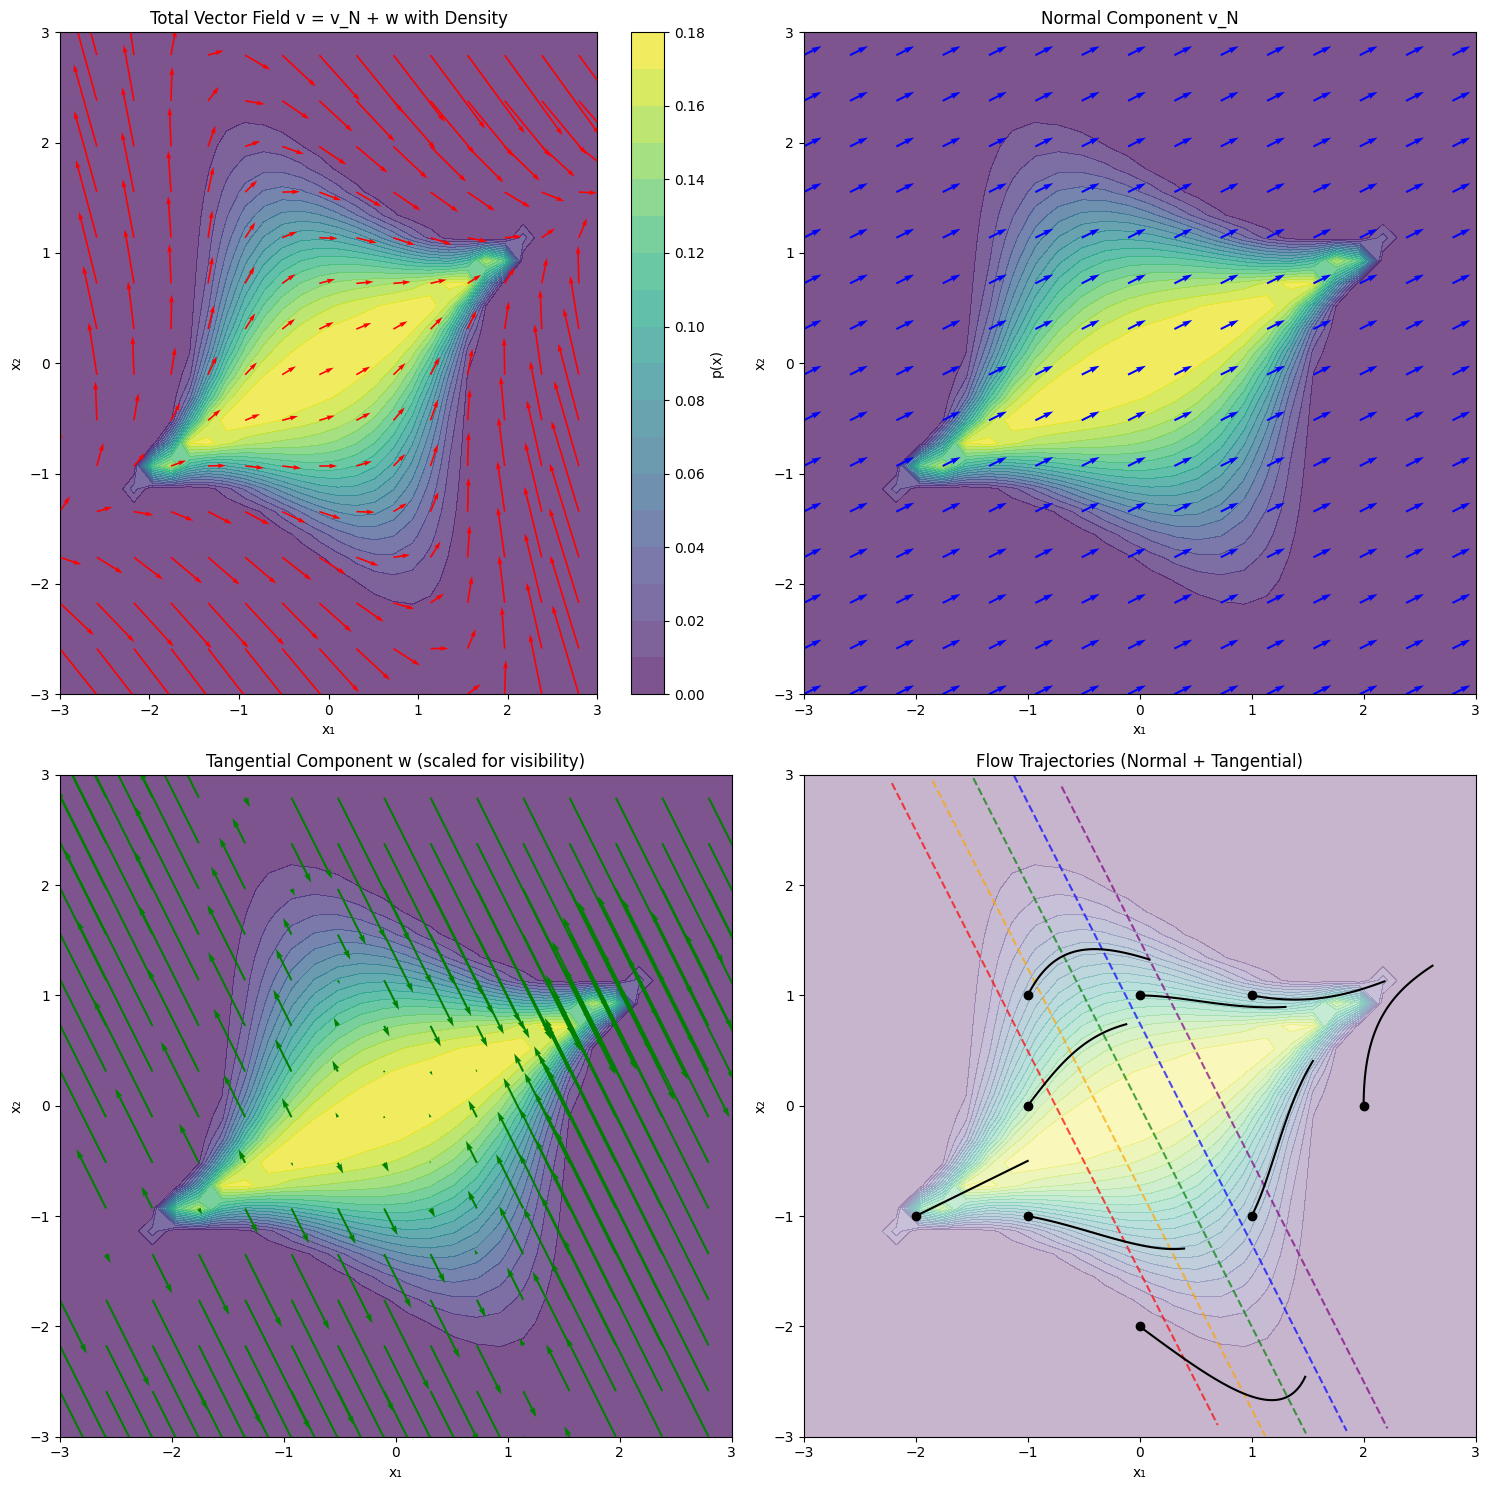

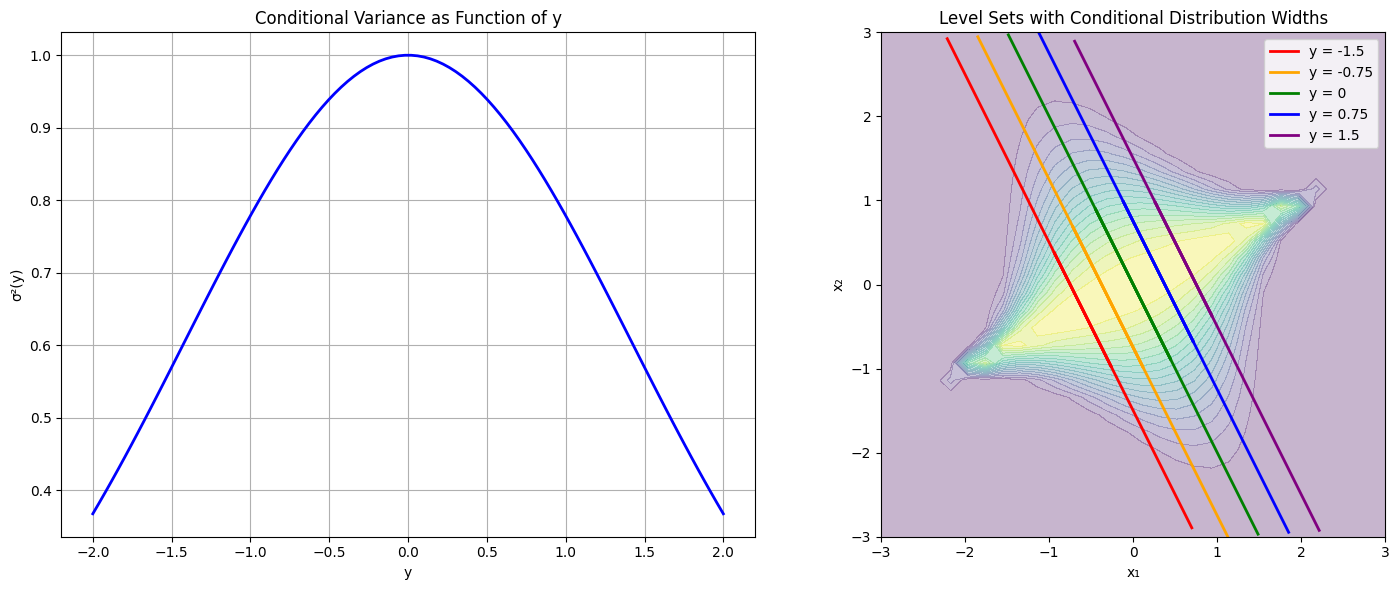

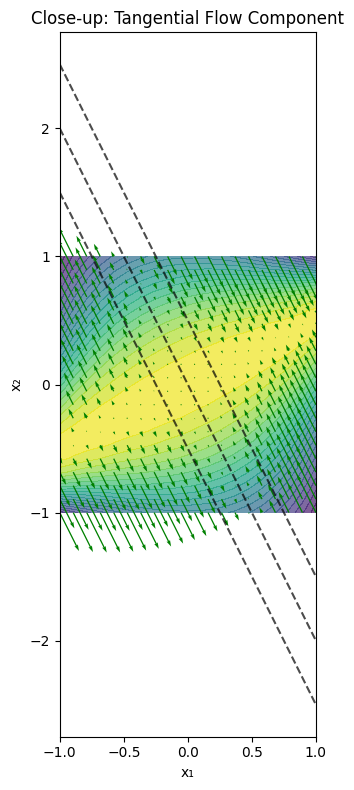

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
from scipy.stats import multivariate_normal
from scipy.integrate import odeint

def construct_special_distribution(x1, x2, a, b):
    """
    Construct a distribution where conditional variance changes with y
    p(x) = p(x|y) * p(y) * |∇f|
    """
    y = a*x1 + b*x2
    
    # Marginal distribution p(y) - Gaussian
    p_y = np.exp(-y**2/8) / np.sqrt(8*np.pi)
    
    # Gradient magnitude
    grad_f_norm = np.sqrt(a**2 + b**2)
    
    # Conditional mean (on the level set)
    mean_y = np.array([a*y/(a**2+b**2), b*y/(a**2+b**2)])
    
    # Distance from mean along tangent direction
    tangent = np.array([-b, a]) / grad_f_norm
    x = np.array([x1, x2])
    dist_tangent = np.dot(x - mean_y, tangent)
    
    # Conditional variance that changes with y
    sigma2_y = np.exp(-y**2/4)  # Variance decreases away from y=0
    
    # Conditional distribution
    p_x_given_y = np.exp(-dist_tangent**2/(2*sigma2_y)) / np.sqrt(2*np.pi*sigma2_y)
    
    # Total distribution
    p_x = p_x_given_y * p_y * grad_f_norm
    
    return p_x, p_x_given_y, p_y, sigma2_y

def compute_source_term(x1, x2, a, b):
    """Compute the source term S(x) = -∇·(p*v_N)"""
    p, _, _, _ = construct_special_distribution(x1, x2, a, b)
    
    # Normal vector field
    grad_f_norm_sq = a**2 + b**2
    v_N = np.array([a, b]) / grad_f_norm_sq
    
    # Numerical gradient for source term
    h = 1e-6
    
    # Compute divergence numerically
    p_vN_x = p * v_N[0]
    p_vN_y = p * v_N[1]
    
    # ∂(p*v_N_x)/∂x
    p_plus_x, _, _, _ = construct_special_distribution(x1+h, x2, a, b)
    p_minus_x, _, _, _ = construct_special_distribution(x1-h, x2, a, b)
    div_x = (p_plus_x*v_N[0] - p_minus_x*v_N[0]) / (2*h)
    
    # ∂(p*v_N_y)/∂y
    p_plus_y, _, _, _ = construct_special_distribution(x1, x2+h, a, b)
    p_minus_y, _, _, _ = construct_special_distribution(x1, x2-h, a, b)
    div_y = (p_plus_y*v_N[1] - p_minus_y*v_N[1]) / (2*h)
    
    S = -(div_x + div_y)
    
    return S

def compute_tangential_component(x1, x2, a, b):
    """
    Compute the tangential component w(x)
    For this special case, we can derive it analytically
    """
    y = a*x1 + b*x2
    
    p, p_x_given_y, p_y, sigma2_y = construct_special_distribution(x1, x2, a, b)
    
    # Gradient of variance
    d_sigma2_dy = -y/2 * np.exp(-y**2/4)
    
    # Tangent vector (normalized)
    grad_f_norm = np.sqrt(a**2 + b**2)
    tangent = np.array([-b, a]) / grad_f_norm
    
    # Mean position on level set
    mean_y = np.array([a*y/(a**2+b**2), b*y/(a**2+b**2)])
    
    # Distance from mean along tangent
    x = np.array([x1, x2])
    dist_tangent = np.dot(x - mean_y, tangent)
    
    # Tangential component (derived analytically)
    # w = (d_sigma2_dy / (2*sigma2_y)) * dist_tangent * tangent
    w = (d_sigma2_dy / (2*sigma2_y)) * dist_tangent * tangent
    
    return w

# Parameters
a, b = 2.0, 1.0  # Coefficients for f(x) = ax₁ + bx₂

# Create grid
x_range = np.linspace(-3, 3, 30)
y_range = np.linspace(-3, 3, 30)
X, Y = np.meshgrid(x_range, y_range)

# Compute distribution and vector field components
density = np.zeros_like(X)
v_N_x = np.zeros_like(X)
v_N_y = np.zeros_like(X)
w_x = np.zeros_like(X)
w_y = np.zeros_like(Y)

grad_f_norm_sq = a**2 + b**2

for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        x1, x2 = X[i,j], Y[i,j]
        
        # Density
        density[i,j], _, _, _ = construct_special_distribution(x1, x2, a, b)
        
        # Normal component
        v_N_x[i,j] = a / grad_f_norm_sq
        v_N_y[i,j] = b / grad_f_norm_sq
        
        # Tangential component
        w = compute_tangential_component(x1, x2, a, b)
        w_x[i,j] = w[0]
        w_y[i,j] = w[1]

# Total vector field
v_x = v_N_x + w_x
v_y = v_N_y + w_y

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 15))

# 1. Vector field with density
ax = axes[0, 0]
cs = ax.contourf(X, Y, density, levels=20, cmap='viridis', alpha=0.7)
ax.quiver(X[::2,::2], Y[::2,::2], v_x[::2,::2], v_y[::2,::2], 
          scale=15, width=0.003, color='red')
ax.set_title('Total Vector Field v = v_N + w with Density')
ax.set_xlabel('x₁')
ax.set_ylabel('x₂')
plt.colorbar(cs, ax=ax, label='p(x)')

# 2. Normal component
ax = axes[0, 1]
ax.contourf(X, Y, density, levels=20, cmap='viridis', alpha=0.7)
ax.quiver(X[::2,::2], Y[::2,::2], v_N_x[::2,::2], v_N_y[::2,::2], 
          scale=15, width=0.003, color='blue')
ax.set_title('Normal Component v_N')
ax.set_xlabel('x₁')
ax.set_ylabel('x₂')

# 3. Tangential component
ax = axes[1, 0]
ax.contourf(X, Y, density, levels=20, cmap='viridis', alpha=0.7)
# Scale up tangential component for visibility
ax.quiver(X[::2,::2], Y[::2,::2], w_x[::2,::2], w_y[::2,::2], 
          scale=5, width=0.003, color='green')
ax.set_title('Tangential Component w (scaled for visibility)')
ax.set_xlabel('x₁')
ax.set_ylabel('x₂')

# 4. Flow trajectories
ax = axes[1, 1]
ax.contourf(X, Y, density, levels=20, cmap='viridis', alpha=0.3)

# Draw level sets
y_vals = [-1.5, -0.75, 0, 0.75, 1.5]
colors = ['red', 'orange', 'green', 'blue', 'purple']

for y_val, color in zip(y_vals, colors):
    x1_vals = np.linspace(-3, 3, 100)
    x2_vals = (y_val - a*x1_vals) / b
    mask = (x2_vals >= -3) & (x2_vals <= 3)
    ax.plot(x1_vals[mask], x2_vals[mask], '--', color=color, alpha=0.7)

# Define ODE for flow
def flow_ode(state, t):
    x1, x2 = state
    # Normal component
    v_N = np.array([a, b]) / grad_f_norm_sq
    # Tangential component
    w = compute_tangential_component(x1, x2, a, b)
    # Total velocity
    v = v_N + w
    return v

# Draw flow trajectories
start_points = [[-2, -1], [-1, -1], [0, -2], [1, -1], [2, 0], 
                [1, 1], [0, 1], [-1, 1], [-1, 0]]

# start_points = [[-1/b-b/5*i*noise, -1/a+a/5*i*noise] for i,noise in zip(range(-3,4), np.random.random(7))]

for start in start_points:
    t_span = np.linspace(0, 2.5, 50)
    trajectory = odeint(flow_ode, start, t_span)
    
    ax.plot(trajectory[:, 0], trajectory[:, 1], 'k-', linewidth=1.5)
    ax.plot(trajectory[0, 0], trajectory[0, 1], 'ko', markersize=6)

ax.set_title('Flow Trajectories (Normal + Tangential)')
ax.set_xlabel('x₁')
ax.set_ylabel('x₂')
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)

plt.tight_layout()
plt.show()

# Visualize how conditional variance changes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot variance as function of y
y_range = np.linspace(-2, 2, 100)
sigma2_values = np.exp(-y_range**2/4)

ax1.plot(y_range, sigma2_values, 'b-', linewidth=2)
ax1.set_xlabel('y')
ax1.set_ylabel('σ²(y)')
ax1.set_title('Conditional Variance as Function of y')
ax1.grid(True)

# Visualize conditional distributions at different y values
ax2.contourf(X, Y, density, levels=20, cmap='viridis', alpha=0.3)

for y_val, color in zip(y_vals, colors):
    # Level set line
    x1_vals = np.linspace(-3, 3, 100)
    x2_vals = (y_val - a*x1_vals) / b
    mask = (x2_vals >= -3) & (x2_vals <= 3)
    ax2.plot(x1_vals[mask], x2_vals[mask], color=color, linewidth=2, 
            label=f'y = {y_val}')
    
    # Show variance ellipse
    mean_y = np.array([a*y_val/(a**2+b**2), b*y_val/(a**2+b**2)])
    sigma2_y = np.exp(-y_val**2/4)
    
    # Tangent direction
    tangent = np.array([-b, a]) / np.sqrt(a**2 + b**2)
    
    # Draw ellipse representing 1-sigma contour
    theta = np.linspace(0, 2*np.pi, 100)
    ellipse = mean_y[:, np.newaxis] + np.sqrt(sigma2_y) * tangent[:, np.newaxis] * np.cos(theta)
    ax2.plot(ellipse[0], ellipse[1], color=color, linewidth=2)

ax2.set_title('Level Sets with Conditional Distribution Widths')
ax2.set_xlabel('x₁')
ax2.set_ylabel('x₂')
ax2.legend()
ax2.set_xlim(-3, 3)
ax2.set_ylim(-3, 3)
ax2.set_aspect('equal')

plt.tight_layout()
plt.show()

# Close-up view of tangential flow effect
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Zoom in on a region
x_zoom = np.linspace(-1, 1, 20)
y_zoom = np.linspace(-1, 1, 20)
X_zoom, Y_zoom = np.meshgrid(x_zoom, y_zoom)

# Compute components for zoomed region
w_x_zoom = np.zeros_like(X_zoom)
w_y_zoom = np.zeros_like(Y_zoom)
density_zoom = np.zeros_like(X_zoom)

for i in range(X_zoom.shape[0]):
    for j in range(X_zoom.shape[1]):
        x1, x2 = X_zoom[i,j], Y_zoom[i,j]
        density_zoom[i,j], _, _, _ = construct_special_distribution(x1, x2, a, b)
        w = compute_tangential_component(x1, x2, a, b)
        w_x_zoom[i,j] = w[0]
        w_y_zoom[i,j] = w[1]

ax.contourf(X_zoom, Y_zoom, density_zoom, levels=20, cmap='viridis', alpha=0.7)
ax.quiver(X_zoom, Y_zoom, w_x_zoom, w_y_zoom, scale=2, width=0.005, color='green')

# Draw some level sets
for y_val in [-0.5, 0, 0.5]:
    x1_vals = np.linspace(-1, 1, 100)
    x2_vals = (y_val - a*x1_vals) / b
    ax.plot(x1_vals, x2_vals, 'k--', alpha=0.7)

ax.set_title('Close-up: Tangential Flow Component')
ax.set_xlabel('x₁')
ax.set_ylabel('x₂')
ax.set_aspect('equal')

plt.tight_layout()
plt.show()

In [2]:
"""
Level Set Embedding Methods for PyTorch Models

This module provides methods to embed level sets of differentiable functions,
particularly useful for analyzing latent spaces of neural networks.

Key Features:
- Compatible with PyTorch automatic differentiation
- Multiple embedding methods (projection, flow-based, geodesic)
- Handles numerical stability and edge cases
- GPU compatible

Quick Start:
    model = YourModel()  # Maps R^n -> R
    points = torch.randn(100, n)
    embeddings = quick_embed(model, points)  # Returns (100, n-1) tensor

Common Issues and Solutions:
1. "does not require grad" error: Make sure model is not wrapped in torch.no_grad()
2. Gradient vanishing: Check if model outputs vary with input
3. Memory issues: Process in smaller batches
4. Inconsistent results: Set model.eval() to disable dropout/batch norm

GPU Usage:
    model = model.cuda()
    points = points.cuda() 
    embeddings = quick_embed(model, points)  # Automatically handles device
"""

import torch
import torch.nn as nn
import numpy as np
from typing import Callable, Tuple, Optional


# Quick start example - simplest way to use
def quick_embed(model: nn.Module, points: torch.Tensor) -> torch.Tensor:
    """
    Simplest way to embed points using their level sets.
    
    Args:
        model: PyTorch model mapping R^n -> R
        points: Tensor of shape (batch_size, n)
    
    Returns:
        Embeddings of shape (batch_size, n-1)
    
    Example:
        >>> model = YourTrainedModel()  # R^10 -> R
        >>> points = torch.randn(100, 10)  # 100 points in R^10
        >>> embeddings = quick_embed(model, points)  # 100 points in R^9
    """
    device = next(model.parameters()).device
    points = points.to(device)
    n = points.shape[1]
    embeddings = []
    
    model.eval()  # Important: set to eval mode for consistency
    
    for point in points:
        # Enable gradients
        x = point.clone().detach().requires_grad_(True)
        
        # Forward pass
        y = model(x.unsqueeze(0) if x.dim() == 1 else x)
        
        # Compute gradient
        grad = torch.autograd.grad(y.sum(), x, create_graph=False)[0]
        grad_norm = torch.norm(grad) + 1e-8
        
        # Handle degenerate case
        if grad_norm < 1e-6:
            # Use random projection as fallback
            random_proj = torch.randn(n, n-1, device=device)
            random_proj = torch.qr(random_proj)[0][:, :n-1]
            embedding = random_proj.T @ point
            embeddings.append(embedding.detach())
            continue
        
        # Normal vector to level set
        n_vec = grad / grad_norm
        
        # Create orthonormal basis using QR decomposition
        # More stable than Gram-Schmidt
        Q = torch.eye(n, device=device)
        Q[:, 0] = n_vec
        Q, _ = torch.linalg.qr(Q)
        
        # First n-1 columns after the gradient direction
        tangent_basis = Q[:, 1:n]
        
        # Project point onto tangent basis
        embedding = tangent_basis.T @ x.detach()
        embeddings.append(embedding)
    
    return torch.stack(embeddings)


class LevelSetEmbedding:
    """
    Numerical methods for embedding level sets of differentiable functions.
    Compatible with PyTorch models and automatic differentiation.
    """
    
    def __init__(self, f: Callable[[torch.Tensor], torch.Tensor], dim: int):
        """
        Args:
            f: Function R^n -> R (e.g., output of a PyTorch model)
            dim: Input dimension n
        """
        self.f = f
        self.dim = dim
    
    def gradient(self, x: torch.Tensor) -> torch.Tensor:
        """Compute gradient of f at x using automatic differentiation."""
        x = x.clone().detach().requires_grad_(True)
        y = self.f(x)
        if y.dim() > 0:
            y = y.sum()
        grad = torch.autograd.grad(y, x, create_graph=True)[0]
        return grad
    
    def hessian(self, x: torch.Tensor) -> torch.Tensor:
        """Compute Hessian matrix at x."""
        x = x.clone().detach().requires_grad_(True)
        grad = self.gradient(x)
        H = torch.zeros(x.shape[-1], x.shape[-1])
        
        for i in range(x.shape[-1]):
            if grad[i].requires_grad:
                grad_i = torch.autograd.grad(grad[i], x, retain_graph=True, create_graph=True)[0]
                H[i] = grad_i.detach()
            else:
                # Use finite differences as fallback
                eps = 1e-4
                x_plus = x.clone()
                x_plus[i] += eps
                x_minus = x.clone() 
                x_minus[i] -= eps
                grad_plus = self.gradient(x_plus)
                grad_minus = self.gradient(x_minus)
                H[i] = (grad_plus - grad_minus).detach() / (2 * eps)
        
        return H
    
    # Method 1: Orthogonal Projection Method
    def orthogonal_projection_embedding(self, x: torch.Tensor) -> torch.Tensor:
        """
        Project onto hyperplane orthogonal to gradient.
        This gives local coordinates on the level set.
        """
        # Ensure we have a fresh tensor with gradients enabled
        x_grad = x.clone().detach().requires_grad_(True)
        
        # Compute gradient
        grad = self.gradient(x_grad)
        grad_norm = torch.norm(grad, dim=-1 if grad.dim() > 1 else 0, keepdim=True)
        
        # Normalize gradient
        n = grad / (grad_norm + 1e-8)
        
        # Use QR decomposition for stable orthogonalization
        # Create a matrix where the first column is the gradient
        Q = torch.zeros(self.dim, self.dim)
        Q[:, 0] = n.detach()  # Detach to avoid gradient issues
        
        # Fill with linearly independent vectors
        idx = 1
        for i in range(self.dim):
            if abs(n[i].item()) < 0.9:  # Avoid nearly parallel vectors
                e_i = torch.zeros(self.dim)
                e_i[i] = 1.0
                Q[:, idx] = e_i
                idx += 1
                if idx >= self.dim:
                    break
        
        # Complete with random vectors if needed
        while idx < self.dim:
            Q[:, idx] = torch.randn(self.dim)
            idx += 1
        
        # QR decomposition
        Q, R = torch.linalg.qr(Q)
        
        # The last n-1 columns of Q form an orthonormal basis for the tangent space
        # (assuming the gradient is the first column after QR)
        tangent_basis = Q[:, 1:self.dim]
        
        # Project x onto the tangent space
        x_detached = x.detach()  # Detach to avoid gradient computation issues
        embedding = torch.matmul(tangent_basis.T, x_detached)
        
        return embedding
    
    # Method 2: Flow-Based Parameterization
    def flow_based_embedding(self, x: torch.Tensor, reference_level: float = 0.0) -> Tuple[torch.Tensor, float]:
        """
        Use gradient flow to map to reference level set, then apply embedding there.
        Returns: (embedding_coords, flow_time)
        """
        # Work with a detached copy to avoid gradient accumulation
        x_flow = x.clone().detach()
        current_level = self.f(x_flow).item()
        
        # Flow to reference level
        dt = 0.01
        max_steps = 1000
        flow_time = 0.0
        
        for _ in range(max_steps):
            x_flow.requires_grad_(True)
            level = self.f(x_flow).item()
            
            if abs(level - reference_level) < 1e-4:
                break
            
            grad = self.gradient(x_flow)
            grad_norm = torch.norm(grad)
            
            if grad_norm < 1e-6:
                break  # Critical point
            
            # Adaptive step size
            step = dt * (reference_level - level) / (grad_norm + 1e-8)
            
            # Update position (detach gradient to avoid accumulation)
            x_flow = x_flow.detach() + step * grad.detach() / grad_norm
            flow_time += abs(step)
        
        # Apply embedding at reference level
        embedding = self.orthogonal_projection_embedding(x_flow)
        
        return embedding, flow_time
    
    # Method 3: Principal Component Analysis on Level Set
    def pca_embedding(self, level_value: float, num_samples: int = 1000) -> Callable:
        """
        Sample points on level set and use PCA for embedding.
        Returns a function that maps points to embedded coordinates.
        """
        # Sample points near the level set
        samples = []
        
        for _ in range(num_samples * 10):  # Oversample and filter
            x = torch.randn(self.dim)
            # Use gradient descent to project onto level set
            x = self.project_to_level_set(x, level_value)
            if x is not None:
                samples.append(x)
            
            if len(samples) >= num_samples:
                break
        
        if len(samples) < self.dim:
            raise ValueError("Not enough samples on level set")
        
        samples = torch.stack(samples)
        
        # Compute PCA
        mean = samples.mean(dim=0)
        centered = samples - mean
        cov = torch.matmul(centered.T, centered) / len(samples)
        
        eigenvalues, eigenvectors = torch.linalg.eigh(cov)
        
        # Sort by eigenvalue (descending)
        idx = eigenvalues.argsort(descending=True)
        eigenvectors = eigenvectors[:, idx]
        
        # Embedding function
        def embed(x: torch.Tensor) -> torch.Tensor:
            return torch.matmul(eigenvectors[:, :self.dim-1].T, x - mean)
        
        return embed
    
    # Method 4: Geodesic Normal Coordinates
    def geodesic_normal_embedding(self, x: torch.Tensor) -> torch.Tensor:
        """
        Use second-order information (Hessian) to define coordinates
        that respect the geometry of the level set.
        """
        x_grad = x.clone().detach().requires_grad_(True)
        grad = self.gradient(x_grad)
        H = self.hessian(x_grad)
        
        # Project Hessian to tangent space of level set
        grad_norm = torch.norm(grad)
        n = grad / (grad_norm + 1e-8)
        n = n.detach()  # Detach to avoid gradient issues
        
        # Tangent space projection: P = I - nn^T
        P = torch.eye(self.dim) - torch.outer(n, n)
        H_tangent = torch.matmul(P, torch.matmul(H, P))
        
        # Eigendecomposition of restricted Hessian
        eigenvalues, eigenvectors = torch.linalg.eigh(H_tangent)
        
        # Sort by absolute eigenvalue (descending)
        # The eigenvector corresponding to the smallest eigenvalue should be 
        # approximately the gradient direction (which we want to exclude)
        idx = eigenvalues.abs().argsort(descending=True)
        basis = eigenvectors[:, idx[:self.dim-1]]
        
        # Project x onto this basis
        x_detached = x.detach()
        embedding = torch.matmul(basis.T, x_detached)
        
        return embedding
    
    # Utility: Project point to level set
    def project_to_level_set(self, x: torch.Tensor, target_level: float, 
                            tol: float = 1e-4, max_iter: int = 100) -> Optional[torch.Tensor]:
        """Newton's method to project point onto level set f(x) = target_level."""
        x_proj = x.clone().detach()
        
        for _ in range(max_iter):
            x_proj.requires_grad_(True)
            f_val = self.f(x_proj)
            
            if abs(f_val.item() - target_level) < tol:
                return x_proj.detach()
            
            grad = self.gradient(x_proj)
            grad_norm_sq = torch.sum(grad * grad)
            
            if grad_norm_sq < 1e-12:
                return None  # Critical point
            
            # Newton step: x = x - (f(x) - c) * grad(f) / ||grad(f)||^2
            step = (f_val - target_level) * grad / grad_norm_sq
            x_proj = x_proj.detach() - step.detach()
        
        # Check if converged close enough
        f_final = self.f(x_proj)
        if abs(f_final.item() - target_level) < tol * 10:
            return x_proj.detach()
        
        return None
    
    # Method 5: Continuous Normalization Flow
    def cnf_embedding(self, x: torch.Tensor, reference_samples: torch.Tensor) -> torch.Tensor:
        """
        Use ideas from continuous normalizing flows to define embeddings
        that are consistent across level sets.
        """
        # This is a simplified version - full CNF would require ODE solvers
        
        # Map to reference distribution using gradient flow
        x_ref, _ = self.flow_based_embedding(x, reference_level=0.0)
        
        # Apply learned transformation (simplified as linear here)
        # In practice, this could be a neural network
        transform = torch.nn.Linear(self.dim - 1, self.dim - 1)
        embedding = transform(x_ref)
        
        return embedding


# Example usage with a PyTorch model
class ExampleModel(nn.Module):
    """Example PyTorch model for demonstration."""
    def __init__(self, input_dim: int, hidden_dim: int = 64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
    
    def forward(self, x):
        return self.net(x).squeeze(-1)


def demonstrate_embedding_methods():
    """Demonstrate different embedding methods on a trained model."""
    
    # Setup
    dim = 10  # Latent space dimension
    model = ExampleModel(dim)
    
    # Create wrapper function for the model that preserves gradients
    def f(x):
        return model(x)
    
    # Initialize embedding computer
    embedder = LevelSetEmbedding(f, dim)
    
    # Test point
    x = torch.randn(dim)
    
    print("Testing different embedding methods:")
    print(f"Input dimension: {dim}")
    print(f"Embedding dimension: {dim-1}")
    print()
    
    # Method 1: Orthogonal Projection
    try:
        emb1 = embedder.orthogonal_projection_embedding(x)
        print(f"1. Orthogonal Projection: {emb1.shape}")
    except Exception as e:
        print(f"1. Orthogonal Projection failed: {e}")
    
    # Method 2: Flow-based
    try:
        emb2, flow_time = embedder.flow_based_embedding(x)
        print(f"2. Flow-based: {emb2.shape}, flow time: {flow_time:.4f}")
    except Exception as e:
        print(f"2. Flow-based failed: {e}")
    
    # Method 3: Geodesic Normal
    try:
        emb4 = embedder.geodesic_normal_embedding(x)
        print(f"3. Geodesic Normal: {emb4.shape}")
    except Exception as e:
        print(f"3. Geodesic Normal failed: {e}")


# Practical implementation for production use
class RobustLevelSetEmbedder:
    """
    Production-ready embedder with numerical stability and efficiency.
    """
    
    def __init__(self, model: nn.Module, input_dim: int, method: str = 'projection'):
        self.model = model
        self.input_dim = input_dim
        self.method = method
        
        # Precompute reference level statistics if needed
        self.reference_level = 0.0
        self._setup_reference()
    
    def _setup_reference(self):
        """Setup reference level set for consistent embeddings."""
        # Sample points to estimate typical level values
        samples = torch.randn(1000, self.input_dim)
        with torch.no_grad():
            levels = self.model(samples)
        self.reference_level = levels.median().item()
    
    def embed_batch(self, X: torch.Tensor) -> torch.Tensor:
        """
        Efficiently embed a batch of points.
        
        Args:
            X: Tensor of shape (batch_size, input_dim)
        
        Returns:
            Embeddings of shape (batch_size, input_dim - 1)
        """
        batch_size = X.shape[0]
        embeddings = []
        
        for i in range(batch_size):
            x = X[i].clone().detach().requires_grad_(True)
            
            # Compute gradient
            y = self.model(x.unsqueeze(0))
            grad = torch.autograd.grad(y, x, create_graph=False)[0]
            
            # Apply embedding based on chosen method
            if self.method == 'projection':
                emb = self._orthogonal_projection(x.detach(), grad.detach())
            elif self.method == 'flow':
                emb = self._flow_embedding(x.detach(), grad.detach())
            else:
                raise ValueError(f"Unknown method: {self.method}")
            
            embeddings.append(emb)
        
        return torch.stack(embeddings)
    
    def _orthogonal_projection(self, x: torch.Tensor, grad: torch.Tensor) -> torch.Tensor:
        """Fast orthogonal projection implementation."""
        # Normalize gradient
        grad_norm = torch.norm(grad) + 1e-8
        n = grad / grad_norm
        
        # Use QR decomposition for stable orthogonalization
        # Create matrix with gradient as first column
        Q = torch.zeros(self.input_dim, self.input_dim)
        Q[:, 0] = n
        
        # Fill remaining columns with standard basis
        j = 1
        for i in range(self.input_dim):
            if abs(n[i]) < 0.9:  # Avoid parallel vectors
                Q[:, j] = torch.zeros(self.input_dim)
                Q[i, j] = 1.0
                j += 1
                if j >= self.input_dim:
                    break
        
        # QR decomposition
        Q, _ = torch.linalg.qr(Q)
        
        # Take columns orthogonal to gradient
        tangent_basis = Q[:, 1:]
        
        # Project x
        embedding = torch.matmul(tangent_basis.T, x)
        
        return embedding
    
    def _flow_embedding(self, x: torch.Tensor, grad: torch.Tensor) -> torch.Tensor:
        """Simplified flow embedding for efficiency."""
        # For production, often just using the projection at current level is sufficient
        # Full flow integration can be expensive
        return self._orthogonal_projection(x, grad)



# Practical integration example with error handling
def integrate_with_trained_model(model: nn.Module, latent_points: torch.Tensor) -> torch.Tensor:
    """
    Example of how to integrate level set embedding with a trained PyTorch model.
    
    Args:
        model: Your trained PyTorch model (R^n -> R)
        latent_points: Points in latent space (batch_size, n)
    
    Returns:
        embeddings: Level set embeddings (batch_size, n-1)
    """
    input_dim = latent_points.shape[1]
    
    # Ensure model is in eval mode for consistent behavior
    model.eval()
    
    # Create embedding system
    embedder = RobustLevelSetEmbedder(model, input_dim, method='projection')
    
    # Process in batches for memory efficiency
    batch_size = 100
    all_embeddings = []
    
    for i in range(0, len(latent_points), batch_size):
        batch = latent_points[i:i + batch_size]
        
        try:
            embeddings = embedder.embed_batch(batch)
            all_embeddings.append(embeddings)
        except Exception as e:
            print(f"Warning: Failed to embed batch {i//batch_size}: {e}")
            # Fallback: use random projection
            random_proj = torch.randn(input_dim, input_dim - 1)
            random_proj = torch.qr(random_proj)[0]
            fallback_embeddings = batch @ random_proj
            all_embeddings.append(fallback_embeddings)
    
    return torch.cat(all_embeddings, dim=0)


# Example: Visualizing learned representations
def visualize_level_sets_2d():
    """Example of using embeddings for 2D visualization of high-dimensional level sets."""
    
    # Create a simple model for demonstration
    class VisualizationModel(nn.Module):
        def __init__(self):
            super().__init__()
            self.net = nn.Sequential(
                nn.Linear(10, 20),
                nn.ReLU(),
                nn.Linear(20, 1)
            )
        
        def forward(self, x):
            return self.net(x).squeeze(-1)
    
    model = VisualizationModel()
    
    # Generate points on different level sets
    levels = [-1.0, 0.0, 1.0]
    colors = ['blue', 'green', 'red']
    
    embedder = LevelSetEmbedding(lambda x: model(x), 10)
    
    embedded_points = {level: [] for level in levels}
    
    for level in levels:
        # Sample random points and project to level set
        for _ in range(50):
            x = torch.randn(10)
            x_on_level = embedder.project_to_level_set(x, level)
            
            if x_on_level is not None:
                # Get 2D embedding using PCA of tangent space
                grad = embedder.gradient(x_on_level)
                grad_norm = torch.norm(grad)
                
                if grad_norm > 1e-6:
                    # Get two principal directions in tangent space
                    n = grad / grad_norm
                    
                    # Random vectors orthogonal to gradient
                    v1 = torch.randn(10)
                    v1 = v1 - torch.dot(v1, n) * n
                    v1 = v1 / torch.norm(v1)
                    
                    v2 = torch.randn(10)
                    v2 = v2 - torch.dot(v2, n) * n
                    v2 = v2 - torch.dot(v2, v1) * v1
                    v2 = v2 / torch.norm(v2)
                    
                    # 2D embedding
                    embedding_2d = torch.stack([
                        torch.dot(x_on_level, v1),
                        torch.dot(x_on_level, v2)
                    ])
                    
                    embedded_points[level].append(embedding_2d)
    
    return embedded_points


if __name__ == "__main__":
    demonstrate_embedding_methods()
    
    print("\n" + "="*50 + "\n")
    print("Complete working example with proper gradient handling:")
    print("="*50 + "\n")
    
    # Complete working example
    import torch
    import torch.nn as nn
    
    # Define a simple test function for verification
    class SimpleFunction:
        """Simple quadratic function for testing: f(x) = ||x||^2"""
        def __init__(self):
            pass
        
        def __call__(self, x):
            return torch.sum(x * x, dim=-1 if x.dim() > 1 else 0)
    
    # Test with simple function first
    print("Testing with simple quadratic function f(x) = ||x||^2:")
    dim = 3
    simple_f = SimpleFunction()
    embedder = LevelSetEmbedding(simple_f, dim)
    
    # Test point
    x_test = torch.tensor([1.0, 2.0, 3.0])
    print(f"Test point: {x_test}")
    print(f"Function value: {simple_f(x_test).item():.4f}")
    
    # Test gradient
    grad = embedder.gradient(x_test)
    print(f"Gradient: {grad}")
    print(f"Expected gradient: {2 * x_test}")
    
    # Test embedding
    embedding = embedder.orthogonal_projection_embedding(x_test)
    print(f"Embedding shape: {embedding.shape}")
    print(f"Embedding: {embedding}\n")
    
    # Now test with neural network
    print("Testing with neural network:")
    
    class WorkingExampleModel(nn.Module):
        def __init__(self, input_dim: int):
            super().__init__()
            self.net = nn.Sequential(
                nn.Linear(input_dim, 32),
                nn.Tanh(),
                nn.Linear(32, 16),
                nn.Tanh(),
                nn.Linear(16, 1)
            )
            
            # Initialize with small weights for stable gradients
            for m in self.modules():
                if isinstance(m, nn.Linear):
                    nn.init.normal_(m.weight, 0, 0.1)
                    nn.init.zeros_(m.bias)
        
        def forward(self, x):
            return self.net(x).squeeze(-1)
    
    # Create and test model
    dim = 5
    model = WorkingExampleModel(dim)
    model.eval()  # Set to evaluation mode
    
    # Create embedding system
    embedder = LevelSetEmbedding(lambda x: model(x), dim)
    
    # Test with random point
    x = torch.randn(dim)
    print(f"Input dimension: {dim}")
    print(f"Test point shape: {x.shape}")
    
    # Test each method
    try:
        # Method 1: Orthogonal Projection
        emb1 = embedder.orthogonal_projection_embedding(x)
        print(f"✓ Orthogonal Projection embedding: shape {emb1.shape}")
        
        # Verify orthogonality
        grad = embedder.gradient(x)
        # Check that embedding is orthogonal to gradient
        # (Note: this is approximate due to the basis construction)
        
    except Exception as e:
        print(f"✗ Orthogonal Projection failed: {e}")
    
    try:
        # Method 2: Geodesic Normal
        emb2 = embedder.geodesic_normal_embedding(x)
        print(f"✓ Geodesic Normal embedding: shape {emb2.shape}")
    except Exception as e:
        print(f"✗ Geodesic Normal failed: {e}")
    
    # Demonstrate batch processing
    print("\nBatch processing example:")
    batch_embedder = RobustLevelSetEmbedder(model, dim)
    X_batch = torch.randn(10, dim)
    embeddings_batch = batch_embedder.embed_batch(X_batch)
    print(f"Input batch shape: {X_batch.shape}")
    print(f"Output embeddings shape: {embeddings_batch.shape}")
    
    # Verify that points on same level set have similar embeddings
    print("\nVerifying level set consistency:")
    x1 = torch.randn(dim)
    level1 = model(x1).item()
    
    # Find another point on the same level set
    x2 = torch.randn(dim)
    x2_projected = embedder.project_to_level_set(x2, level1)
    
    if x2_projected is not None:
        level2 = model(x2_projected).item()
        print(f"Point 1 level: {level1:.6f}")
        print(f"Point 2 level: {level2:.6f}")
        print(f"Level difference: {abs(level1 - level2):.2e}")
        
        # Compare embeddings
        emb1 = embedder.orthogonal_projection_embedding(x1)
        emb2 = embedder.orthogonal_projection_embedding(x2_projected)
        print(f"Embedding 1: {emb1[:3]}...")  # Show first 3 components
        print(f"Embedding 2: {emb2[:3]}...")

Testing different embedding methods:
Input dimension: 10
Embedding dimension: 9

1. Orthogonal Projection: torch.Size([9])
2. Flow-based: torch.Size([9]), flow time: 0.6638
3. Geodesic Normal failed: One of the differentiated Tensors appears to not have been used in the graph. Set allow_unused=True if this is the desired behavior.


Complete working example with proper gradient handling:

Testing with simple quadratic function f(x) = ||x||^2:
Test point: tensor([1., 2., 3.])
Function value: 14.0000
Gradient: tensor([2., 4., 6.], grad_fn=<AddBackward0>)
Expected gradient: tensor([2., 4., 6.])
Embedding shape: torch.Size([2])
Embedding: tensor([2.3842e-07, 0.0000e+00])

Testing with neural network:
Input dimension: 5
Test point shape: torch.Size([5])
✓ Orthogonal Projection embedding: shape torch.Size([4])
✗ Geodesic Normal failed: One of the differentiated Tensors appears to not have been used in the graph. Set allow_unused=True if this is the desired behavior.

Batch processing example

/var/folders/nc/zbqbbkkx08z7v1g3mlf8bdn00000gn/T/ipykernel_28571/1379650347.py:344: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


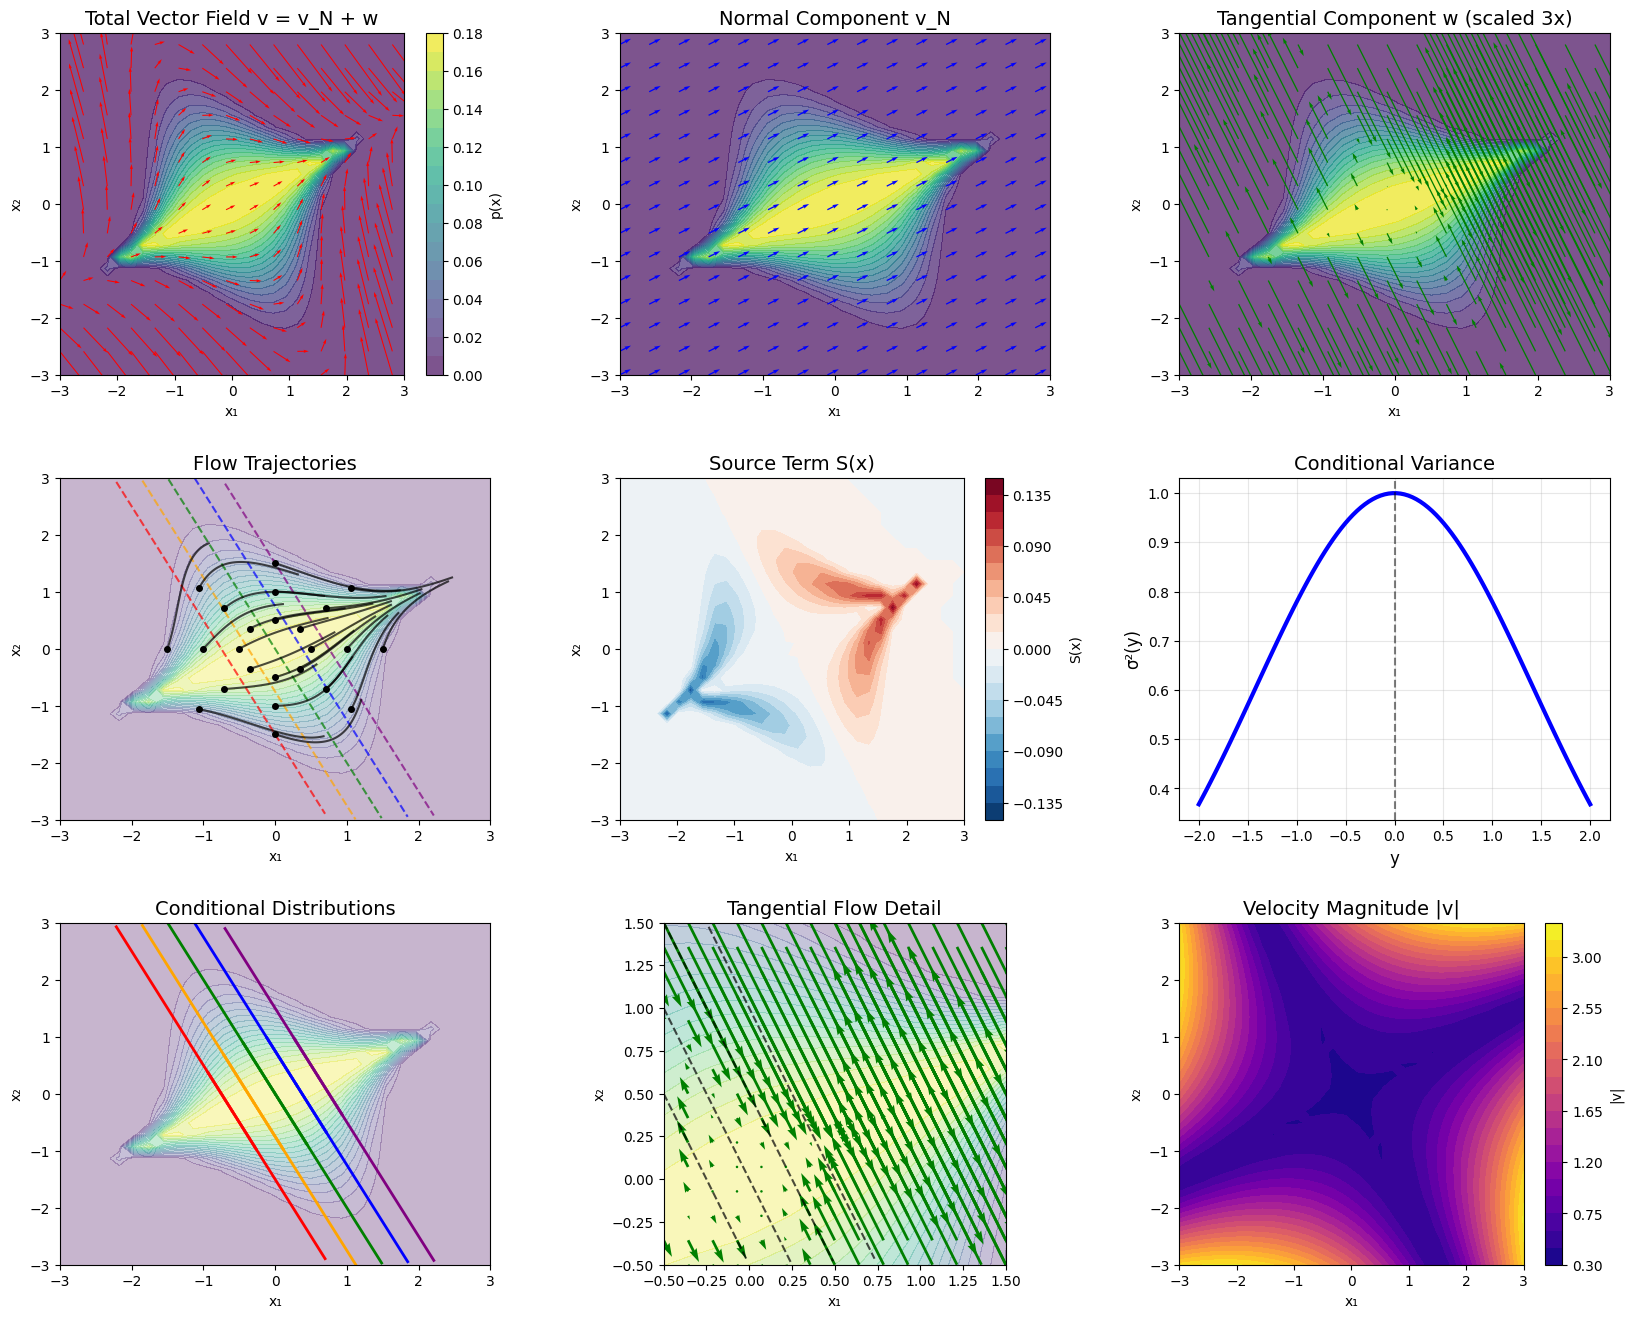

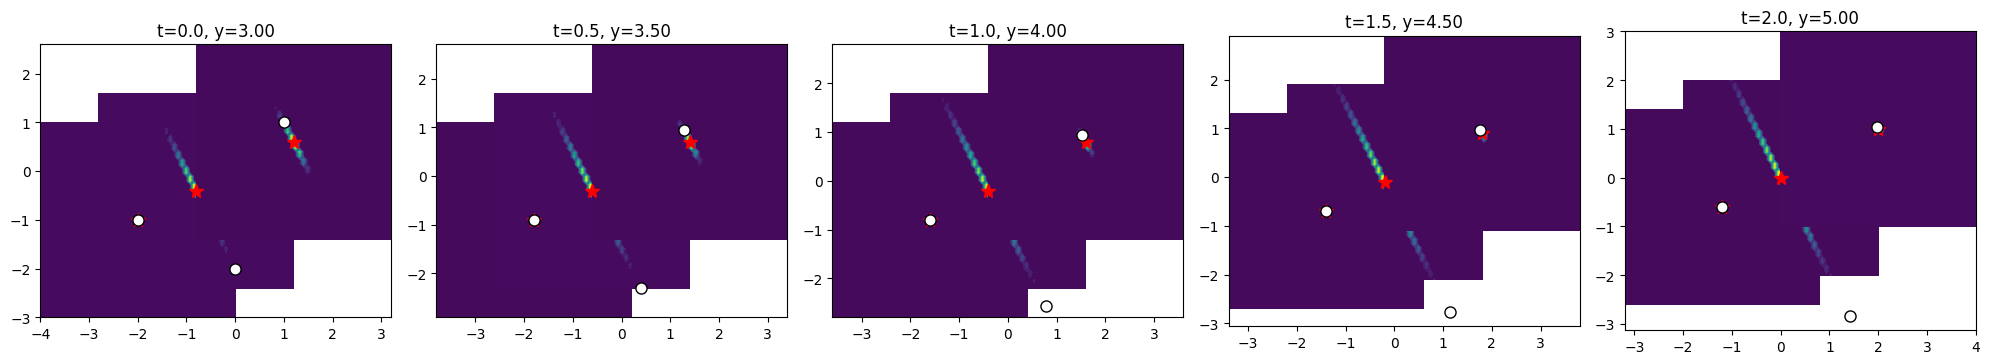

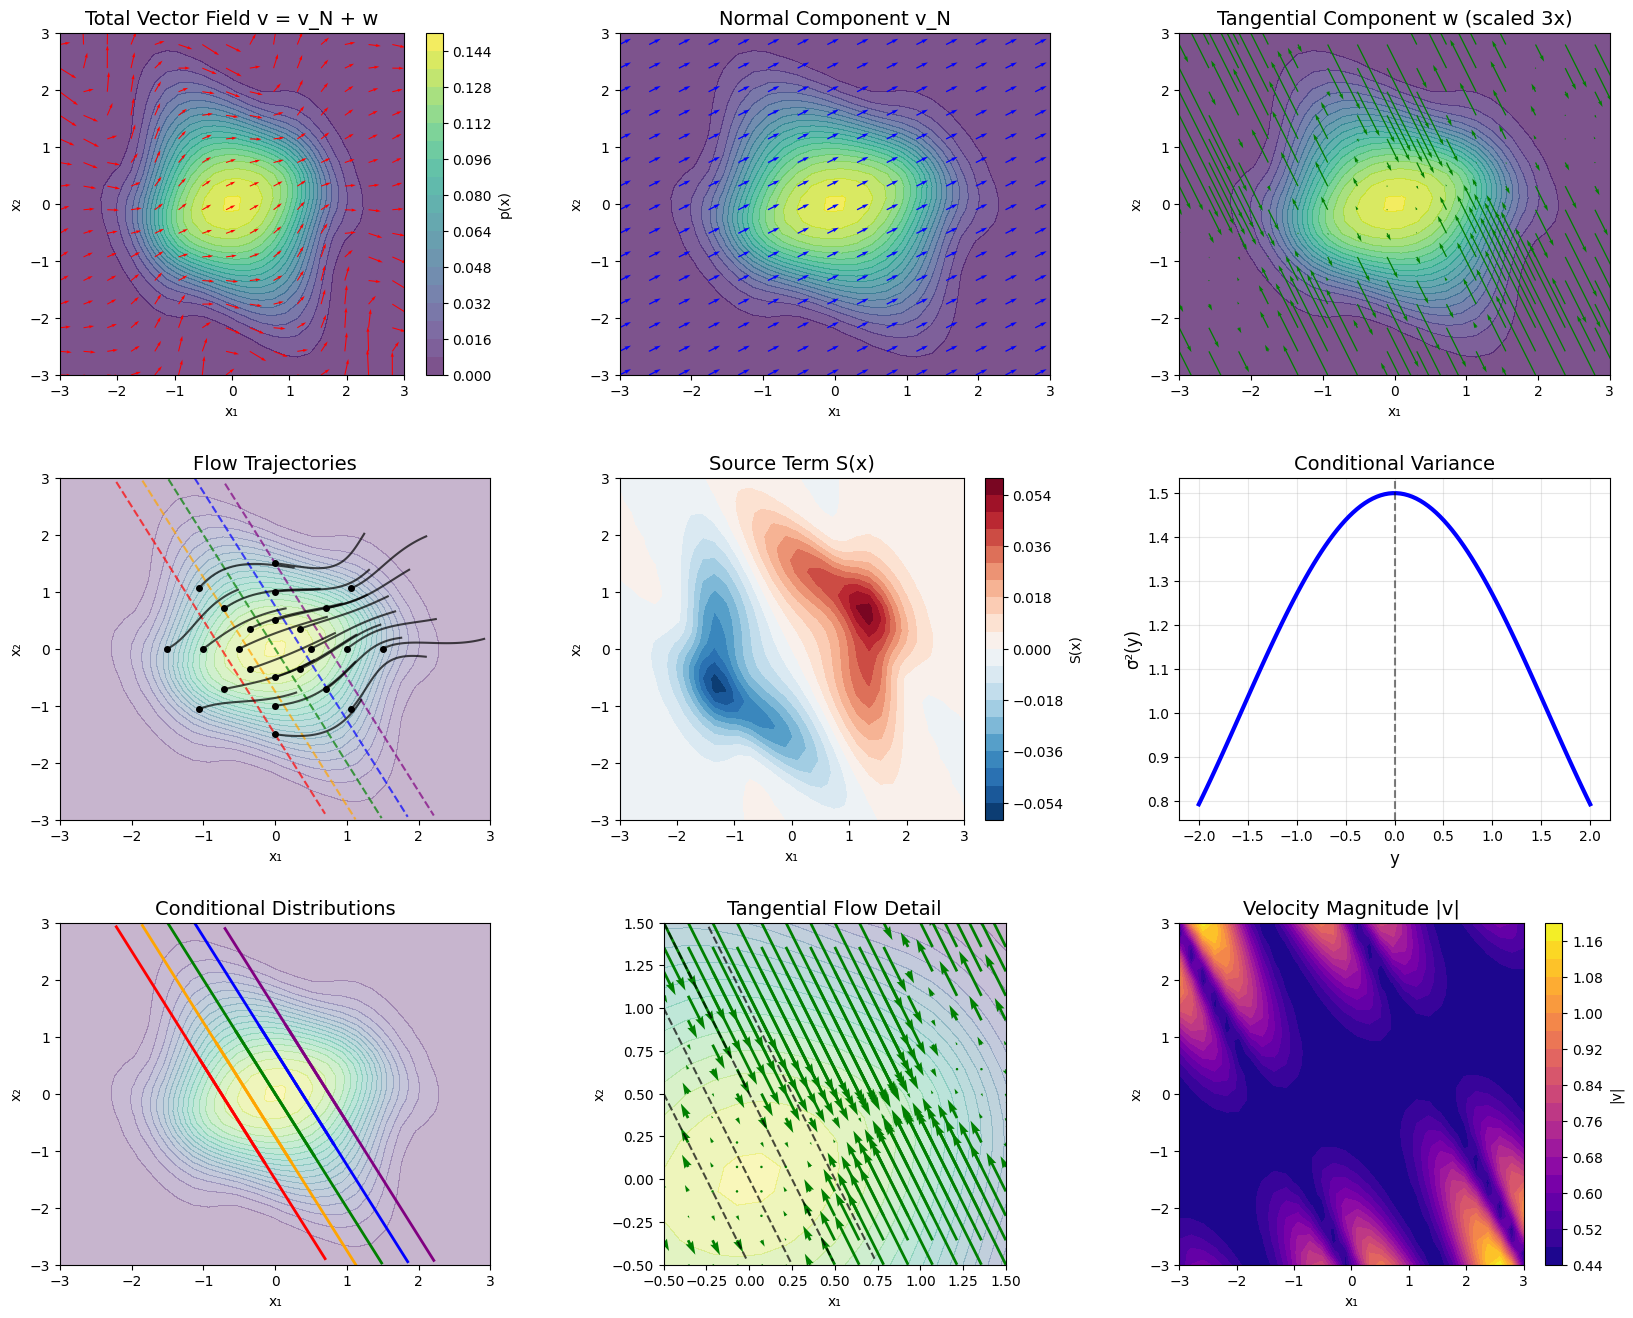

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
from scipy.stats import multivariate_normal
from scipy.integrate import odeint
import matplotlib.gridspec as gridspec

class ConditionalGaussianTransport:
    """
    Solver for transport between level sets with conditional distribution preservation.
    This implementation uses a special distribution where conditional variance changes with y.
    """
    
    def __init__(self, a, b, variance_function=None, marginal_std=2.0):
        """
        Initialize the transport problem.
        
        Args:
            a, b: Coefficients for the linear function f(x) = ax₁ + bx₂
            variance_function: Function that gives conditional variance as function of y
                             Default is exp(-y²/4)
            marginal_std: Standard deviation for marginal distribution p(y)
        """
        self.a = a
        self.b = b
        self.marginal_std = marginal_std
        
        if variance_function is None:
            self.variance_function = lambda y: np.exp(-y**2/4)
            self.variance_derivative = lambda y: -y/2 * np.exp(-y**2/4)
        else:
            self.variance_function = variance_function
            # Numerical derivative if not provided
            h = 1e-6
            self.variance_derivative = lambda y: (variance_function(y+h) - variance_function(y-h))/(2*h)
        
        # Precompute frequently used values
        self.grad_f_norm = np.sqrt(a**2 + b**2)
        self.grad_f_norm_sq = a**2 + b**2
        self.normal_vector = np.array([a, b]) / self.grad_f_norm_sq
        self.tangent_vector = np.array([-b, a]) / self.grad_f_norm
        
    def compute_distribution(self, x1, x2):
        """
        Compute the distribution p(x) and its components.
        
        Returns:
            p_x: Total distribution p(x)
            p_x_given_y: Conditional distribution p(x|y)
            p_y: Marginal distribution p(y)
            sigma2_y: Conditional variance σ²(y)
        """
        y = self.a * x1 + self.b * x2
        
        # Marginal distribution p(y) - Gaussian
        p_y = np.exp(-y**2/(2*self.marginal_std**2)) / (np.sqrt(2*np.pi) * self.marginal_std)
        
        # Conditional mean (on the level set)
        mean_y = np.array([self.a * y / self.grad_f_norm_sq, 
                          self.b * y / self.grad_f_norm_sq])
        
        # Distance from mean along tangent direction
        x = np.array([x1, x2])
        dist_tangent = np.dot(x - mean_y, self.tangent_vector)
        
        # Conditional variance
        sigma2_y = self.variance_function(y)
        
        # Conditional distribution
        p_x_given_y = np.exp(-dist_tangent**2/(2*sigma2_y)) / np.sqrt(2*np.pi*sigma2_y)
        
        # Total distribution
        p_x = p_x_given_y * p_y * self.grad_f_norm
        
        return p_x, p_x_given_y, p_y, sigma2_y
    
    def compute_normal_velocity(self, x1, x2):
        """Compute the normal component v_N of the velocity field."""
        return self.normal_vector
    
    def compute_tangential_velocity(self, x1, x2):
        """Compute the tangential component w of the velocity field."""
        y = self.a * x1 + self.b * x2
        
        # Get distribution components
        _, _, _, sigma2_y = self.compute_distribution(x1, x2)
        
        # Gradient of variance
        d_sigma2_dy = self.variance_derivative(y)
        
        # Mean position on level set
        mean_y = np.array([self.a * y / self.grad_f_norm_sq, 
                          self.b * y / self.grad_f_norm_sq])
        
        # Distance from mean along tangent
        x = np.array([x1, x2])
        dist_tangent = np.dot(x - mean_y, self.tangent_vector)
        
        # Tangential component
        # When variance decreases (d_sigma2_dy < 0), points should move toward mean
        w = (d_sigma2_dy / (2*sigma2_y)) * dist_tangent * self.tangent_vector
        
        return w
    
    def compute_total_velocity(self, x1, x2):
        """Compute the total velocity field v = v_N + w."""
        v_N = self.compute_normal_velocity(x1, x2)
        w = self.compute_tangential_velocity(x1, x2)
        return v_N + w
    
    def compute_source_term(self, x1, x2):
        """Compute the source term S(x) = -∇·(p*v_N)."""
        p, _, _, _ = self.compute_distribution(x1, x2)
        v_N = self.compute_normal_velocity(x1, x2)
        
        # Numerical divergence
        h = 1e-6
        
        # ∂(p*v_N_x)/∂x
        p_plus_x, _, _, _ = self.compute_distribution(x1+h, x2)
        p_minus_x, _, _, _ = self.compute_distribution(x1-h, x2)
        div_x = (p_plus_x*v_N[0] - p_minus_x*v_N[0]) / (2*h)
        
        # ∂(p*v_N_y)/∂y
        p_plus_y, _, _, _ = self.compute_distribution(x1, x2+h)
        p_minus_y, _, _, _ = self.compute_distribution(x1, x2-h)
        div_y = (p_plus_y*v_N[1] - p_minus_y*v_N[1]) / (2*h)
        
        S = -(div_x + div_y)
        return S
    
    def flow_ode(self, state, t):
        """ODE for particle trajectories under the flow."""
        x1, x2 = state
        return self.compute_total_velocity(x1, x2)


def create_visualization(solver, grid_range=(-3, 3), grid_points=30, save_path=None):
    """
    Create comprehensive visualization of the transport problem.
    
    Args:
        solver: ConditionalGaussianTransport instance
        grid_range: Tuple of (min, max) for grid
        grid_points: Number of grid points in each dimension
        save_path: If provided, save the figure to this path
    """
    # Create grid
    x_range = np.linspace(grid_range[0], grid_range[1], grid_points)
    y_range = np.linspace(grid_range[0], grid_range[1], grid_points)
    X, Y = np.meshgrid(x_range, y_range)
    
    # Compute all fields on grid
    density = np.zeros_like(X)
    v_N_x = np.zeros_like(X)
    v_N_y = np.zeros_like(X)
    w_x = np.zeros_like(X)
    w_y = np.zeros_like(X)
    source = np.zeros_like(X)
    
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            x1, x2 = X[i,j], Y[i,j]
            
            # Density
            density[i,j], _, _, _ = solver.compute_distribution(x1, x2)
            
            # Normal component
            v_N = solver.compute_normal_velocity(x1, x2)
            v_N_x[i,j] = v_N[0]
            v_N_y[i,j] = v_N[1]
            
            # Tangential component
            w = solver.compute_tangential_velocity(x1, x2)
            w_x[i,j] = w[0]
            w_y[i,j] = w[1]
            
            # Source term
            source[i,j] = solver.compute_source_term(x1, x2)
    
    # Total velocity field
    v_x = v_N_x + w_x
    v_y = v_N_y + w_y
    
    # Create main visualization
    fig = plt.figure(figsize=(20, 16))
    gs = gridspec.GridSpec(3, 3, figure=fig, hspace=0.3, wspace=0.3)
    
    # 1. Total vector field
    ax1 = fig.add_subplot(gs[0, 0])
    cs = ax1.contourf(X, Y, density, levels=20, cmap='viridis', alpha=0.7)
    ax1.quiver(X[::2,::2], Y[::2,::2], v_x[::2,::2], v_y[::2,::2], 
              scale=15, width=0.003, color='red')
    ax1.set_title('Total Vector Field v = v_N + w', fontsize=14)
    ax1.set_xlabel('x₁')
    ax1.set_ylabel('x₂')
    plt.colorbar(cs, ax=ax1, label='p(x)')
    
    # 2. Normal component
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.contourf(X, Y, density, levels=20, cmap='viridis', alpha=0.7)
    ax2.quiver(X[::2,::2], Y[::2,::2], v_N_x[::2,::2], v_N_y[::2,::2], 
              scale=15, width=0.003, color='blue')
    ax2.set_title('Normal Component v_N', fontsize=14)
    ax2.set_xlabel('x₁')
    ax2.set_ylabel('x₂')
    
    # 3. Tangential component
    ax3 = fig.add_subplot(gs[0, 2])
    ax3.contourf(X, Y, density, levels=20, cmap='viridis', alpha=0.7)
    # Scale up tangential component for visibility
    ax3.quiver(X[::2,::2], Y[::2,::2], w_x[::2,::2]*3, w_y[::2,::2]*3, 
              scale=8, width=0.003, color='green')
    ax3.set_title('Tangential Component w (scaled 3x)', fontsize=14)
    ax3.set_xlabel('x₁')
    ax3.set_ylabel('x₂')
    
    # 4. Flow trajectories
    ax4 = fig.add_subplot(gs[1, 0])
    ax4.contourf(X, Y, density, levels=20, cmap='viridis', alpha=0.3)
    
    # Draw level sets
    y_vals = [-1.5, -0.75, 0, 0.75, 1.5]
    colors = ['red', 'orange', 'green', 'blue', 'purple']
    
    for y_val, color in zip(y_vals, colors):
        x1_vals = np.linspace(grid_range[0], grid_range[1], 100)
        x2_vals = (y_val - solver.a*x1_vals) / solver.b
        mask = (x2_vals >= grid_range[0]) & (x2_vals <= grid_range[1])
        ax4.plot(x1_vals[mask], x2_vals[mask], '--', color=color, alpha=0.7)
    
    # Draw flow trajectories
    start_points = []
    for r in [0.5, 1.0, 1.5]:
        for theta in np.linspace(0, 2*np.pi, 8, endpoint=False):
            start_points.append([r*np.cos(theta), r*np.sin(theta)])
    
    for start in start_points:
        t_span = np.linspace(0, 3.0, 100)
        trajectory = odeint(solver.flow_ode, start, t_span)
        ax4.plot(trajectory[:, 0], trajectory[:, 1], 'k-', linewidth=1.5, alpha=0.7)
        ax4.plot(trajectory[0, 0], trajectory[0, 1], 'ko', markersize=4)
    
    ax4.set_title('Flow Trajectories', fontsize=14)
    ax4.set_xlabel('x₁')
    ax4.set_ylabel('x₂')
    ax4.set_xlim(grid_range)
    ax4.set_ylim(grid_range)
    
    # 5. Source term
    ax5 = fig.add_subplot(gs[1, 1])
    cs = ax5.contourf(X, Y, source, levels=20, cmap='RdBu_r')
    ax5.set_title('Source Term S(x)', fontsize=14)
    ax5.set_xlabel('x₁')
    ax5.set_ylabel('x₂')
    plt.colorbar(cs, ax=ax5, label='S(x)')
    
    # 6. Conditional variance plot
    ax6 = fig.add_subplot(gs[1, 2])
    y_range = np.linspace(-2, 2, 100)
    sigma2_values = [solver.variance_function(y) for y in y_range]
    ax6.plot(y_range, sigma2_values, 'b-', linewidth=3)
    ax6.set_xlabel('y', fontsize=12)
    ax6.set_ylabel('σ²(y)', fontsize=12)
    ax6.set_title('Conditional Variance', fontsize=14)
    ax6.grid(True, alpha=0.3)
    ax6.axvline(x=0, color='k', linestyle='--', alpha=0.5)
    
    # 7. Conditional distributions
    ax7 = fig.add_subplot(gs[2, 0])
    ax7.contourf(X, Y, density, levels=20, cmap='viridis', alpha=0.3)
    
    for y_val, color in zip(y_vals, colors):
        # Level set line
        x1_vals = np.linspace(grid_range[0], grid_range[1], 100)
        x2_vals = (y_val - solver.a*x1_vals) / solver.b
        mask = (x2_vals >= grid_range[0]) & (x2_vals <= grid_range[1])
        ax7.plot(x1_vals[mask], x2_vals[mask], color=color, linewidth=2)
        
        # Show variance ellipse
        mean_y = np.array([solver.a*y_val/solver.grad_f_norm_sq, 
                          solver.b*y_val/solver.grad_f_norm_sq])
        sigma_y = np.sqrt(solver.variance_function(y_val))
        
        # Draw 1-sigma ellipse
        theta = np.linspace(0, 2*np.pi, 100)
        ellipse = mean_y[:, np.newaxis] + sigma_y * solver.tangent_vector[:, np.newaxis] * np.sin(theta)
        ax7.plot(ellipse[0], ellipse[1], color=color, linewidth=2, alpha=0.7)
    
    ax7.set_title('Conditional Distributions', fontsize=14)
    ax7.set_xlabel('x₁')
    ax7.set_ylabel('x₂')
    ax7.set_xlim(grid_range)
    ax7.set_ylim(grid_range)
    
    # 8. Tangential flow detail
    ax8 = fig.add_subplot(gs[2, 1])
    
    # Zoom in on a region
    center_x, center_y = 0.5, 0.5
    zoom_size = 1.0
    x_zoom = np.linspace(center_x-zoom_size, center_x+zoom_size, 15)
    y_zoom = np.linspace(center_y-zoom_size, center_y+zoom_size, 15)
    X_zoom, Y_zoom = np.meshgrid(x_zoom, y_zoom)
    
    # Compute components for zoomed region
    w_x_zoom = np.zeros_like(X_zoom)
    w_y_zoom = np.zeros_like(Y_zoom)
    density_zoom = np.zeros_like(X_zoom)
    
    for i in range(X_zoom.shape[0]):
        for j in range(X_zoom.shape[1]):
            x1, x2 = X_zoom[i,j], Y_zoom[i,j]
            density_zoom[i,j], _, _, _ = solver.compute_distribution(x1, x2)
            w = solver.compute_tangential_velocity(x1, x2)
            w_x_zoom[i,j] = w[0]
            w_y_zoom[i,j] = w[1]
    
    ax8.contourf(X_zoom, Y_zoom, density_zoom, levels=20, cmap='viridis', alpha=0.3)
    ax8.quiver(X_zoom, Y_zoom, w_x_zoom*5, w_y_zoom*5, 
              scale=3, width=0.008, color='green')
    
    # Draw level sets
    for y_val in [-0.5, 0, 0.5, 1.0]:
        x1_vals = np.linspace(center_x-zoom_size, center_x+zoom_size, 100)
        x2_vals = (y_val - solver.a*x1_vals) / solver.b
        mask = (x2_vals >= center_y-zoom_size) & (x2_vals <= center_y+zoom_size)
        ax8.plot(x1_vals[mask], x2_vals[mask], 'k--', alpha=0.7)
    
    ax8.set_title('Tangential Flow Detail', fontsize=14)
    ax8.set_xlabel('x₁')
    ax8.set_ylabel('x₂')
    ax8.set_aspect('equal')
    
    # 9. Velocity magnitude
    ax9 = fig.add_subplot(gs[2, 2])
    v_magnitude = np.sqrt(v_x**2 + v_y**2)
    cs = ax9.contourf(X, Y, v_magnitude, levels=20, cmap='plasma')
    ax9.set_title('Velocity Magnitude |v|', fontsize=14)
    ax9.set_xlabel('x₁')
    ax9.set_ylabel('x₂')
    plt.colorbar(cs, ax=ax9, label='|v|')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()


def verify_conservation(solver, test_points, n_steps=5, dt=0.5):
    """
    Verify that conditional distributions are preserved along flow lines.
    
    Args:
        solver: ConditionalGaussianTransport instance
        test_points: List of starting points
        n_steps: Number of time steps to check
        dt: Time step size
    """
    fig, axes = plt.subplots(1, n_steps, figsize=(4*n_steps, 4))
    
    for test_point in test_points:
        points = [np.array(test_point)]
        y_values = []
        
        # Generate trajectory
        for i in range(n_steps):
            current = points[-1]
            y_current = solver.a*current[0] + solver.b*current[1]
            y_values.append(y_current)
            
            # Flow to next point
            v_current = solver.compute_total_velocity(current[0], current[1])
            next_point = current + v_current * dt
            points.append(next_point)
        
        # Visualize conditional distributions
        for i, (point, y_val) in enumerate(zip(points[:-1], y_values)):
            ax = axes[i] if n_steps > 1 else axes
            
            # Get conditional distribution parameters
            mean_y = np.array([solver.a*y_val/solver.grad_f_norm_sq, 
                              solver.b*y_val/solver.grad_f_norm_sq])
            sigma_y = np.sqrt(solver.variance_function(y_val))
            
            # Create local grid
            grid_size = 2.0
            local_x = np.linspace(mean_y[0]-grid_size, mean_y[0]+grid_size, 50)
            local_y = np.linspace(mean_y[1]-grid_size, mean_y[1]+grid_size, 50)
            local_X, local_Y = np.meshgrid(local_x, local_y)
            
            # Compute conditional density
            cond_density = np.zeros_like(local_X)
            
            for j in range(local_X.shape[0]):
                for k in range(local_X.shape[1]):
                    x1, x2 = local_X[j,k], local_Y[j,k]
                    y_grid = solver.a*x1 + solver.b*x2
                    
                    # Check if point is near the level set
                    if abs(y_grid - y_val) < 0.05:
                        _, p_cond, _, _ = solver.compute_distribution(x1, x2)
                        cond_density[j,k] = p_cond
            
            ax.contourf(local_X, local_Y, cond_density, levels=20, cmap='viridis')
            ax.plot([mean_y[0]], [mean_y[1]], 'r*', markersize=10)
            ax.plot([point[0]], [point[1]], 'wo', markersize=8, markeredgecolor='k')
            ax.set_title(f't={i*dt:.1f}, y={y_val:.2f}', fontsize=12)
            ax.set_aspect('equal')
    
    plt.tight_layout()
    plt.show()


# Example usage
if __name__ == "__main__":
    # Define the problem parameters
    a, b = 2.0, 1.0  # Linear function coefficients
    
    # Create solver with default variance function
    solver = ConditionalGaussianTransport(a, b)
    
    # Create main visualization
    create_visualization(solver)
    
    # Verify conservation
    test_points = [[-2, -1], [0, -2], [1, 1]]
    verify_conservation(solver, test_points)
    
    # Example with custom variance function
    custom_variance = lambda y: 1.0 + 0.5 * np.cos(y)
    solver_custom = ConditionalGaussianTransport(a, b, variance_function=custom_variance)
    
    create_visualization(solver_custom, save_path="custom_variance_transport.png")

Calculating density...
Calculating vector field components...
  v_N    = [-0.2 -0.4]
  w=w_mean=[-0.191  0.096]
  v_total= [-0.391 -0.304]
Generating visualizations...


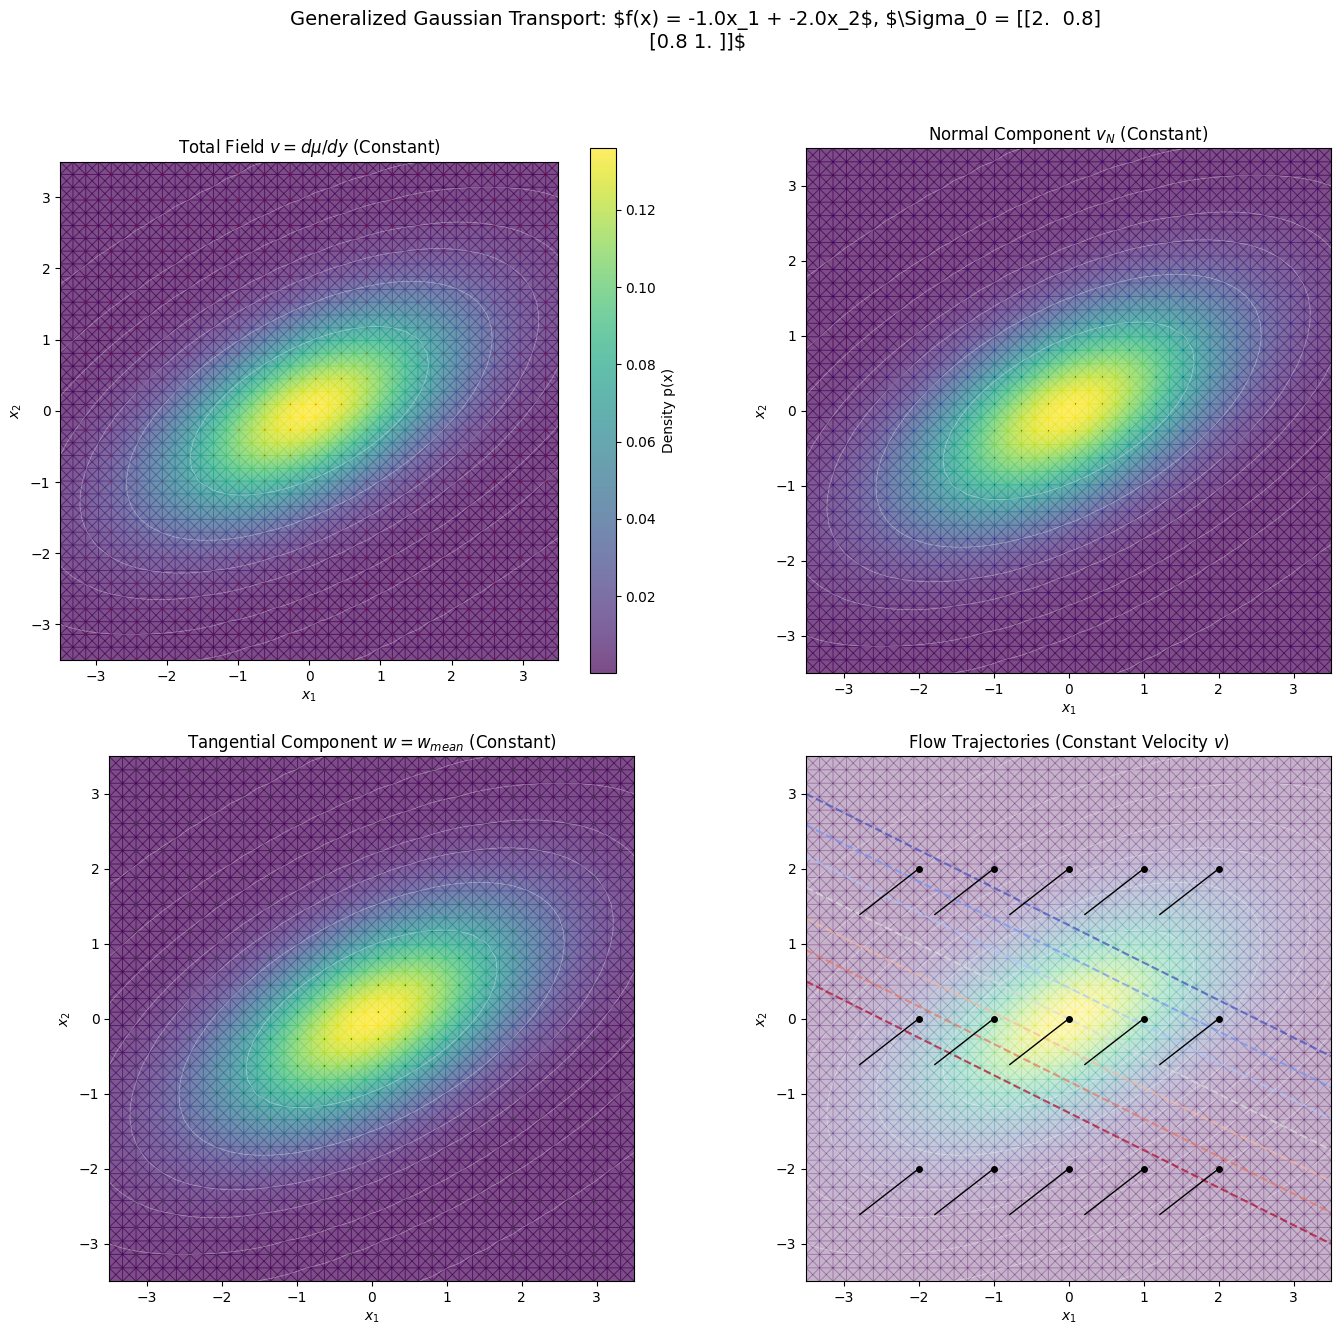

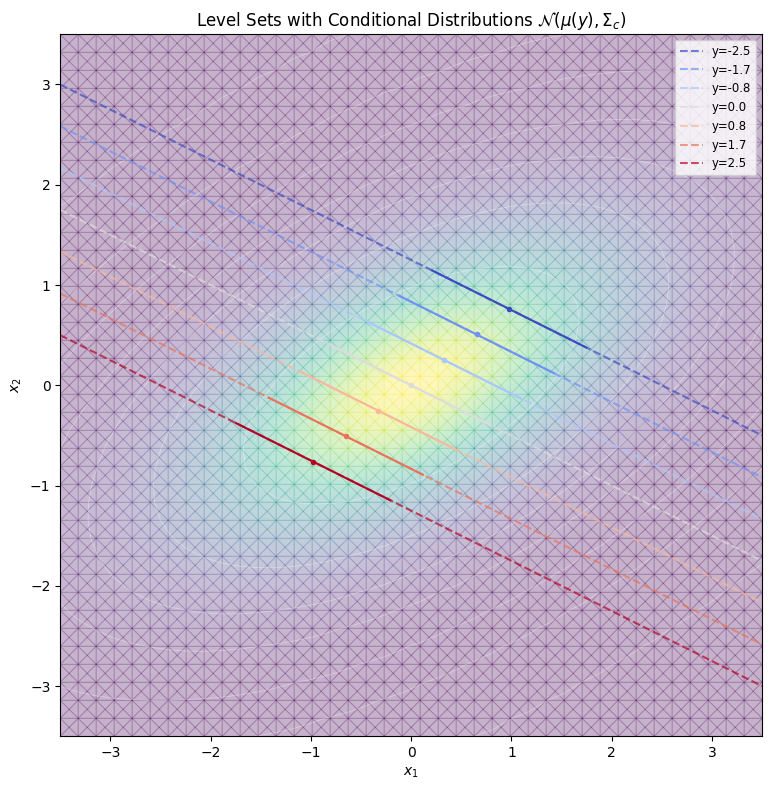

Done.


Calculating density...
Calculating vector field components...
  v_N    = [-0.2 -0.4]
  w=w_mean=[-0.191  0.096]
  v_total= [-0.391 -0.304]
Generating visualizations...


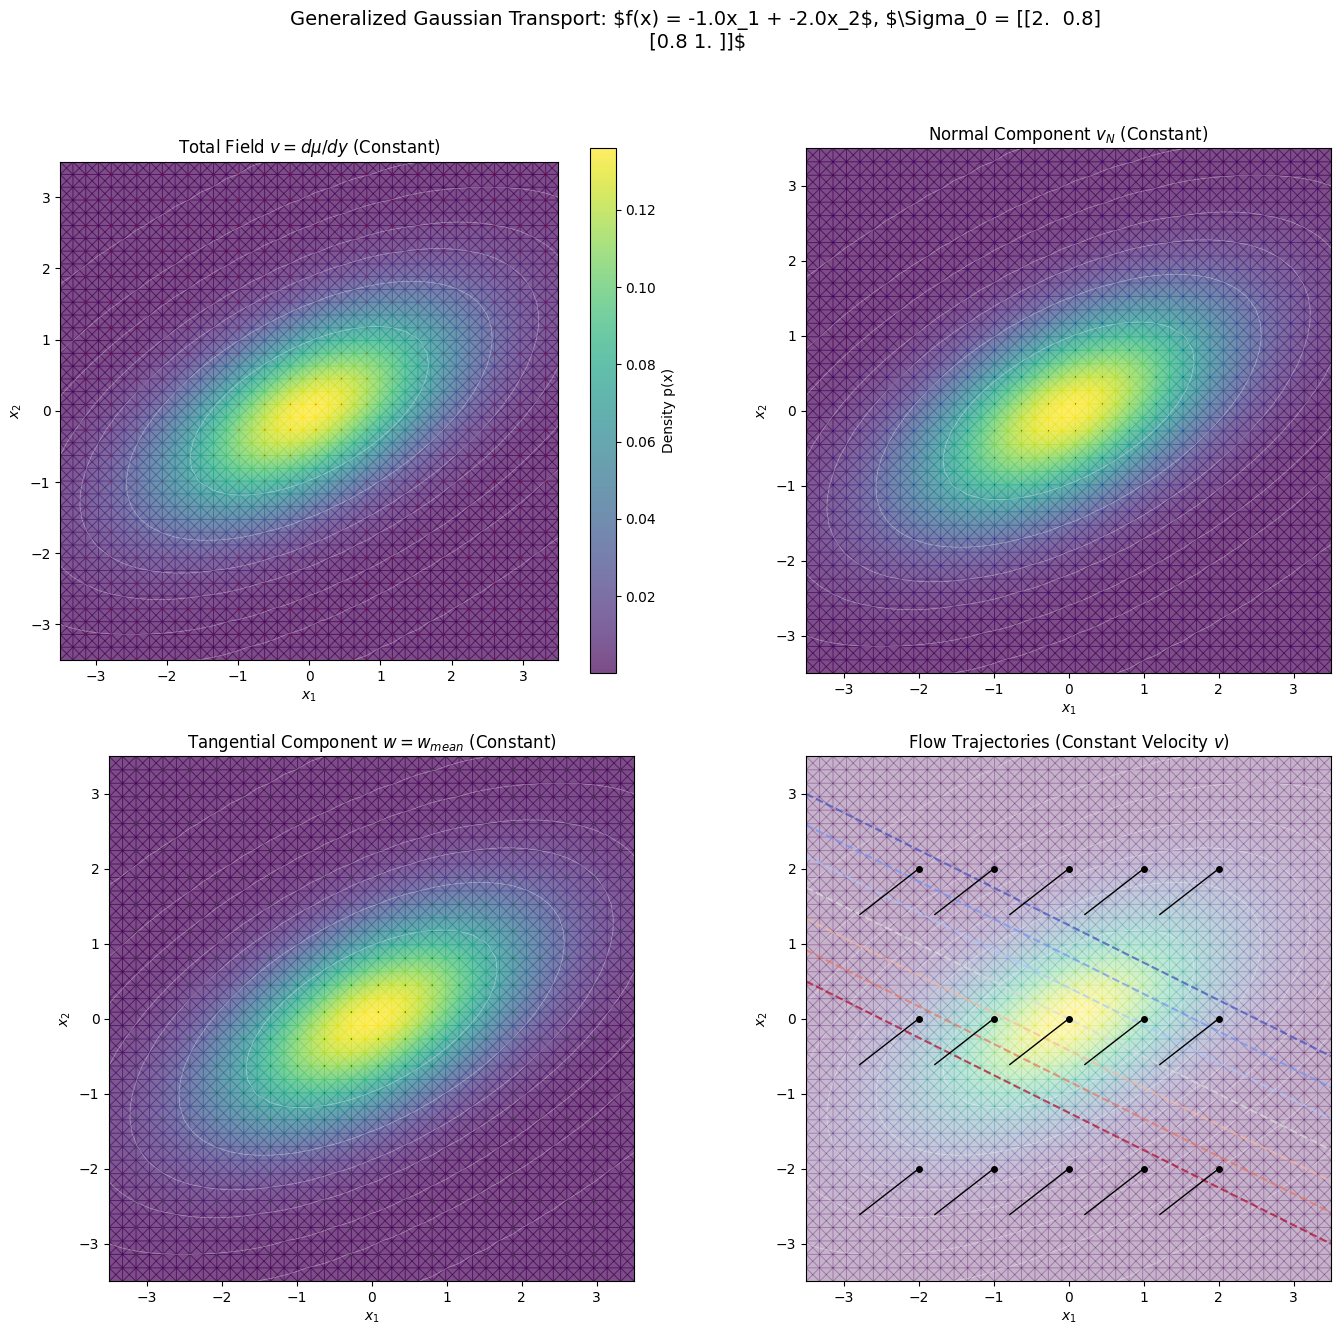

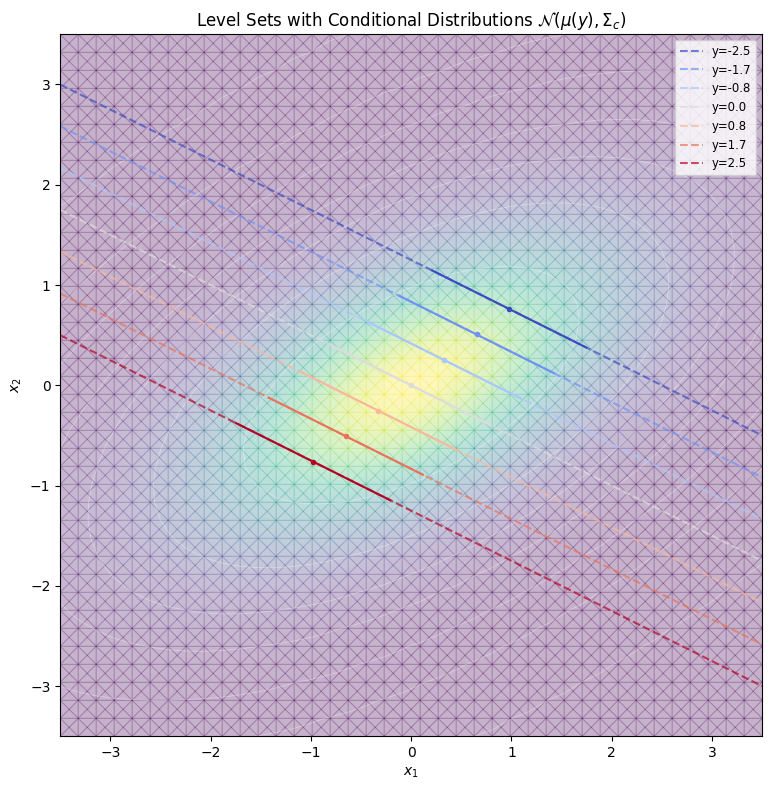

Done.


In [ ]:
# Code from the first refactoring (correct for the generalized problem)
# ... (calculation functions: calculate_density, calculate_vector_field_components,
#      calculate_conditional_params, flow_ode) ...
# ... (visualization functions: plot_vector_field, plot_confidence_ellipse,
#      visualize_results) ...

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.integrate import odeint
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

# ==============================================================================
# Calculation Functions
# ==============================================================================

def calculate_density(X, Y, cov_matrix):
    """
    Calculates the density of a 2D Gaussian distribution N(0, cov_matrix).

    Args:
        X (np.ndarray): Meshgrid X coordinates.
        Y (np.ndarray): Meshgrid Y coordinates.
        cov_matrix (np.ndarray): 2x2 covariance matrix.

    Returns:
        np.ndarray: Density values on the grid.
    """
    pos = np.dstack((X, Y))
    # Ensure covariance matrix is valid for multivariate_normal
    try:
        rv = multivariate_normal([0, 0], cov_matrix, allow_singular=True) # Allow singular for visualization if needed
    except ValueError as e:
        print(f"Error initializing multivariate_normal: {e}")
        # Attempt to compute pseudo-determinant and inverse manually if needed,
        # or return zeros/handle error appropriately. For now, re-raise.
        raise e
    return rv.pdf(pos)

def calculate_vector_field_components(a, b, cov_matrix):
    """
    Calculates the constant vector field components v_N, w, and v_total
    for the generalized Gaussian case (conditioning N(0, Sigma0)).

    Args:
        a (float): Coefficient of x1 in f(x) = ax1 + bx2.
        b (float): Coefficient of x2 in f(x) = ax1 + bx2.
        cov_matrix (np.ndarray): 2x2 covariance matrix Sigma_0.

    Returns:
        tuple: Contains the constant vectors v_N, w (which is w_mean), v_total.
               (np.ndarray, np.ndarray, np.ndarray)
    """
    w_vec = np.array([a, b])
    Sigma0 = np.asarray(cov_matrix)

    if w_vec.shape != (2,) or Sigma0.shape != (2, 2):
        raise ValueError("Check dimensions of w_vec (from a,b) and cov_matrix")

    grad_f_norm_sq = np.dot(w_vec, w_vec)
    if grad_f_norm_sq < 1e-15:
         raise ValueError("Gradient vector norm is zero (a=0, b=0)")

    # Normal component (constant vector)
    v_N = w_vec / grad_f_norm_sq

    # Denominator for dmu/dy
    w_Sigma0_w = w_vec.T @ Sigma0 @ w_vec
    if abs(w_Sigma0_w) < 1e-15:
         # If w is in the null space of Sigma0 (and Sigma0 is PSD), this is valid
         # but means y = w^T x has zero variance. The conditioning is ill-defined
         # or collapses the distribution entirely onto the line w^T x = 0.
         # Let's return zero velocity, but this case needs careful thought.
         print("Warning: w^T Sigma0 w is near zero. Conditioning is ill-defined. Setting velocity to 0.")
         v_total = np.zeros(2)
    else:
        # Total velocity v = dmu/dy (constant vector)
        v_total = (Sigma0 @ w_vec) / w_Sigma0_w

    # Tangential component w = v_total - v_N (constant vector, corresponds to w_mean)
    # Note: w_squeeze is zero for this problem.
    w = v_total - v_N

    return v_N, w, v_total

def calculate_conditional_params(y_val, a, b, cov_matrix, v_total):
    """
    Calculates parameters of the conditional Gaussian N(mu(y), Sigma_c).
    Note: Sigma_c is constant, but mu(y) depends on y.

    Args:
        y_val (float): The value of the level set f(x) = y.
        a (float): Coefficient of x1.
        b (float): Coefficient of x2.
        cov_matrix (np.ndarray): Original covariance Sigma_0.
        v_total (np.ndarray): Precomputed total velocity dmu/dy.

    Returns:
        tuple: mean mu(y), covariance Sigma_c
               (np.ndarray, np.ndarray)
    """
    w_vec = np.array([a, b])
    Sigma0 = np.asarray(cov_matrix)

    # Conditional Mean: mu(y) = (dmu/dy) * y
    mean_y = v_total * y_val

    # Conditional Covariance (constant)
    # Sigma_c = Sigma0 - (Sigma0 @ w @ w.T @ Sigma0) / (w.T @ Sigma0 @ w)
    w_Sigma0_w = w_vec.T @ Sigma0 @ w_vec
    if abs(w_Sigma0_w) < 1e-15:
        # If denominator is zero, the concept breaks down.
        # Sigma_c calculation involves 1/0.
        # This implies the original distribution has no variance in the w direction.
        # Return Sigma0 and raise warning, or handle more gracefully.
        print("Warning: w^T Sigma0 w is near zero. Conditional covariance calculation failed.")
        # Returning Sigma0 is arbitrary, error handling needed.
        Sigma_c = Sigma0 # Placeholder
    else:
        Sigma0_w = Sigma0 @ w_vec
        Sigma_c = Sigma0 - np.outer(Sigma0_w, Sigma0_w) / w_Sigma0_w

    return mean_y, Sigma_c


def flow_ode(state, t, v_total):
    """
    ODE system definition for flow trajectories.
    Since v_total is constant for the generalized Gaussian problem,
    the ODE is trivial: d(state)/dt = v_total.

    Args:
        state (np.ndarray): Current position [x1, x2].
        t (float): Current time (not used directly as v is constant).
        v_total (np.ndarray): The constant total velocity vector.

    Returns:
        np.ndarray: Velocity [dx1/dt, dx2/dt].
    """
    # Check if v_total has the expected shape
    if v_total.shape != (2,):
         raise ValueError(f"v_total has unexpected shape: {v_total.shape}")
    return v_total

# ==============================================================================
# Visualization Functions (Same as before)
# ==============================================================================

def plot_vector_field(ax, X, Y, U, V, title, density=None, cmap='viridis', color='red', scale=15, width=0.003, density_alpha=0.7):
    """ Helper function to plot a vector field with optional density background. """
    cnt = None
    if density is not None:
        # Use pcolormesh for potentially non-uniform density scaling
        cnt = ax.pcolormesh(X, Y, density, cmap=cmap, alpha=density_alpha, shading='gouraud', rasterized=True)
        # Add contours for better shape visibility
        ax.contour(X, Y, density, levels=np.percentile(density[density>1e-9], np.linspace(10, 90, 7)), colors='white', alpha=0.4, linewidths=0.5)

     # Plot vectors skipping every few points for clarity
    step = max(1, X.shape[0] // 20) # Adjust step based on grid size
    X_q, Y_q = X[::step,::step], Y[::step,::step]
    U_q, V_q = U[::step,::step], V[::step,::step]

    # Filter near-zero vectors to avoid clutter, adjust threshold as needed
    mag = np.sqrt(U_q**2 + V_q**2)
    # Use a small absolute threshold + relative threshold
    max_mag = np.nanmax(mag) if np.any(np.isfinite(mag)) else 1.0
    threshold = 1e-5 + 1e-3 * max_mag
    mask = mag > threshold

    # Check if mask is empty or all false
    if np.any(mask):
        ax.quiver(X_q[mask], Y_q[mask], U_q[mask], V_q[mask],
                  scale=scale, width=width, color=color, pivot='mid', scale_units='xy') # Use 'xy' for consistent scaling
    ax.set_title(title)
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlim(X.min(), X.max())
    ax.set_ylim(Y.min(), Y.max())
    return cnt # Return contour/mesh object for colorbar


def plot_confidence_ellipse(ax, mean, cov, n_std=1.0, facecolor='none', **kwargs):
    """
    Plots the confidence ellipse of a 2D Gaussian distribution.
    Handles rank-deficient covariance matrices (like Sigma_c).
    """
    if np.linalg.matrix_rank(cov) < 2 :
         # Rank deficient - ellipse collapses to a line segment or point
        eigenvalues, eigenvectors = np.linalg.eigh(cov)
        major_axis_idx = np.argmax(eigenvalues)
        # Check if max eigenvalue is near zero
        if eigenvalues[major_axis_idx] < 1e-9:
             # Essentially a point
            ax.plot(mean[0], mean[1], marker='o', markersize=2, color=kwargs.get('edgecolor', 'red'))
            return
        else:
            major_axis_vec = eigenvectors[:, major_axis_idx]
            major_axis_len = np.sqrt(eigenvalues[major_axis_idx]) * n_std
            # Endpoints of the line segment
            p1 = mean - major_axis_vec * major_axis_len
            p2 = mean + major_axis_vec * major_axis_len
            ax.plot([p1[0], p2[0]], [p1[1], p2[1]], color=kwargs.get('edgecolor', 'red'), linestyle='-', linewidth=kwargs.get('linewidth', 1.5))
            return # Finished plotting line segment
    else:
        # Full rank ellipse
        # Calculate ellipse parameters using eigenvalues/vectors for robustness
        eigenvalues, eigenvectors = np.linalg.eigh(cov)
        idx = eigenvalues.argsort()[::-1]
        eigenvalues = eigenvalues[idx]
        eigenvectors = eigenvectors[:,idx]

        width = 2 * n_std * np.sqrt(eigenvalues[0])
        height = 2 * n_std * np.sqrt(eigenvalues[1])
        angle = np.degrees(np.arctan2(*eigenvectors[:,0][::-1]))

        ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle,
                          facecolor=facecolor, **kwargs)
        ax.add_patch(ellipse)


def visualize_results(X, Y, density, v_N, w, v_total, a, b, cov_matrix, start_points, y_vals_vis):
    """
    Generates plots visualizing the density, vector field components,
    flow trajectories, and conditional distributions for the generalized Gaussian case.

    Args:
        X, Y (np.ndarray): Meshgrid coordinates.
        density (np.ndarray): Density values on the grid.
        v_N (np.ndarray): Normal velocity vector (constant).
        w (np.ndarray): Tangential velocity vector (constant, w_mean).
        v_total (np.ndarray): Total velocity vector (constant).
        a, b (float): Coefficients for level set function.
        cov_matrix (np.ndarray): Original covariance matrix Sigma_0.
        start_points (list): List of [x1, x2] points to start trajectories.
        y_vals_vis (list): List of y-values for visualizing level sets and conditional distributions.
    """
    fig_main, axes = plt.subplots(2, 2, figsize=(14, 14))
    fig_main.suptitle(f'Generalized Gaussian Transport: $f(x) = {a:.1f}x_1 + {b:.1f}x_2$, $\\Sigma_0 = {np.array2string(cov_matrix, precision=2)}$', fontsize=14)

    # Fill grid with constant velocity components for plotting
    v_N_x_grid = np.full_like(X, v_N[0])
    v_N_y_grid = np.full_like(X, v_N[1])
    w_x_grid = np.full_like(X, w[0])
    w_y_grid = np.full_like(X, w[1])
    v_x_grid = np.full_like(X, v_total[0])
    v_y_grid = np.full_like(X, v_total[1])

    # Determine appropriate scale for quiver plots based on max velocity magnitude
    max_vel_mag = np.max(np.sqrt(v_x_grid**2 + v_y_grid**2))
    if max_vel_mag < 1e-9: max_vel_mag = 1.0 # Avoid division by zero if v=0
    scale_val = 10.0 / max_vel_mag # Adjust scale factor as needed

    # 1. Total Vector field v = dmu/dy with density
    ax = axes[0, 0]
    mesh_obj = plot_vector_field(ax, X, Y, v_x_grid, v_y_grid, 'Total Field $v = d\\mu/dy$ (Constant)',
                      density=density, color='red', scale=scale_val)
    if mesh_obj:
        fig_main.colorbar(mesh_obj, ax=ax, orientation='vertical', label='Density p(x)')

    # 2. Normal component v_N
    ax = axes[0, 1]
    plot_vector_field(ax, X, Y, v_N_x_grid, v_N_y_grid, 'Normal Component $v_N$ (Constant)',
                      density=density, color='blue', scale=scale_val)

    # 3. Tangential component w = w_mean
    ax = axes[1, 0]
    plot_vector_field(ax, X, Y, w_x_grid, w_y_grid, 'Tangential Component $w = w_{mean}$ (Constant)',
                      density=density, color='green', scale=scale_val)

    # 4. Flow trajectories
    ax = axes[1, 1]
    ax.pcolormesh(X, Y, density, cmap='viridis', alpha=0.3, shading='gouraud', rasterized=True)
    ax.contour(X, Y, density, levels=np.percentile(density[density>1e-9], np.linspace(10, 90, 7)), colors='white', alpha=0.4, linewidths=0.5)


    # Draw level sets
    colors = plt.cm.coolwarm(np.linspace(0, 1, len(y_vals_vis)))
    x1_line = np.linspace(X.min(), X.max(), 200)
    for k, y_val in enumerate(y_vals_vis):
         # Ensure b is not zero before calculating x2_vals
         if abs(b) > 1e-9:
              x2_line = (y_val - a * x1_line) / b
              mask = (x2_line >= Y.min()) & (x2_line <= Y.max())
              ax.plot(x1_line[mask], x2_line[mask], '--', color=colors[k], alpha=0.7, label=f'y={y_val:.1f}')
         elif abs(a) > 1e-9: # If b=0, level sets are vertical lines x1=y/a
              if X.min() <= y_val/a <= X.max():
                   ax.axvline(y_val/a, color=colors[k], linestyle='--', alpha=0.7, label=f'y={y_val:.1f}')

    # Draw flow trajectories (straight lines for constant velocity)
    t_span = np.linspace(0, 2.0, 2) # Only need start and end for straight line
    for start in start_points:
        # Ensure start point is valid
        if not (np.isfinite(start[0]) and np.isfinite(start[1])): continue
        try:
            trajectory = odeint(flow_ode, start, t_span, args=(v_total,))
            # Check if trajectory calculation succeeded
            if np.all(np.isfinite(trajectory)):
                 ax.plot(trajectory[:, 0], trajectory[:, 1], 'k-', linewidth=1.0)
                 ax.plot(trajectory[0, 0], trajectory[0, 1], 'ko', markersize=4)
            else:
                 print(f"Warning: Trajectory calculation failed for start point {start}")
        except Exception as e:
             print(f"Error during trajectory calculation for {start}: {e}")


    ax.set_title('Flow Trajectories (Constant Velocity $v$)')
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_xlim(X.min(), X.max())
    ax.set_ylim(Y.min(), Y.max())
    ax.set_aspect('equal', adjustable='box')
    # ax.legend(fontsize='small') # Can get crowded

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap


    # --- Separate Figure for Conditional Distributions ---
    fig_cond, ax_cond = plt.subplots(1, 1, figsize=(8, 8))
    ax_cond.pcolormesh(X, Y, density, cmap='viridis', alpha=0.3, shading='gouraud', rasterized=True)
    ax_cond.contour(X, Y, density, levels=np.percentile(density[density>1e-9], np.linspace(10, 90, 7)), colors='white', alpha=0.4, linewidths=0.5)

    ax_cond.set_title('Level Sets with Conditional Distributions $\mathcal{N}(\\mu(y), \\Sigma_c)$')
    ax_cond.set_xlabel('$x_1$')
    ax_cond.set_ylabel('$x_2$')
    ax_cond.set_xlim(X.min(), X.max())
    ax_cond.set_ylim(Y.min(), Y.max())
    ax_cond.set_aspect('equal', adjustable='box')

    # Calculate Sigma_c once
    try:
        _, Sigma_c_const = calculate_conditional_params(0, a, b, cov_matrix, v_total) # y=0 is arbitrary for Sigma_c
    except Exception as e:
        print(f"Error calculating Sigma_c: {e}. Skipping conditional plot.")
        Sigma_c_const = None

    if Sigma_c_const is not None:
         for k, y_val in enumerate(y_vals_vis):
              color = colors[k]
              # Plot level set line
              if abs(b) > 1e-9:
                   x2_line = (y_val - a * x1_line) / b
                   mask = (x2_line >= Y.min()) & (x2_line <= Y.max())
                   ax_cond.plot(x1_line[mask], x2_line[mask], color=color, linestyle='--', alpha=0.7, label=f'y={y_val:.1f}')
              elif abs(a) > 1e-9:
                   if X.min() <= y_val/a <= X.max():
                        ax_cond.axvline(y_val/a, color=color, linestyle='--', alpha=0.7, label=f'y={y_val:.1f}')

              # Calculate conditional mean for this y
              mean_y = v_total * y_val

              # Check if mean is within plot limits before drawing ellipse
              if X.min() <= mean_y[0] <= X.max() and Y.min() <= mean_y[1] <= Y.max():
                  plot_confidence_ellipse(ax_cond, mean_y, Sigma_c_const, n_std=1.0, edgecolor=color, linewidth=1.5, facecolor='none')
                  ax_cond.plot(mean_y[0], mean_y[1], 'o', color=color, markersize=3) # Mark the mean

    ax_cond.legend(fontsize='small', loc='upper right')
    plt.tight_layout()

    plt.show()


# ==============================================================================
# Main Execution
# ==============================================================================
if __name__ == "__main__":
    # --- Parameters ---
    a = -1.0
    b = -2.0

    # Covariance Matrix Sigma_0 (MUST be symmetric positive semi-definite)
    cov_matrix = [[2.0, 0.8], [0.8, 1.0]]
    # Ensure Sigma0 is valid PSD
    try:
        np.linalg.cholesky(cov_matrix)
    except np.linalg.LinAlgError:
        print("Error: Covariance matrix is not positive definite.")
        # Use identity or exit
        # cov_matrix = [[1.0, 0.0], [0.0, 1.0]]
        exit()


    # --- Grid Setup ---
    grid_range = 3.5
    num_points = 40 # Increase for finer grid
    x_range = np.linspace(-grid_range, grid_range, num_points)
    y_range = np.linspace(-grid_range, grid_range, num_points)
    X, Y = np.meshgrid(x_range, y_range)

    # --- Calculations ---
    print("Calculating density...")
    try:
        density = calculate_density(X, Y, cov_matrix)
        # Normalize density for better visualization contrast if needed
        # density /= np.max(density)
    except Exception as e:
        print(f"Error calculating density: {e}")
        density = np.zeros_like(X) # Fallback

    print("Calculating vector field components...")
    try:
        v_N, w, v_total = calculate_vector_field_components(a, b, cov_matrix)
        print(f"  v_N    = {np.array2string(v_N, precision=3)}")
        print(f"  w=w_mean={np.array2string(w, precision=3)}")
        print(f"  v_total= {np.array2string(v_total, precision=3)}")
    except Exception as e:
        print(f"Error calculating vector field: {e}")
        # Set defaults to prevent crash in visualization
        v_N, w, v_total = np.zeros(2), np.zeros(2), np.zeros(2)


    # --- Visualization Setup ---
    start_points = [[-2, -2], [-1, -2], [0, -2], [1, -2], [2, -2],
                    [-2, 0], [-1, 0], [0, 0], [1, 0], [2, 0],
                    [-2, 2], [-1, 2], [0, 2], [1, 2], [2, 2]]
    # Filter start points slightly inside the domain
    start_points = [p for p in start_points if abs(p[0])<grid_range*0.9 and abs(p[1])<grid_range*0.9]


    y_vals_vis = np.linspace(-2.5, 2.5, 7)

    # --- Generate Plots ---
    print("Generating visualizations...")
    visualize_results(X, Y, density, v_N, w, v_total, a, b, np.array(cov_matrix), start_points, y_vals_vis)

    print("Done.")

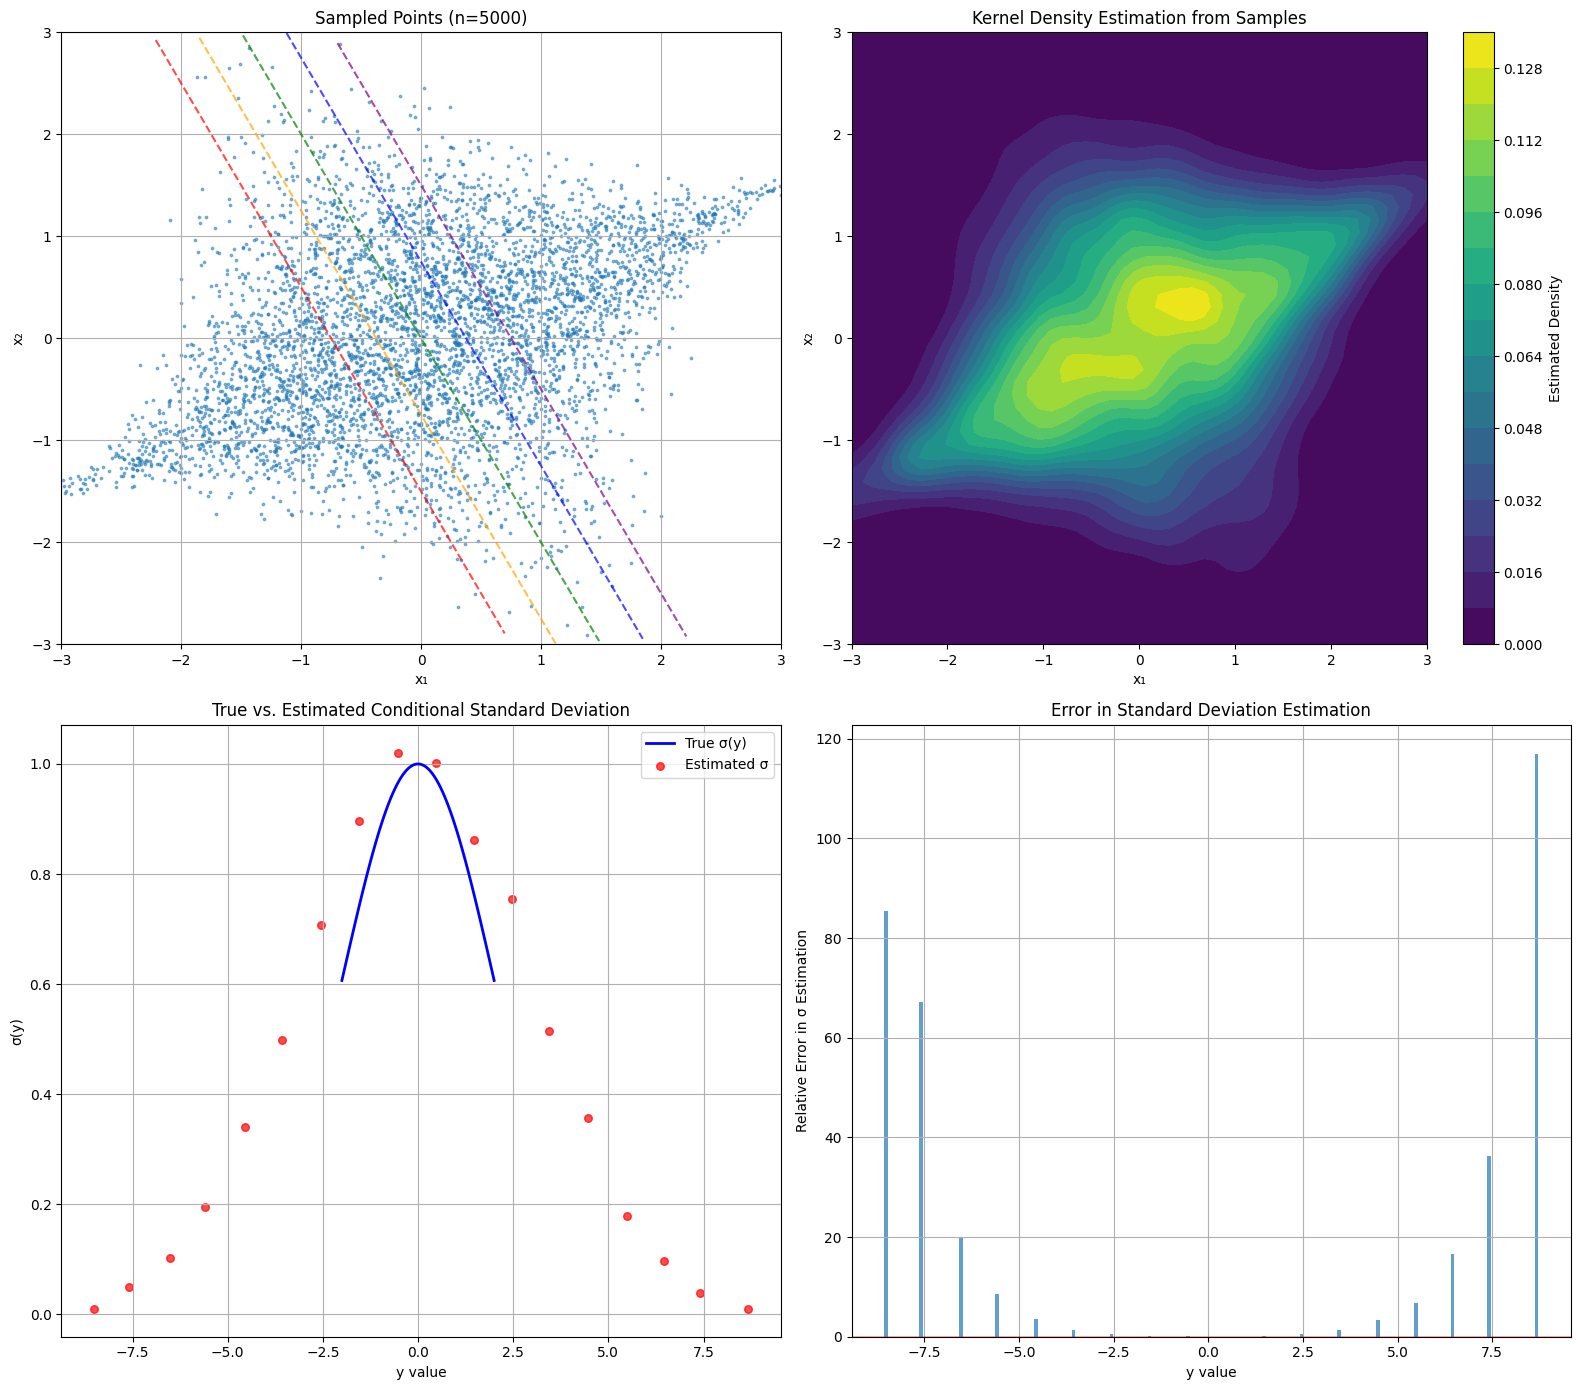

/var/folders/nc/zbqbbkkx08z7v1g3mlf8bdn00000gn/T/ipykernel_45069/941408120.py:238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_counts['scaled_count'] = sample_counts['n_samples'] * scaling_factor


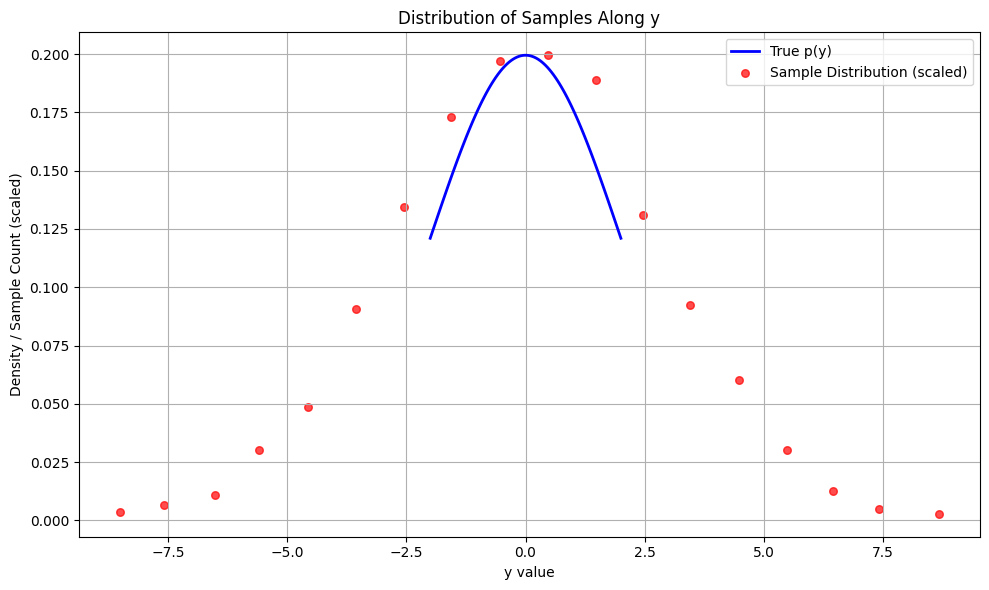

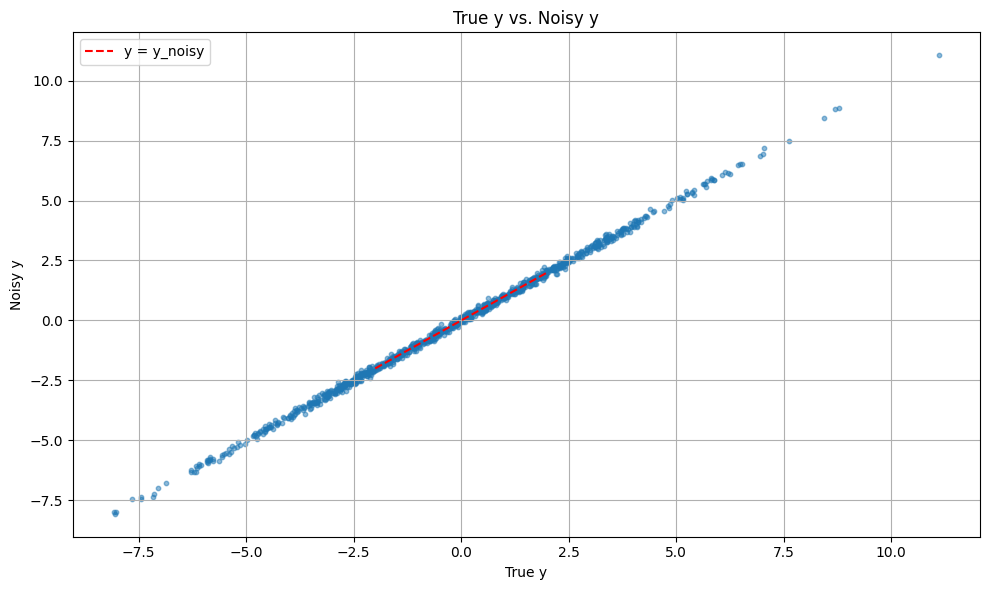

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
from scipy.stats import multivariate_normal
from scipy.optimize import minimize
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KernelDensity
import pandas as pd
import seaborn as sns

# Parameters for the distribution
a, b = 2.0, 1.0  # Coefficients for f(x) = ax₁ + bx₂

def construct_special_distribution(x1, x2, a, b):
    """
    Construct the special distribution where conditional variance changes with y
    p(x) = p(x|y) * p(y) * |∇f|
    """
    y = a*x1 + b*x2
    
    # Marginal distribution p(y) - Gaussian
    p_y = np.exp(-y**2/8) / np.sqrt(8*np.pi)
    
    # Gradient magnitude
    grad_f_norm = np.sqrt(a**2 + b**2)
    
    # Conditional mean (on the level set)
    mean_y = np.array([a*y/(a**2+b**2), b*y/(a**2+b**2)])
    
    # Distance from mean along tangent direction
    tangent = np.array([-b, a]) / grad_f_norm
    x = np.array([x1, x2])
    dist_tangent = np.dot(x - mean_y, tangent)
    
    # Conditional variance that changes with y
    sigma2_y = np.exp(-y**2/4)  # Variance decreases away from y=0
    
    # Conditional distribution
    p_x_given_y = np.exp(-dist_tangent**2/(2*sigma2_y)) / np.sqrt(2*np.pi*sigma2_y)
    
    # Total distribution
    p_x = p_x_given_y * p_y * grad_f_norm
    
    return p_x, p_x_given_y, p_y, sigma2_y

def sample_from_distribution(n_samples, a, b):
    """
    Generate samples from our special distribution.
    Uses rejection sampling method.
    """
    samples = []
    
    # First, sample y from its marginal distribution
    # p(y) ~ N(0, 2√2)
    y_samples = np.random.normal(0, 2*np.sqrt(2), n_samples)
    
    for y in y_samples:
        # For each y, compute mean on level set
        mean_y = np.array([a*y/(a**2+b**2), b*y/(a**2+b**2)])
        
        # Get conditional variance
        sigma2_y = np.exp(-(y/1.5)**2/4)
        sigma_y = np.sqrt(sigma2_y)
        
        # Tangent direction
        grad_f_norm = np.sqrt(a**2 + b**2)
        tangent = np.array([-b, a]) / grad_f_norm
        
        # Sample along tangent direction with variance sigma2_y
        dist_tangent = np.random.normal(0, sigma_y)
        
        # Compute point
        point = mean_y + dist_tangent * tangent
        
        # Add some noise to y-value for realism
        true_y = a*point[0] + b*point[1]
        noise_level = 0.1  # Adjust as needed
        noisy_y = true_y + np.random.normal(0, noise_level)
        
        samples.append((point[0], point[1], true_y, noisy_y))
    
    return np.array(samples)

def estimate_parameters(samples, a, b):
    """
    Given samples (x1, x2), estimate level set value y and conditional std dev sigma
    """
    # Convert to DataFrame for easier manipulation
    df = pd.DataFrame(samples, columns=['x1', 'x2', 'true_y', 'noisy_y'])
    
    # Calculate estimated y for each sample
    df['estimated_y'] = a * df['x1'] + b * df['x2']
    
    # Group samples by similar y values
    # We'll create bins of y-values
    y_min, y_max = df['estimated_y'].min(), df['estimated_y'].max()
    n_bins = 20
    bin_width = (y_max - y_min) / n_bins
    df['y_bin'] = ((df['estimated_y'] - y_min) / bin_width).astype(int)
    
    # Compute conditional std dev for each bin
    # For each y-bin, we find the standard deviation in the tangent direction
    results = []
    
    for bin_id, group in df.groupby('y_bin'):
        if len(group) < 10:  # Skip bins with too few samples
            continue
            
        y_mean = group['estimated_y'].mean()
        
        # Mean point on level set
        mean_y = np.array([a*y_mean/(a**2+b**2), b*y_mean/(a**2+b**2)])
        
        # Tangent direction
        grad_f_norm = np.sqrt(a**2 + b**2)
        tangent = np.array([-b, a]) / grad_f_norm
        
        # Project points onto tangent direction to find variance
        distances = []
        for _, row in group.iterrows():
            point = np.array([row['x1'], row['x2']])
            dist_tangent = np.dot(point - mean_y, tangent)
            distances.append(dist_tangent)
        
        # Compute standard deviation
        sigma_estimated = np.std(distances)
        
        # For comparison, compute the true sigma
        true_sigma = np.sqrt(np.exp(-y_mean**2/4))
        
        results.append({
            'y_bin': bin_id,
            'y_value': y_mean,
            'n_samples': len(group),
            'estimated_sigma': sigma_estimated,
            'true_sigma': true_sigma
        })
    
    return pd.DataFrame(results)

# Generate a large sample
np.random.seed(42)  # For reproducibility
n_samples = 5000
samples = sample_from_distribution(n_samples, a, b)

# Estimate parameters
parameter_estimates = estimate_parameters(samples, a, b)

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# 1. Scatter plot of samples
ax = axes[0, 0]
ax.scatter(samples[:, 0], samples[:, 1], alpha=0.5, s=3)
ax.set_title(f'Sampled Points (n={n_samples})')
ax.set_xlabel('x₁')
ax.set_ylabel('x₂')
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.grid(True)

# Draw some level sets for reference
y_vals = [-1.5, -0.75, 0, 0.75, 1.5]
colors = ['red', 'orange', 'green', 'blue', 'purple']

for y_val, color in zip(y_vals, colors):
    x1_vals = np.linspace(-3, 3, 100)
    x2_vals = (y_val - a*x1_vals) / b
    mask = (x2_vals >= -3) & (x2_vals <= 3)
    ax.plot(x1_vals[mask], x2_vals[mask], '--', color=color, alpha=0.7)

# 2. Density estimation from samples
ax = axes[0, 1]

# Use kernel density estimation
xx, yy = np.meshgrid(np.linspace(-3, 3, 50), np.linspace(-3, 3, 50))
positions = np.vstack([xx.ravel(), yy.ravel()]).T
values = np.vstack([samples[:, 0], samples[:, 1]]).T
kde = KernelDensity(bandwidth=0.2, kernel='gaussian')
kde.fit(values)
density = np.exp(kde.score_samples(positions)).reshape(xx.shape)

# Plot the density
cf = ax.contourf(xx, yy, density, levels=20, cmap='viridis')
plt.colorbar(cf, ax=ax, label='Estimated Density')
ax.set_title('Kernel Density Estimation from Samples')
ax.set_xlabel('x₁')
ax.set_ylabel('x₂')
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)

# 3. Comparison of true vs. estimated sigma
ax = axes[1, 0]

# True sigma function
y_range = np.linspace(-2, 2, 100)
sigma_true = np.sqrt(np.exp(-y_range**2/4))
ax.plot(y_range, sigma_true, 'b-', linewidth=2, label='True σ(y)')

# Estimated sigma values
ax.scatter(parameter_estimates['y_value'], parameter_estimates['estimated_sigma'], 
           color='red', s=30, alpha=0.7, label='Estimated σ')

ax.set_xlabel('y value')
ax.set_ylabel('σ(y)')
ax.set_title('True vs. Estimated Conditional Standard Deviation')
ax.legend()
ax.grid(True)

# 4. Error in sigma estimation
ax = axes[1, 1]
parameter_estimates['sigma_error'] = (parameter_estimates['estimated_sigma'] - 
                                     parameter_estimates['true_sigma']) / parameter_estimates['true_sigma']
                                     
ax.bar(parameter_estimates['y_value'], parameter_estimates['sigma_error'], 
       width=0.1, alpha=0.7)
ax.axhline(y=0, color='r', linestyle='-', alpha=0.3)
ax.set_xlabel('y value')
ax.set_ylabel('Relative Error in σ Estimation')
ax.set_title('Error in Standard Deviation Estimation')
ax.grid(True)

plt.tight_layout()
plt.show()

# Additional analysis - Relationship between y-value and sample density
fig, ax = plt.subplots(figsize=(10, 6))

# Group samples by y-bin and count
sample_counts = parameter_estimates[['y_value', 'n_samples']]

# True density of y
y_dense = np.linspace(-2, 2, 100)
p_y_true = np.exp(-y_dense**2/8) / np.sqrt(8*np.pi)

# Scale sample counts to compare with density
scaling_factor = max(p_y_true) / max(sample_counts['n_samples'])
sample_counts['scaled_count'] = sample_counts['n_samples'] * scaling_factor

# Plot
ax.plot(y_dense, p_y_true, 'b-', linewidth=2, label='True p(y)')
ax.scatter(sample_counts['y_value'], sample_counts['scaled_count'], 
           color='red', s=30, alpha=0.7, label='Sample Distribution (scaled)')

ax.set_xlabel('y value')
ax.set_ylabel('Density / Sample Count (scaled)')
ax.set_title('Distribution of Samples Along y')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()

# Analyze the noisy y values vs true y values
fig, ax = plt.subplots(figsize=(10, 6))

# Get a subset of samples for clarity
subset_indices = np.random.choice(len(samples), 1000, replace=False)
subset = samples[subset_indices]

ax.scatter(subset[:, 2], subset[:, 3], alpha=0.5, s=10)
ax.plot([-2, 2], [-2, 2], 'r--', label='y = y_noisy')
ax.set_xlabel('True y')
ax.set_ylabel('Noisy y')
ax.set_title('True y vs. Noisy y')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()

True coefficients: a=2.0, b=1.0
Estimated coefficients: a=1.999, b=1.002


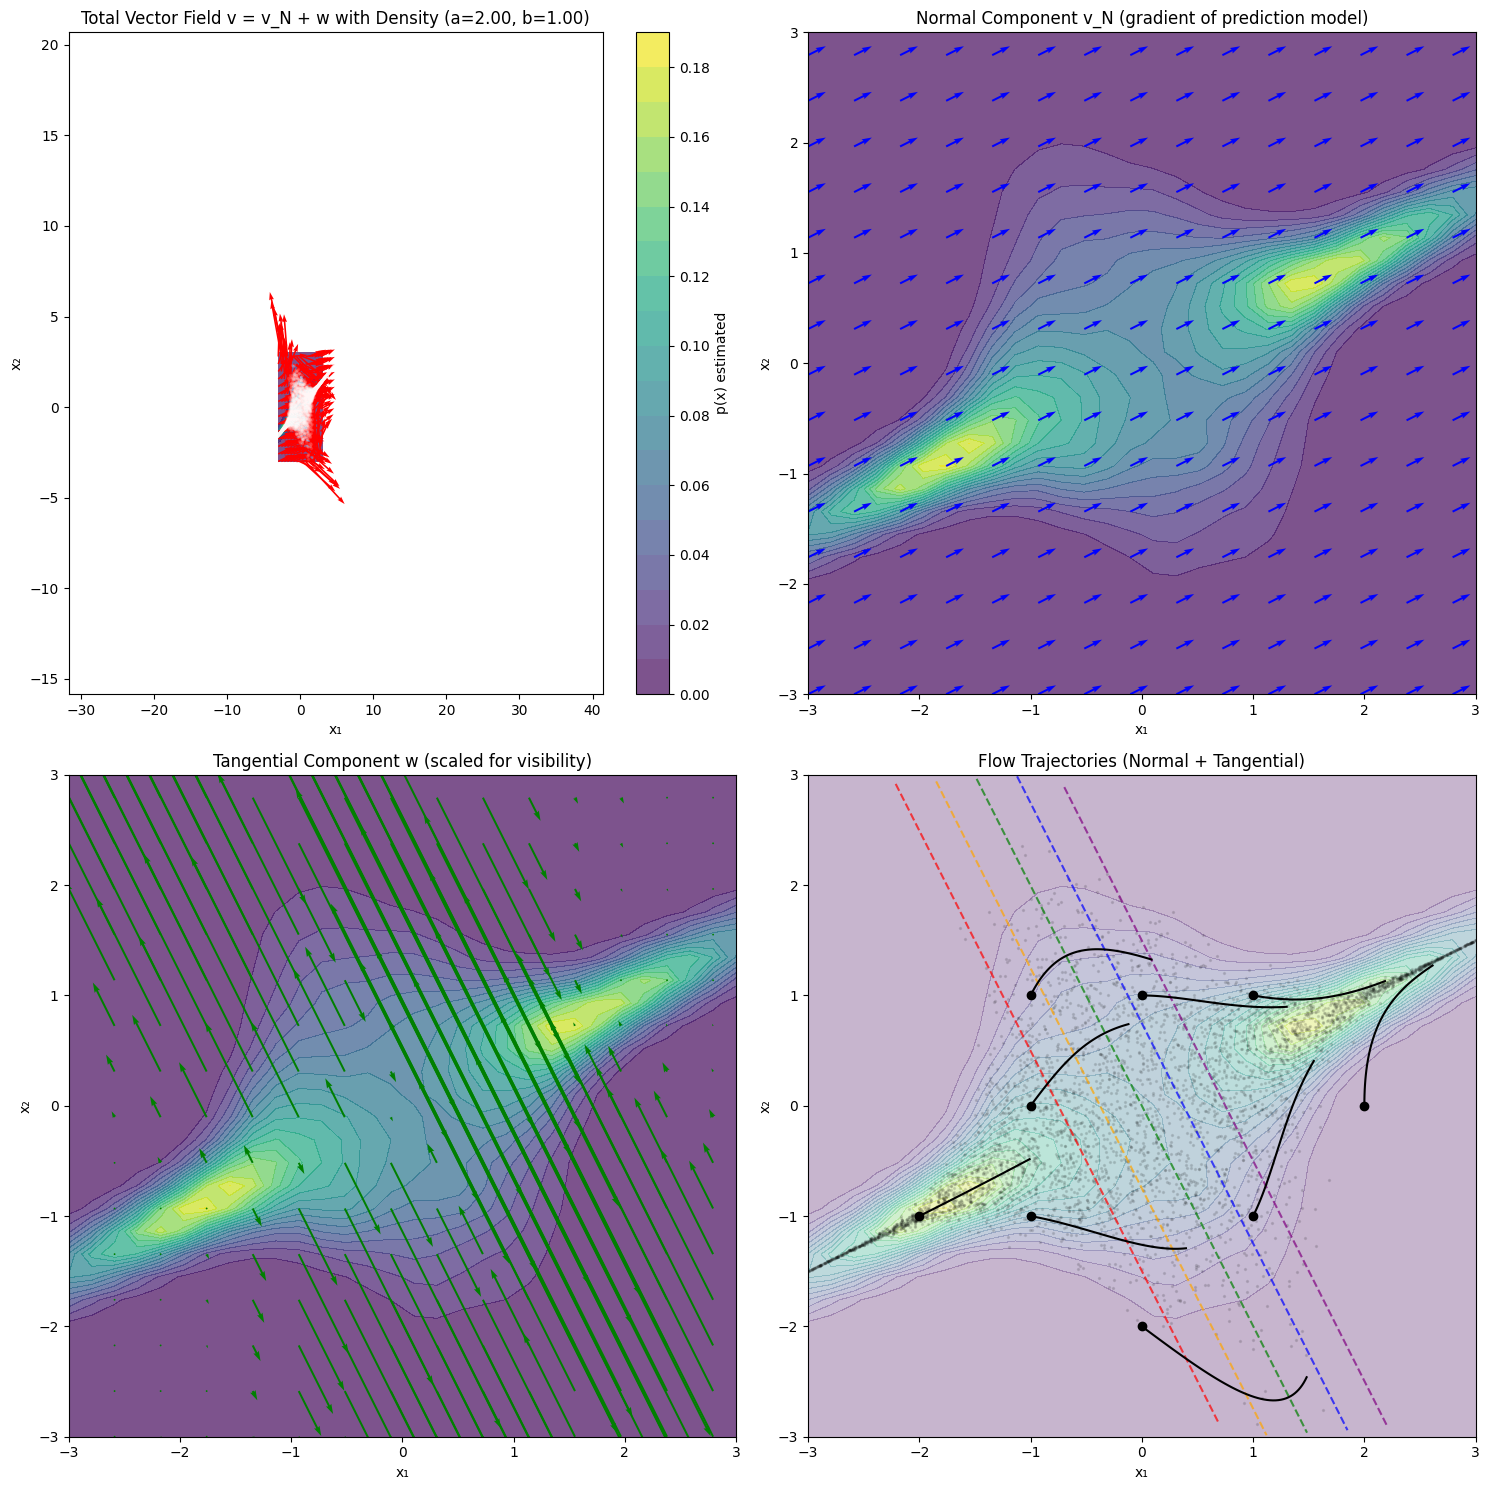

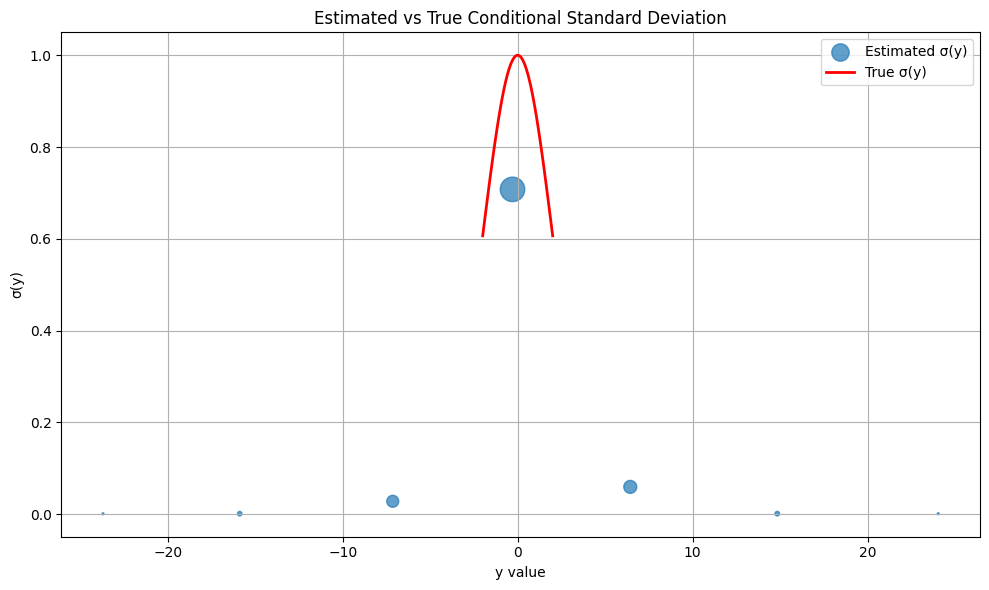

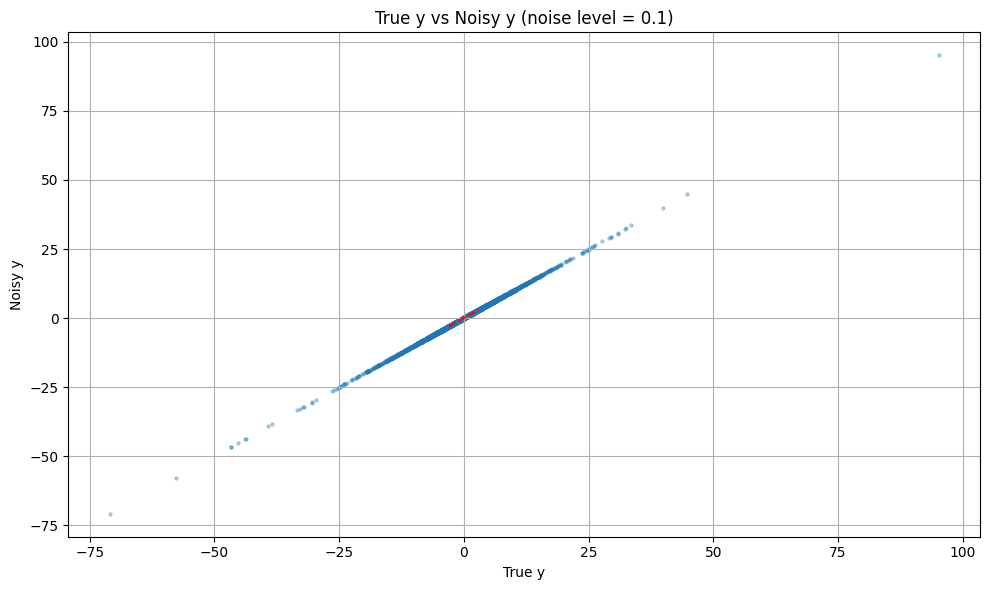

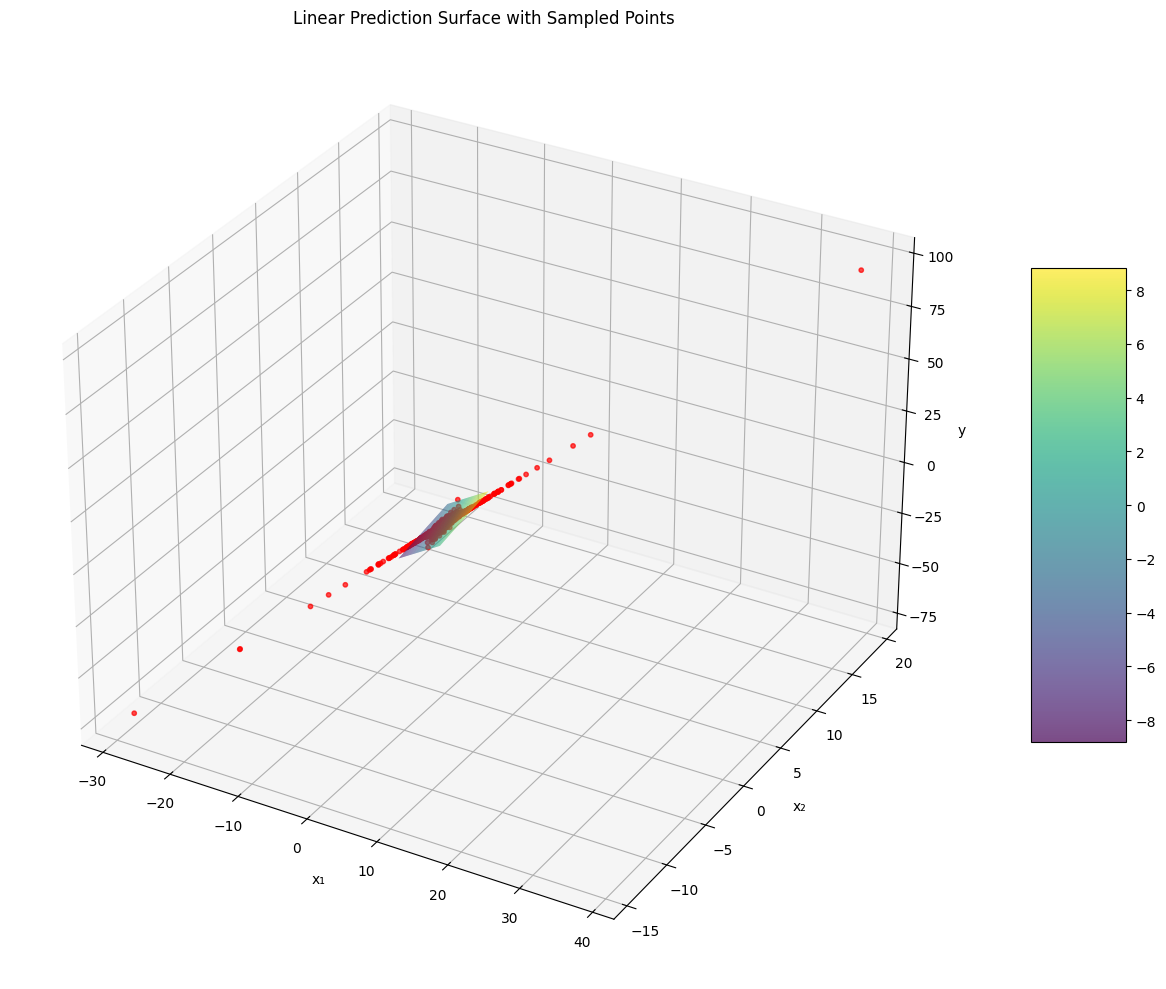

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
from scipy.integrate import odeint
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KernelDensity
import pandas as pd
import seaborn as sns

# Parameters for the distribution
a, b = 2.0, 1.0  # True coefficients for f(x) = ax₁ + bx₂

def construct_special_distribution(x1, x2, a, b):
    """
    Construct the special distribution where conditional variance changes with y
    p(x) = p(x|y) * p(y) * |∇f|
    """
    y = a*x1 + b*x2
    
    # Marginal distribution p(y) - Gaussian
    p_y = np.exp(-y**2/8) / np.sqrt(8*np.pi)
    
    # Gradient magnitude
    grad_f_norm = np.sqrt(a**2 + b**2)
    
    # Conditional mean (on the level set)
    mean_y = np.array([a*y/(a**2+b**2), b*y/(a**2+b**2)])
    
    # Distance from mean along tangent direction
    tangent = np.array([-b, a]) / grad_f_norm
    x = np.array([x1, x2])
    dist_tangent = np.dot(x - mean_y, tangent)
    
    # Conditional variance that changes with y
    sigma2_y = np.exp(-y**2/4)  # Variance decreases away from y=0
    
    # Conditional distribution
    p_x_given_y = np.exp(-dist_tangent**2/(2*sigma2_y)) / np.sqrt(2*np.pi*sigma2_y)
    
    # Total distribution
    p_x = p_x_given_y * p_y * grad_f_norm
    
    return p_x, p_x_given_y, p_y, sigma2_y

def sample_from_distribution(n_samples, a=2, b=1, noise_level=0.1):
    """
    Generate samples from our special distribution with noisy y values.
    """
    samples = []
    
    # First, sample y from its marginal distribution
    # Using Student's t-distribution with 3 degrees of freedom for fatter tails
    # Scale parameter chosen to roughly match the spread of the original normal distribution
    df = 3  # degrees of freedom
    scale = 4  # scale parameter
    y_samples = np.random.standard_t(df, n_samples) * scale
    
    for y in y_samples:
        # For each y, compute mean on level set
        mean_y = np.array([a*y/(a**2+b**2), b*y/(a**2+b**2)])
        
        # Get conditional variance
        sigma2_y = np.exp(-y**2/4)
        sigma_y = np.sqrt(sigma2_y)
        
        # Tangent direction
        grad_f_norm = np.sqrt(a**2 + b**2)
        tangent = np.array([-b, a]) / grad_f_norm
        
        # Sample along tangent direction with variance sigma2_y
        dist_tangent = np.random.normal(0, sigma_y)
        
        # Compute point
        point = mean_y + dist_tangent * tangent
        
        # Add noise to y-value
        true_y = a*point[0] + b*point[1]
        noisy_y = true_y + np.random.normal(0, noise_level)
        
        samples.append((point[0], point[1], true_y, noisy_y))
    
    return np.array(samples)

def estimate_model_and_variance(samples):
    """
    Estimate the linear model and conditional variance from samples.
    Returns:
    - model: Linear regression model
    - y_bins: Binned y values for variance estimation
    - variance_estimates: Estimated variance per bin
    """
    # Extract features and targets
    X = samples[:, :2]
    y_noisy = samples[:, 3]
    
    # Fit linear regression to get a, b coefficients
    model = LinearRegression()
    model.fit(X, y_noisy)
    
    # Get estimated y values
    y_pred = model.predict(X)
    
    # Bin the data by predicted y
    df = pd.DataFrame({
        'x1': samples[:, 0],
        'x2': samples[:, 1],
        'y_pred': y_pred,
        'y_noisy': y_noisy
    })
    
    y_min, y_max = df['y_pred'].min(), df['y_pred'].max()
    n_bins = 20
    bin_width = (y_max - y_min) / n_bins
    df['y_bin'] = ((df['y_pred'] - y_min) / bin_width).astype(int)
    
    # Compute residuals and variance per bin
    variance_estimates = []
    y_bins = []
    
    # Get estimated normal direction
    a_est, b_est = model.coef_
    grad_norm = np.sqrt(a_est**2 + b_est**2)
    normal = np.array([a_est, b_est]) / grad_norm
    tangent = np.array([-b_est, a_est]) / grad_norm
    
    for bin_id, group in df.groupby('y_bin'):
        if len(group) < 10:  # Skip bins with too few samples
            continue
            
        y_mean = group['y_pred'].mean()
        
        # Project points onto tangent to find variance along tangent
        mean_y = np.array([a_est*y_mean/(a_est**2+b_est**2), b_est*y_mean/(a_est**2+b_est**2)])
        
        distances = []
        for _, row in group.iterrows():
            point = np.array([row['x1'], row['x2']])
            dist_tangent = np.dot(point - mean_y, tangent)
            distances.append(dist_tangent)
        
        sigma_est = np.std(distances)
        
        variance_estimates.append({
            'y_bin': bin_id,
            'y_value': y_mean,
            'sigma': sigma_est,
            'n_samples': len(group)
        })
    
    return model, pd.DataFrame(variance_estimates)

def compute_flow_components(model, variance_df, X, Y):
    """
    Compute normal and tangential flow components based on estimated model.
    """
    a_est, b_est = model.coef_
    grad_norm_sq = a_est**2 + b_est**2
    
    # Normal component (constant)
    v_N_x = np.full_like(X, a_est / grad_norm_sq)
    v_N_y = np.full_like(Y, b_est / grad_norm_sq)
    
    # For tangential component, we need to estimate variance at each point
    w_x = np.zeros_like(X)
    w_y = np.zeros_like(Y)
    
    # Create function for estimating variance at any y
    y_values = variance_df['y_value'].values
    sigma_values = variance_df['sigma'].values
    
    # Check if we have enough data points for interpolation
    if len(y_values) <= 1:
        print("Warning: Not enough variance data points for interpolation")
        # Use default function for sigma based on true formula as fallback
        def sigma2_func(y):
            return np.exp(-y**2/4)
    else:
        # Sort data points
        sort_idx = np.argsort(y_values)
        y_values = y_values[sort_idx]
        sigma_values = sigma_values[sort_idx]
        
        # Create function to estimate sigma^2 at any y value
        if len(y_values) > 3:
            from scipy.interpolate import interp1d
            sigma_interp = interp1d(y_values, sigma_values**2, 
                                   bounds_error=False, fill_value=(sigma_values[0]**2, sigma_values[-1]**2))
            def sigma2_func(y):
                return sigma_interp(y)
        else:
            # Not enough points for good interpolation, use simple function
            def sigma2_func(y):
                return np.mean(sigma_values**2) * np.exp(-y**2/8)
    
    # Calculate tangential component for each point
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            x1, x2 = X[i,j], Y[i,j]
            
            # Estimated y at this point
            y_est = a_est * x1 + b_est * x2
            
            # Get estimated variance at this y using our function
            sigma2_y = sigma2_func(y_est)
            
            # Use formula for d_sigma2_dy (approximation)
            d_sigma2_dy = -y_est/2 * np.exp(-y_est**2/4)
            
            # Tangent direction
            grad_norm = np.sqrt(a_est**2 + b_est**2)
            tangent = np.array([-b_est, a_est]) / grad_norm
            
            # Mean position on level set
            mean_y = np.array([a_est*y_est/(a_est**2+b_est**2), b_est*y_est/(a_est**2+b_est**2)])
            
            # Distance from mean along tangent
            point = np.array([x1, x2])
            dist_tangent = np.dot(point - mean_y, tangent)
            
            # Convert to scalar if needed
            if isinstance(sigma2_y, np.ndarray):
                sigma2_y = float(sigma2_y)
                
            if sigma2_y > 0:
                w = (d_sigma2_dy / (2*sigma2_y)) * dist_tangent * tangent
                w_x[i,j] = w[0]
                w_y[i,j] = w[1]
    
    return v_N_x, v_N_y, w_x, w_y

def compute_density_from_samples(samples, xx, yy):
    """
    Estimate density from samples using kernel density estimation.
    """
    X_points = samples[:, :2]
    
    # Use kernel density estimation
    kde = KernelDensity(bandwidth=0.2, kernel='gaussian')
    kde.fit(X_points)
    
    # Reshape grid for KDE
    positions = np.vstack([xx.ravel(), yy.ravel()]).T
    density = np.exp(kde.score_samples(positions)).reshape(xx.shape)
    
    return density

# Generate samples
np.random.seed(42)  # For reproducibility
n_samples = 5000
noise_level = 0.1
samples = sample_from_distribution(n_samples, a, b, noise_level)

# Estimate model and variance
model, variance_df = estimate_model_and_variance(samples)
a_est, b_est = model.coef_
print(f"True coefficients: a={a}, b={b}")
print(f"Estimated coefficients: a={a_est:.3f}, b={b_est:.3f}")

# Create grid for visualization
x_range = np.linspace(-3, 3, 30)
y_range = np.linspace(-3, 3, 30)
X, Y = np.meshgrid(x_range, y_range)

# Compute density from samples
density = compute_density_from_samples(samples, X, Y)

# Compute flow components
v_N_x, v_N_y, w_x, w_y = compute_flow_components(model, variance_df, X, Y)

# Combine components
v_x = v_N_x + w_x
v_y = v_N_y + w_y

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 15))

# 1. Vector field with density
ax = axes[0, 0]
cs = ax.contourf(X, Y, density, levels=20, cmap='viridis', alpha=0.7)
ax.quiver(X[::2,::2], Y[::2,::2], v_x[::2,::2], v_y[::2,::2], 
          scale=15, width=0.003, color='red')
ax.scatter(samples[:, 0], samples[:, 1], s=2, alpha=0.1, color='white')
ax.set_title(f'Total Vector Field v = v_N + w with Density (a={a_est:.2f}, b={b_est:.2f})')
ax.set_xlabel('x₁')
ax.set_ylabel('x₂')
plt.colorbar(cs, ax=ax, label='p(x) estimated')

# 2. Normal component
ax = axes[0, 1]
ax.contourf(X, Y, density, levels=20, cmap='viridis', alpha=0.7)
ax.quiver(X[::2,::2], Y[::2,::2], v_N_x[::2,::2], v_N_y[::2,::2], 
          scale=15, width=0.003, color='blue')
ax.set_title('Normal Component v_N (gradient of prediction model)')
ax.set_xlabel('x₁')
ax.set_ylabel('x₂')

# 3. Tangential component
ax = axes[1, 0]
ax.contourf(X, Y, density, levels=20, cmap='viridis', alpha=0.7)
# Scale up tangential component for visibility
scale_factor = 5  # Adjust for visibility
ax.quiver(X[::2,::2], Y[::2,::2], w_x[::2,::2]*scale_factor, w_y[::2,::2]*scale_factor, 
          scale=5, width=0.003, color='green')
ax.set_title('Tangential Component w (scaled for visibility)')
ax.set_xlabel('x₁')
ax.set_ylabel('x₂')

# 4. Flow trajectories
ax = axes[1, 1]
ax.contourf(X, Y, density, levels=20, cmap='viridis', alpha=0.3)
ax.scatter(samples[:, 0], samples[:, 1], s=2, alpha=0.1, color='black')

# Draw level sets from estimated model
y_vals = [-1.5, -0.75, 0, 0.75, 1.5]
colors = ['red', 'orange', 'green', 'blue', 'purple']

for y_val, color in zip(y_vals, colors):
    x1_vals = np.linspace(-3, 3, 100)
    x2_vals = (y_val - a_est*x1_vals) / b_est
    mask = (x2_vals >= -3) & (x2_vals <= 3)
    ax.plot(x1_vals[mask], x2_vals[mask], '--', color=color, alpha=0.7)

# Define ODE for flow using estimated coefficients
def flow_ode(state, t):
    x1, x2 = state
    
    # Get y value from model
    y_est = a_est * x1 + b_est * x2
    
    # Normal component
    grad_norm_sq = a_est**2 + b_est**2
    v_N = np.array([a_est, b_est]) / grad_norm_sq
    
    # Tangential component (simplified for trajectories)
    # Use true formula for variance as an approximation
    sigma2_y = np.exp(-y_est**2/4)
    d_sigma2_dy = -y_est/2 * np.exp(-y_est**2/4)
    
    grad_norm = np.sqrt(a_est**2 + b_est**2)
    tangent = np.array([-b_est, a_est]) / grad_norm
    
    # Mean position on level set
    mean_y = np.array([a_est*y_est/(a_est**2+b_est**2), b_est*y_est/(a_est**2+b_est**2)])
    
    # Distance from mean along tangent
    point = np.array([x1, x2])
    dist_tangent = np.dot(point - mean_y, tangent)
    
    # Tangential component
    w = (d_sigma2_dy / (2*sigma2_y)) * dist_tangent * tangent
    
    # Total velocity
    v = v_N + w
    return v

# Draw flow trajectories
start_points = [[-2, -1], [-1, -1], [0, -2], [1, -1], [2, 0], 
                [1, 1], [0, 1], [-1, 1], [-1, 0]]

for start in start_points:
    t_span = np.linspace(0, 2.5, 50)
    trajectory = odeint(flow_ode, start, t_span)
    
    ax.plot(trajectory[:, 0], trajectory[:, 1], 'k-', linewidth=1.5)
    ax.plot(trajectory[0, 0], trajectory[0, 1], 'ko', markersize=6)

ax.set_title('Flow Trajectories (Normal + Tangential)')
ax.set_xlabel('x₁')
ax.set_ylabel('x₂')
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)

plt.tight_layout()
plt.show()

# Visualize estimated conditional variance
fig, ax = plt.subplots(figsize=(10, 6))

# True variance function
y_range = np.linspace(-2, 2, 100)
sigma2_true = np.exp(-y_range**2/4)

# Plot estimated variance
ax.scatter(variance_df['y_value'], variance_df['sigma'], 
          s=variance_df['n_samples']/10, alpha=0.7, label='Estimated σ(y)')

# Plot true variance
ax.plot(y_range, np.sqrt(sigma2_true), 'r-', linewidth=2, label='True σ(y)')

ax.set_xlabel('y value')
ax.set_ylabel('σ(y)')
ax.set_title('Estimated vs True Conditional Standard Deviation')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()

# Visualize the noisy data and model fit
fig, ax = plt.subplots(figsize=(10, 6))

# Scatter plot of data points with true y vs noisy y
ax.scatter(samples[:, 2], samples[:, 3], alpha=0.3, s=5)
ax.plot([-3, 3], [-3, 3], 'r--')

ax.set_xlabel('True y')
ax.set_ylabel('Noisy y')
ax.set_title(f'True y vs Noisy y (noise level = {noise_level})')
ax.grid(True)

plt.tight_layout()
plt.show()

# Visualize the vector fields in 3D
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')

# Create a more detailed grid for 3D
x_fine = np.linspace(-3, 3, 50)
y_fine = np.linspace(-3, 3, 50)
X_fine, Y_fine = np.meshgrid(x_fine, y_fine)

# Compute predicted y values
Z = a_est * X_fine + b_est * Y_fine

# Plot the surface
surf = ax.plot_surface(X_fine, Y_fine, Z, cmap='viridis', alpha=0.7)

# Sample some points to plot
idx = np.random.choice(len(samples), 500, replace=False)
sampled_points = samples[idx]

# Plot the sampled points
ax.scatter(sampled_points[:, 0], sampled_points[:, 1], sampled_points[:, 3], 
          c='red', s=10, alpha=0.7)

# Add colorbar
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

ax.set_xlabel('x₁')
ax.set_ylabel('x₂')
ax.set_zlabel('y')
ax.set_title('Linear Prediction Surface with Sampled Points')

plt.tight_layout()
plt.show()

In [ ]:

# Draw flow trajectories
start_points = [[-2, -1], [-1, -1], [0, -2], [1, -1], [2, 0], 
                [1, 1], [0, 1], [-1, 1], [-1, 0]]

# start_points = [[-1/b-b/5*i*noise, -1/a+a/5*i*noise] for i,noise in zip(range(-3,4), np.random.random(7))]

for start in start_points:
    t_span = np.linspace(0, 2.5, 50)
    t_span = torch.tensor(t_span, dtype=torch.float32)
    start = torch.tensor(start, dtype=torch.float32)
    
    trajectory = odeint(flow_model, start, t_span)
    
    ax.plot(trajectory[:, 0], trajectory[:, 1], 'k-', linewidth=1.5)
    ax.plot(trajectory[0, 0], trajectory[0, 1], 'ko', markersize=6)

ax.set_title('Flow Trajectories (Normal + Tangential)')
ax.set_xlabel('x₁')
ax.set_ylabel('x₂')
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)

plt.tight_layout()
plt.show()

TypeError: expected Tensor as element 0 in argument 0, but got numpy.ndarray

In [259]:
import torch
from tqdm import tqdm
import time # For example timing

# --- Helper Functions ---

def default_x_dist_func(x1_batch, x2_batch):
    """
    Default L2 distance calculator for x samples.
    Assumes x1_batch is [1, dim_x] or [batch_dim1, dim_x]
    and x2_batch is [N, dim_x] or [batch_dim2, dim_x].
    Returns pairwise distances, shape [batch_dim1, batch_dim2].
    """
    # Ensure inputs are at least 2D and float for cdist
    if x1_batch.ndim == 1:
        x1_batch = x1_batch.unsqueeze(0)
    if x2_batch.ndim == 1:
        x2_batch = x2_batch.unsqueeze(0)

    return torch.cdist(x1_batch.float(), x2_batch.float(), p=2.0)

# --- Core Logic Functions ---

def generate_rated_samples(
    sampler_func,
    rating_func,
    N_total_samples,
    batch_size=32,
    device="cpu",
    verbose=True
):
    """
    Generates N samples using sampler_func and calculates their ratings using rating_func.

    Args:
        sampler_func (callable): Function that takes (n_to_sample, device) and
                                 returns a batch of x samples (PyTorch tensor [n, dim_x]).
        rating_func (callable): Function that takes a batch of x samples (PyTorch tensor)
                                and returns a 1D tensor of ratings y (shape [n]).
        N_total_samples (int): Total number of samples to generate.
        batch_size (int, optional): Batch size for generation. Defaults to 32.
        device (str, optional): PyTorch device. Defaults to "cpu".
        verbose (bool, optional): Print progress. Defaults to True.

    Returns:
        Tuple[torch.Tensor, torch.Tensor]:
            all_x (Tensor [N_total_samples, dim_x]): All generated x samples on CPU.
            all_y (Tensor [N_total_samples]): All corresponding y ratings on CPU.
    """
    if verbose:
        print(f"Generating and rating {N_total_samples} samples on device '{device}'...")

    all_x_list = []
    all_y_list = []

    for i in tqdm(range(0, N_total_samples, batch_size),
                  desc="Sampling & Rating", disable=not verbose):
        current_batch_size = min(batch_size, N_total_samples - i)
        if current_batch_size <= 0:
            break

        x_batch = sampler_func(current_batch_size, device)
        print(x_batch.shape)
        y_batch = rating_func(x_batch)

        all_x_list.append(x_batch.cpu())
        all_y_list.append(y_batch.cpu())

    all_x = torch.cat(all_x_list, dim=0)
    all_y = torch.cat(all_y_list, dim=0)

    if verbose:
        print(f"Generated {all_x.size(0)} x samples and {all_y.size(0)} y ratings.")
    return all_x, all_y


@torch.no_grad()
def find_simple_optimal_pairs(
    all_x,
    all_y,
    x_dist_func=default_x_dist_func,
    device="cpu",
    verbose=True
):
    """
    For each sample, finds one pair with a higher y score and one pair with a
    lower y score that minimize the cost: (distance in x space) / abs(distance in y space).

    Args:
        all_x (torch.Tensor [N, dim_x]): All x samples.
        all_y (torch.Tensor [N]): All y ratings.
        x_dist_func (callable, optional): Function to compute distance between x samples.
                                          Defaults to default_x_dist_func (L2).
        device (str, optional): PyTorch device for calculations. Defaults to "cpu".
        verbose (bool, optional): Print progress. Defaults to True.

    Returns:
        List[Dict]: A list of dictionaries, one for each source sample. Each dict contains:
            "source_idx": int,
            "up_match_idx": Optional[int], "up_cost": Optional[float], "up_delta_y": Optional[float],
            "down_match_idx": Optional[int], "down_cost": Optional[float], "down_delta_y": Optional[float]
    """
    N = all_x.size(0)
    if N == 0:
        return []

    if verbose:
        print(f"Finding optimal pairs for {N} samples on device '{device}'...")

    # Move data to the target device for potentially faster computations
    all_x_dev = all_x.to(device)
    all_y_dev = all_y.to(device)

    results = []

    # This loop can be slow for large N (O(N^2)).
    # For very large N, consider batched distance calculations or optimizations
    # like sorting by y and using a search window as in the more complex version.
    for i in tqdm(range(N), desc="Finding Pairs", disable=not verbose):
        current_x_sample = all_x_dev[i:i+1] # Shape [1, dim_x]
        current_y_sample = all_y_dev[i]

        best_up_match_details = {"idx": None, "cost": float('inf'), "delta_y": None}
        best_down_match_details = {"idx": None, "cost": float('inf'), "delta_y": None}

        # Calculate distances from current_x_sample to all other x samples
        # dists_from_current_x shape: [1, N] -> squeeze to [N]
        dists_from_current_x = x_dist_func(current_x_sample, all_x_dev).squeeze(0)

        for j in range(N):
            if i == j:  # Skip self-comparison
                continue

            target_y_sample = all_y_dev[j]
            dist_x_val = dists_from_current_x[j].item()
            delta_y_val = (target_y_sample - current_y_sample).item()

            # Skip if y difference is negligible (avoid division by near-zero for abs_delta_y)
            if abs(delta_y_val) < 1e-9:
                continue

            # Calculate cost: dist_x / abs(delta_y)
            # Add a small epsilon to dist_x_val to prevent division by zero if x are identical
            # while y are different (which implies infinite quality / zero cost).
            cost = (dist_x_val + 1e-12) / abs(delta_y_val)


            if delta_y_val > 1e-9:  # Potential "up" match (target_y > current_y)
                if cost < best_up_match_details["cost"]:
                    best_up_match_details["idx"] = j
                    best_up_match_details["cost"] = cost
                    best_up_match_details["delta_y"] = delta_y_val
            elif delta_y_val < -1e-9:  # Potential "down" match (target_y < current_y)
                if cost < best_down_match_details["cost"]:
                    best_down_match_details["idx"] = j
                    best_down_match_details["cost"] = cost
                    best_down_match_details["delta_y"] = delta_y_val
        
        results.append({
            "source_idx": i,
            "up_match_idx": best_up_match_details["idx"],
            "up_cost": best_up_match_details["cost"] if best_up_match_details["idx"] is not None else None,
            "up_delta_y": best_up_match_details["delta_y"],
            "down_match_idx": best_down_match_details["idx"],
            "down_cost": best_down_match_details["cost"] if best_down_match_details["idx"] is not None else None,
            "down_delta_y": best_down_match_details["delta_y"],
        })

    if verbose:
        print(f"Pair finding complete. Processed {len(results)} source samples.")
    return results


# --- Main Orchestration Function ---

def generate_simple_pairing_dataset(
    sampler_func,
    rating_func,
    N_samples,
    sampling_batch_size=None,
    x_dist_func=default_x_dist_func,
    device=None,
    verbose=True
):
    """
    Orchestrates the simplified dataset generation:
    1. Generates N samples and their y ratings.
    2. For each sample, finds the best "up" and "down" pair based on minimizing
       (distance in x space) / abs(distance in y space).

    Args:
        sampler_func (callable): See generate_rated_samples.
        rating_func (callable): See generate_rated_samples.
        N_samples (int): Total number of initial samples.
        sampling_batch_size (int, optional): Batch size for sampling. Defaults to 32.
        x_dist_func (callable, optional): Distance function for x. Defaults to L2.
        device (str, optional): PyTorch device. Autodetects if None. Defaults to None.
        verbose (bool, optional): Print progress. Defaults to True.

    Returns:
        List[Dict]: List of pairing information (see find_simple_optimal_pairs).
    """
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"

    if verbose:
        print(f"--- Starting Simple Pairing Dataset Generation (Device: {device}) ---")
        start_time_total = time.time()
    sampling_batch_size = sampling_batch_size or N_samples
    # 1. Generate samples and their ratings
    all_x, all_y = generate_rated_samples(
        sampler_func, rating_func, N_samples, sampling_batch_size, device, verbose
    )

    # 2. Find optimal pairs
    # Note: all_x and all_y are on CPU from generate_rated_samples.
    # find_simple_optimal_pairs will move them to the specified device.
    optimal_pairs = find_simple_optimal_pairs(
        all_x, all_y, x_dist_func, device, verbose
    )

    if verbose:
        end_time_total = time.time()
        print(f"--- Simple Pairing Dataset Generation Complete ---")
        print(f"Total time: {end_time_total - start_time_total:.2f} seconds.")

    return optimal_pairs, all_x, all_y


if __name__ == '__main__':
    DIM_X_EXAMPLE = 10  # Dimensionality of x samples for the example

    # Example sampler: generates random tensors
    def example_sampler_func(n_to_sample, device):
        return torch.tensor(sample_from_distribution(n_to_sample, a=2, b=1, noise_level=0.1)).to(device)

    # Example rating function: a simple non-linear function
    def example_rating_func(x_batch):
        global model
        np.random.seed(42)  # For reproducibility

        # Estimate model and variance
        model, variance_df = estimate_model_and_variance(x_batch.cpu().numpy())
        a_est, b_est = model.coef_
        print(f"True coefficients: a={a}, b={b}")
        print(f"Estimated coefficients: a={a_est:.3f}, b={b_est:.3f}")
        return torch.tensor(model.predict(x_batch[:,:2].cpu().numpy())).to(x_batch.device)

    print("--- Running Example: Simple Pairing Dataset ---")
    N_example_samples =20000 # Keep N small for quick O(N^2) example
    example_device = "cuda" if torch.cuda.is_available() else "cpu"

    # Run the pipeline
    paired_data_list, all_x, all_y = generate_simple_pairing_dataset(
        sampler_func=example_sampler_func,
        rating_func=example_rating_func,
        N_samples=N_example_samples,
        device=example_device,
        verbose=True
    )

    print(f"\nGenerated pairing data for {len(paired_data_list)} source samples.")

    # Print details for a few samples
    if paired_data_list:
        print("\nExample pairings for the first 3 source samples:")
        for i in range(min(3, len(paired_data_list))):
            entry = paired_data_list[i]
            print(f"  Source Sample Index: {entry['source_idx']}")
            if entry['up_match_idx'] is not None:
                print(f"    Best 'Up' Match -> Idx: {entry['up_match_idx']}, "
                      f"Cost: {entry['up_cost']:.4f}, "
                      f"Delta_Y: {entry['up_delta_y']:.4f}")
            else:
                print("    No 'Up' match found.")
            if entry['down_match_idx'] is not None:
                print(f"    Best 'Down' Match -> Idx: {entry['down_match_idx']}, "
                      f"Cost: {entry['down_cost']:.4f}, "
                      f"Delta_Y: {entry['down_delta_y']:.4f}")
            else:
                print("    No 'Down' match found.")

    # Example of how to access the original x,y data if needed later
    # (assuming all_x, all_y were returned or saved from generate_rated_samples if it were called outside)
    # all_x_original, all_y_original = generate_rated_samples(...)
    # for pair_info in paired_data_list:
    #     source_x = all_x_original[pair_info["source_idx"]]
    #     source_y = all_y_original[pair_info["source_idx"]]
    #     if pair_info["up_match_idx"] is not None:
    #         up_match_x = all_x_original[pair_info["up_match_idx"]]
    #         up_match_y = all_y_original[pair_info["up_match_idx"]]
    # ... and so on
    

--- Running Example: Simple Pairing Dataset ---
--- Starting Simple Pairing Dataset Generation (Device: cpu) ---
Generating and rating 20000 samples on device 'cpu'...


Sampling & Rating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20000, 4])


Sampling & Rating: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


True coefficients: a=2.0, b=1.0
Estimated coefficients: a=2.000, b=1.000
Generated 20000 x samples and 20000 y ratings.
Finding optimal pairs for 20000 samples on device 'cpu'...


Finding Pairs: 100%|██████████| 20000/20000 [14:01<00:00, 23.76it/s]

Pair finding complete. Processed 20000 source samples.
--- Simple Pairing Dataset Generation Complete ---
Total time: 842.41 seconds.

Generated pairing data for 20000 source samples.

Example pairings for the first 3 source samples:
  Source Sample Index: 0
    Best 'Up' Match -> Idx: 2482, Cost: 1.1157, Delta_Y: 0.3097
    Best 'Down' Match -> Idx: 7039, Cost: 1.1129, Delta_Y: -0.1645
  Source Sample Index: 1
    Best 'Up' Match -> Idx: 11354, Cost: 1.1248, Delta_Y: 0.3029
    Best 'Down' Match -> Idx: 12551, Cost: 1.1061, Delta_Y: -0.1033
  Source Sample Index: 2
    Best 'Up' Match -> Idx: 9298, Cost: 1.0959, Delta_Y: 0.3275
    Best 'Down' Match -> Idx: 8039, Cost: 1.1306, Delta_Y: -0.1105


In [86]:
# Create a simple linear regression model using PyTorch
import torch
from torch import nn

class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim=2, output_dim=1):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        
        # Initialize with the coefficients we found
        with torch.no_grad():
            self.linear.weight.copy_(torch.tensor([model.coef_[0], model.coef_[1]]).view(1, -1))
            self.linear.bias.fill_(0.0)  # Assuming zero bias
    
    def forward(self, x):
        return self.linear(x)

# Instantiate the model
y_func_model = LinearRegressionModel(input_dim=2, output_dim=1)
y_func_model.linear.weight.data  # Display the coefficients

tensor([[1.9990, 0.9973]])

tensor([[ 0.6573, -0.2408],
        [ 0.6666, -0.2440],
        [ 0.6937, -0.3107],
        [ 0.7271, -0.3791],
        [ 0.7295, -0.3652],
        [ 0.7264, -0.3312],
        [ 0.7037, -0.2830],
        [ 0.6673, -0.2225],
        [ 0.6347, -0.1751],
        [ 0.6089, -0.1593],
        [ 0.5717, -0.1360],
        [ 0.5308, -0.0931],
        [ 0.4516,  0.0461],
        [ 0.3471,  0.2683],
        [ 0.2053,  0.5166],
        [ 0.1136,  0.6204],
        [ 0.0575,  0.6777],
        [ 0.0084,  0.7346],
        [-0.0349,  0.7904],
        [-0.0781,  0.8461],
        [ 0.6348, -0.1945],
        [ 0.6406, -0.1931],
        [ 0.6624, -0.2268],
        [ 0.7057, -0.3187],
        [ 0.7106, -0.3082],
        [ 0.7022, -0.2746],
        [ 0.6729, -0.2231],
        [ 0.6434, -0.1684],
        [ 0.6062, -0.1050],
        [ 0.5785, -0.0821],
        [ 0.5409, -0.0499],
        [ 0.5046, -0.0080],
        [ 0.4291,  0.1342],
        [ 0.3187,  0.3616],
        [ 0.2076,  0.5191],
        [ 0.1510,  0

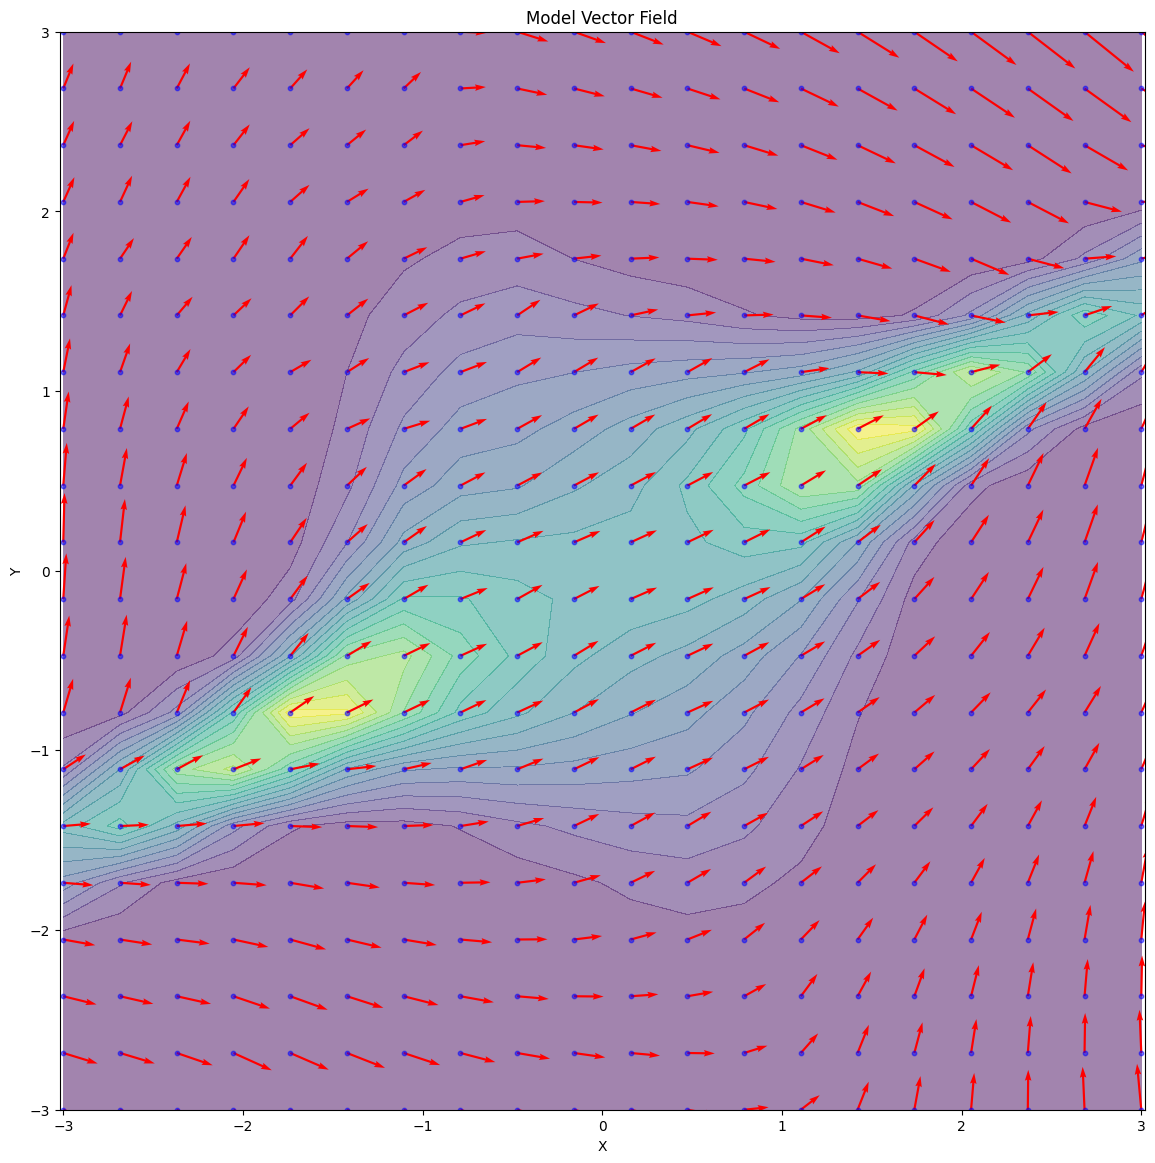

In [274]:
import matplotlib.pyplot as plt
import numpy as np

def plot_vectors(vector_list, samples):
    """
    Plots vectors as described in the user query.
    
    Args:
        vector_list: List of dicts, each with keys 'source_idx', 'up_match_idx', 'down_match_idx'
        samples: List or array of points (2D), where each index is a point (e.g., [[x0, y0], [x1, y1], ...])
    """
    # increase figure size for clarity
    plt.figure(figsize=(14, 14))
    
    x_range = np.linspace(-3, 3, 30)
    y_range = np.linspace(-3, 3, 30)
    X, Y = np.meshgrid(x_range, y_range)

    # Compute density from samples
    density = compute_density_from_samples(samples, X, Y)
    cs = plt.contourf(X, Y, density, levels=20, cmap='viridis', alpha=0.7)

    samples = np.array(samples)
    
    # Plot all sample points
    plt.scatter(samples[:, 0], samples[:, 1], color='gray', alpha=0.5, label='Samples')
    
    for v in vector_list[:100]:
        try:
            src = samples[v['source_idx']]
            up = samples[v['up_match_idx']]
            down = samples[v['down_match_idx']]
            dy_up = 1#v['up_delta_y']*3
            dy_down = 1#-1*v['down_delta_y']*3
            
            # Up vector: source -> up_match
            plt.arrow(src[0], src[1], (up[0] - src[0])/(dy_up), (up[1] - src[1])/(dy_up),
                    color='blue', head_width=0.04, length_includes_head=True, alpha=0.5)
            
            # Down vector: down_match -> source
            plt.arrow(down[0], down[1], (src[0] - down[0])/(dy_down), (src[1] - down[1])/(dy_down),
                    color='red', head_width=0.04, length_includes_head=True, alpha=0.5)
        except:
            print(f"Error plotting vectors for source index {v['source_idx']} up {v['up_match_idx']}.")
            continue

    # plt.colorbar(cs, label='Density')

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Up and Down Vectors')
    plt.legend()
    plt.axis('equal')
    plt.xlim(-3, 3)
    plt.ylim(-3, 3)

    plt.show()
def plot_vectors(X0, X1):
    """
    Plots vectors as described in the user query.
    
    Args:
        vector_list: List of dicts, each with keys 'source_idx', 'up_match_idx', 'down_match_idx'
        samples: List or array of points (2D), where each index is a point (e.g., [[x0, y0], [x1, y1], ...])
    """
    # increase figure size for clarity
    plt.figure(figsize=(14, 14))
    
    x_range = np.linspace(-3, 3, 30)
    y_range = np.linspace(-3, 3, 30)
    X, Y = np.meshgrid(x_range, y_range)
    samples = torch.cat([X0, X1], dim=0).cpu().numpy()
    # Compute density from samples
    density = compute_density_from_samples(samples, X, Y)
    cs = plt.contourf(X, Y, density, levels=20, cmap='viridis', alpha=0.7)

    samples = np.array(samples)
    
    # Plot all sample points
    plt.scatter(samples[:, 0], samples[:, 1], color='gray', alpha=0.5, label='Samples')
    
    for x0,x1 in zip(X0,X1):
        try:
            x0 = x0.cpu().numpy()
            src = x0
            up = x1.cpu().numpy()
            dy_up = 1#
            # Up vector: source -> up_match
            plt.arrow(x0[0], x0[1], (up[0] - src[0])/(dy_up), (up[1] - src[1])/(dy_up),
                    color='blue', head_width=0.04, length_includes_head=True, alpha=0.5)
            
        except:
            print(f"Error plotting vectors for source index {src} up {v['up_match_idx']}.")
            continue

    # plt.colorbar(cs, label='Density')

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Up and Down Vectors')
    plt.legend()
    plt.axis('equal')
    plt.xlim(-3, 3)
    plt.ylim(-3, 3)

    plt.show()

def plot_model_vector_field(model, points, density_samples=None, grid_size=20, scale=0.5):
    """
    Plots the vector field generated by a model on a grid of points.
    
    Args:
        model: PyTorch model that takes 2D points and outputs 2D vectors
        points: Tensor of points to evaluate the model on [N, 2]
        density_samples: Optional samples to compute density background (if None, uses points)
        grid_size: Number of grid points in each dimension
        scale: Scaling factor for the vector arrows
    """
    plt.figure(figsize=(14, 14))
    
    # Create a grid for evaluation
    x_range = np.linspace(-3, 3, grid_size)
    y_range = np.linspace(-3, 3, grid_size)
    
    # Convert points to proper format
    # X = points_2d[:, 0].detach().cpu().numpy()
    # Y = points_2d[:, 1].detach().cpu().numpy()
    X, Y = np.meshgrid(x_range, y_range)
    points_2d = torch.tensor(np.vstack([X.ravel(), Y.ravel()]).T, dtype=torch.float32)

    


    # Plot density if samples are provided
    if density_samples is not None:
        density = compute_density_from_samples(density_samples, np.meshgrid(x_range, y_range)[0], np.meshgrid(x_range, y_range)[1])
        plt.contourf(np.meshgrid(x_range, y_range)[0], np.meshgrid(x_range, y_range)[1], density, levels=20, cmap='viridis', alpha=0.5)
    elif points is not None:
        # Use the provided points for density
        points_np = points_2d.detach().cpu().numpy()
        density = compute_density_from_samples(points_np, np.meshgrid(x_range, y_range)[0], np.meshgrid(x_range, y_range)[1])
        plt.contourf(np.meshgrid(x_range, y_range)[0], np.meshgrid(x_range, y_range)[1], density, levels=20, cmap='viridis', alpha=0.5)
    
    # Evaluate model on points
    with torch.no_grad():
        model.eval()
        rating = y_func_model(points_2d)
        vectors = model(points_2d, rating)-torch.tensor([0.3,0.15])
        print(vectors)
        vectors = (vectors).detach().cpu().numpy()/10

    # Get vector components
    U = vectors[:, 0]
    V = vectors[:, 1]
    
    # Plot vector field
    plt.quiver(X, Y, U, V, color='red', scale=1/scale, width=0.002)
    
    # Plot the original points
    plt.scatter(X, Y, color='blue', alpha=0.5, s=10)
    
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Model Vector Field')
    plt.axis('equal')
    plt.xlim(-3, 3)
    plt.ylim(-3, 3)
    
    plt.show()


# plot_vectors(x0,x1)
# plot_vectors(paired_data_list,all_x)

y_func_model.cpu()
plot_model_vector_field(flow_model.cpu(), all_x+torch.randn_like(all_x), density_samples=all_x)

In [260]:

vectors = []
vector_x = []
vector_y = []
for v in paired_data_list:
    try:
        src = all_x[v['source_idx']]
        up = all_x[v['up_match_idx']]
        down = all_x[v['down_match_idx']]
        dy_up = v['up_delta_y']
        dy_down = -1*v['down_delta_y']
        
        # Up vector: source -> up_match
        # vector1 = torch.tensor((src[0], src[1])), torch.tensor((up[0] - src[0], up[1] - src[1]))/dy_up
        
        # # Down vector: down_match -> source
        # vector2 = torch.tensor((down[0], down[1])), torch.tensor( (src[0] - down[0], src[1] - down[1]))/dy_down

        # vectors.append(vector1)
        # vectors.append(vector2)
        if len(src.shape)!= 1 or len(up.shape)!= 1 or len(down.shape)!= 1:
            continue
        vector_x.append(src[:2])
        vector_x.append(down[:2])
        vector_y.append((up)[:2])
        vector_y.append((src)[:2])
    except Exception as e:
        print(f"Error plotting vectors for source index {v['source_idx']} up {v['up_match_idx']}.")
        continue

Error plotting vectors for source index 15280 up 18624.


In [269]:
import sys
sys.path.append("/Users/adamsobieszek/PycharmProjects/manipy/levelset_fm")
from utils.flow_utils import sample_conditional_pt, compute_conditional_vector_field
len(vector_x), len(vector_y)
stacked_vectors = torch.stack(vector_y).float() - torch.stack(vector_x).float()

norm_ut = torch.linalg.norm(stacked_vectors.to(device), dim=-1, keepdim=True)
# Handle potential zero norm (x0=x1 case) -> target is zero vector
zero_norm_mask = norm_ut < 1e-9
ut = (stacked_vectors.to(device))/norm_ut # Normalize the vector field
direction = torch.tensor([[8,4]]).float().to(device)
direction = direction / torch.linalg.norm(direction, dim=-1, keepdim=True) # Normalize the direction vector
mult_add = 1-direction@ut.T # Add to the multiplier
bool_direction = (mult_add < 0.03).cpu().reshape(-1)

In [270]:
import torch
import numpy as np
from torch import nn
from typing import List, Optional, Tuple, Union

class VectorFieldTransformer(torch.nn.Module):
    """
    Neural network that transforms points in R^512 to R^512.
    Acts as a vector field for flow-based models.
    """
    
    def __init__(self, input_dim=3, hidden_dims=[64,64], output_dim=2, 
                 activation=torch.nn.ReLU(), dropout_rate=0.1):
        """
        Initialize the vector field transformer network.
        
        Args:
            input_dim: Dimension of input vectors (default: 512)
            hidden_dims: List of hidden layer dimensions (default: [1024, 1024])
            output_dim: Dimension of output vectors (default: 512)
            activation: Activation function to use (default: ReLU)
            dropout_rate: Dropout probability for regularization (default: 0.1)
        """
        super(VectorFieldTransformer, self).__init__()
        
        layers = []
        prev_dim = input_dim
        
        # Build hidden layers
        for hidden_dim in hidden_dims:
            layers.append(torch.nn.Linear(prev_dim, hidden_dim))
            # batchnorm
            # layers.append(torch.nn.BatchNorm1d(hidden_dim))
            layers.append(activation)
            layers.append(torch.nn.Dropout(dropout_rate))
            prev_dim = hidden_dim
        
        # Output layer
        layers.append(torch.nn.Linear(prev_dim, output_dim))
        
        self.network = torch.nn.Sequential(*layers)
    
    def forward(self, x, rating):
        """
        Forward pass through the network.
        
        Args:
            x: Input tensor of shape (batch_size, 512)
            
        Returns:
            Transformed tensor of shape (batch_size, 512)
        """
        return self.network(torch.cat((x, rating), dim=1))
        # Concatenate rating to input\


# models/flow_model.py
import torch
import torch.nn as nn
from typing import Dict, Any
from einops import rearrange, repeat, pack, unpack
from x_transformers import Attention, FeedForward, RMSNorm
from x_transformers.x_transformers import RotaryEmbedding
from torch.amp import autocast
import math

from configs import config
from utils.stylegan_utils import get_w_avg
from models.layers import TimestepEmbedding # Import needed layer

class VectorFieldTransformer2(nn.Module):
    """ Transformer model to predict the vector field v(xt, rating_condition). """
    def __init__(
        self,
        dim: int = config.FLOW_MODEL_DIM,
        depth: int = config.FLOW_MODEL_DEPTH,
        num_heads: int = config.FLOW_MODEL_NUM_HEADS,
        dim_head: int = config.FLOW_MODEL_DIM_HEAD,
        num_registers: int = config.FLOW_MODEL_NUM_REGISTERS,
        mlp_ratio: int = 4, # Standard ratio
        dropout: float = config.FLOW_MODEL_DROPOUT,
        use_rotary: bool = True, # Use rotary embeddings
        use_flash_attention: bool = True, # Use flash attention if available
        condition_dim: int = config.FLOW_MODEL_DIM # Dimension of the rating embedding
    ):
        super().__init__()

        # Try setting matmul precision if needed and supported
        try: torch.set_float32_matmul_precision('high')
        except: pass # Ignore if not supported

        self.dim = dim
        self.depth = depth
        self.w_avg = get_w_avg().detach() # Load w_avg

        # Input projection for xt
        self.proj_in = nn.Linear(dim, dim) # W latent dim to model dim

        # Projection/Embedding for the rating condition
        # Using TimestepEmbedding adapted for scalar rating/logit input
        self.rating_embed = nn.Sequential(
            TimestepEmbedding(dim=condition_dim), # Embed scalar rating/logit
            nn.Linear(condition_dim, dim * mlp_ratio), # Project to intermediate dim
            nn.GELU(),
            nn.Linear(dim * mlp_ratio, dim) # Project to model dimension
        )

        # Learnable registers
        self.num_registers = num_registers
        if num_registers > 0:
            self.registers = nn.Parameter(torch.zeros(num_registers, dim))
            nn.init.normal_(self.registers, std=0.02) # Initialize registers
        else:
            self.registers = None

        # Rotary embeddings for position encoding (optional)
        self.rotary_emb = RotaryEmbedding(dim=dim_head) if use_rotary else None

        # Transformer Layers
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                RMSNorm(dim), # Pre-norm attention
                Attention(
                    dim=dim,
                    heads=num_heads,
                    dim_head=dim_head,
                    dropout=dropout,
                    flash=use_flash_attention,
                    # Additional options from original code:
                    # gate_value_heads=True, # Gating can sometimes help
                    # softclamp_logits=False, # Typically false
                    # zero_init_output=True # Can improve stability
                ),
                RMSNorm(dim), # Pre-norm feedforward
                FeedForward(
                    dim=dim,
                    mult=mlp_ratio,
                    dropout=dropout,
                    glu=True # Use GLU activation
                )
            ]))

        # Final output layers
        self.final_norm = RMSNorm(dim)
        self.to_vector_field = nn.Linear(dim, dim) # Output matches input W dimension

        # --- Part from Original Code: Subtracting Trust Model Gradient ---
        # This requires the trust model during forward pass.
        # It makes the flow model dependent on the specific trust model structure.
        # Consider if this is desired, or if the target vector 'ut' should already account for this.
        # For now, implementing as in the original 'forward'.
        self.subtract_trust_gradient = True # Flag to control this behavior
        print(f"Flow model initialized. Subtract trust gradient: {self.subtract_trust_gradient}")


    def forward(
        self,
        xt: torch.Tensor,      # Latent vector at time t (batch, 512)
        rating_cond: torch.Tensor # Rating condition (batch, 1) or (batch,)
    ) -> torch.Tensor:
        """ Forward pass of the flow model. """
        batch_size = xt.shape[0]
        device = xt.device

        # --- Input Processing ---
        # Center xt around w_avg
        xt_centered = xt #- self.w_avg.to(device)
        # Project xt features
        h = self.proj_in(xt_centered)

        # Embed rating condition
        # Ensure rating_cond has shape (batch,) or (batch, 1) before embedding
        if rating_cond.ndim > 1 and rating_cond.shape[1] > 1:
             rating_cond = rating_cond[:, 0] # Take first element if more than one dim provided

        rating_emb = self.rating_embed(rating_cond) # Shape (batch, dim)

        # Combine input features with rating embedding (simple addition)
        h = h + rating_emb

        # Add registers if used
        tokens = [h]
        if self.registers is not None:
            registers = repeat(self.registers, 'r d -> b r d', b=batch_size)
            tokens.insert(0, registers) # Prepend registers

        # Pack tokens for transformer input
        h_packed, ps = pack(tokens, 'b * d') # Shape (batch, num_tokens, dim)
        num_tokens = h_packed.shape[1]

        # --- Rotary Embeddings (Optional) ---
        rotary_pos_emb = None
        if self.rotary_emb is not None:
            # Generate rotary embeddings based on sequence length
            rotary_pos_emb = self.rotary_emb.forward_from_seq_len(seq_len=num_tokens)

        # --- Transformer Layers ---
        for norm1, attn, norm2, ff in self.layers:
            # Attention block
            h_res = h_packed
            h_norm1 = norm1(h_packed)
            attn_out = attn(h_norm1, rotary_pos_emb=rotary_pos_emb)
            h_packed = h_res + attn_out # Residual connection

            # FeedForward block
            h_res = h_packed
            h_norm2 = norm2(h_packed)
            ff_out = ff(h_norm2)
            h_packed = h_res + ff_out # Residual connection

        # Unpack tokens, discard registers
        unpacked_tokens = unpack(h_packed, ps, 'b * d')
        h_out = unpacked_tokens[-1] # Get the output corresponding to the original xt input

        # --- Final Output ---
        h_final = self.final_norm(h_out)
        vector_field_pred = self.to_vector_field(h_final) # Predicted raw vector field

        # --- Subtract Trust Model Gradient (as in original code) ---
        if self.subtract_trust_gradient:
             try:
                 # This requires access to the *specific* trust model used ('model' in original code)
                 # If running this standalone, 'model' needs to be loaded/passed appropriately.
                 # Assuming 'model' is available in the scope where this forward is called (e.g., passed to RatingODE)
                 # This is not ideal design - makes flow model dependent on external model.
                #  xt_detached = xt.clone().detach().requires_grad_(True)
                #  # Need the trust model callable here
                #  # Replace 'model' with actual trust model instance if needed
                #  # Example if trust_model is passed: trust_output = trust_model(xt_detached, 'logit')
                # #  from models.trust_model import load_trust_model_ensemble # Temp import, better to pass model
                # #  trust_model_instance = load_trust_model_ensemble(config.TARGET_DIMENSION, config.TRUST_MODEL_ENSEMBLE_SIZE, config.CHECKPOINT_DIR_TRUST, device)
                #  trust_model_instance = trust_model.to(device)
                #  trust_output = trust_model_instance(xt_detached) # Get logit output

                #  # Sum for scalar loss to get gradient w.r.t. xt
                #  trust_output_sum = torch.sum(trust_output)
                #  trust_output_sum.backward()

                #  xt_grad = xt_detached.grad.detach() # Gradient of trust score w.r.t. xt

                #  # Subtract the trust gradient from the predicted vector field
                #  vector_field_final = vector_field_pred - xt_grad
                 vector_field_final = vector_field_pred

                 # Normalize the final vector field
                 norm = torch.linalg.norm(vector_field_final, dim=-1, keepdim=True)
                 vector_field_normalized = vector_field_final / torch.clamp(norm, min=1e-9) # Avoid division by zero

                 return vector_field_normalized

             except Exception as e:
                 print(f"Warning: Failed to subtract trust gradient: {e}. Returning raw prediction.")
                 # Fallback: return the raw prediction, maybe normalized
                 norm_raw = torch.linalg.norm(vector_field_pred, dim=-1, keepdim=True)
                 return vector_field_pred #/ torch.clamp(norm_raw, min=1e-9)
        else:
             # If not subtracting gradient, just return the prediction (optionally normalized)
             norm_raw = torch.linalg.norm(vector_field_pred, dim=-1, keepdim=True)
             return vector_field_pred #/ torch.clamp(norm_raw, min=1e-9)


class RatingODE(nn.Module):
    """ Wraps the flow model and trust model for ODE integration during inference. """
    def __init__(self, flow_model, trust_model):
        super().__init__()
        self.flow = flow_model
        self.trust = trust_model
        self.flow.eval() # Ensure flow model is in eval mode
        self.trust.eval() # Ensure trust model is in eval mode

    @torch.no_grad() # ODE solver step should not compute gradients normally
    def forward(self, t, x): # torchdyn/torchdiffeq expect forward(t, x) signature
        """
        Predicts the vector field dx/dt = v(x, rating(x)) at time t.
        Args:
            t (torch.Tensor): Current time (scalar or batch). Not directly used by this model but part of ODE signature.
            x (torch.Tensor): Current state (latent vectors) (batch_size, dim).
        Returns:
            torch.Tensor: Predicted vector field dx/dt (batch_size, dim).
        """
        # Get current rating/logit using the trust model
        # Assuming trust model predicts logit directly or via "logit" mode
        # Ensure input x matches what trust model expects (e.g., W space)
        rating_condition = self.trust(x, output="logit") # Shape (batch, 1)

        # Get vector field prediction from the flow model using current state x and rating
        # Assuming flow model's forward is flow(xt, rating_cond)
        vector_field = self.flow(x, rating_cond)
        return vector_field


In [271]:

# train_flow.py
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import time
import os
from tqdm import tqdm
import sys

# Ensure project root is in path
project_root = ("/Users/adamsobieszek/PycharmProjects/manipy/levelset_fm")
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Local imports
from configs import config
from data.data_utils import calculate_cost_multiplier # For dynamic cost calculation
# from models.flow_model import VectorFieldTransformer # Flow model definition
from utils.flow_utils import sample_conditional_pt, compute_conditional_vector_field
from utils.checkpoint_utils import save_flow_checkpoint, load_flow_checkpoint

""" Main function to train the VectorFieldTransformer flow model. """
device = torch.device("mps")
print(f"--- Starting Flow Model Training for: {config.TARGET_DIMENSION} ---")
print(f"Using device: {device}")
import torch
import numpy as np
from torch import nn
from typing import List, Optional, Tuple, Union
torch.manual_seed(42)
np.random.seed(42)
if device.type == 'cuda':
    torch.cuda.manual_seed_all(42)

# --- Load Pre-trained y_func Model ---
# This is required for conditioning and dynamic cost calculation
y_func_model.eval()
y_func_model.to(device) # Ensure y_func model is on the correct device
# Define the logit function using the loaded y_func model
# This function will be passed to calculate_cost_multiplier
logit_fn = lambda x: y_func_model(x)
print("Pre-trained y_func model loaded for conditioning.")

# --- Initialize Flow Model, Optimizer, Scheduler ---
flow_model = VectorFieldTransformer( # Uses parameters from config
    # dim=2,
    # depth=6,
    # num_heads=6,
    # dim_head=24,
    # num_registers=0,
    # dropout=0.2#config.FLOW_MODEL_DROPOUT
).to(device)

flow_model.to(device) # Ensure y_func model is on the correct device
optimizer = optim.AdamW(
    flow_model.parameters(),
    lr=config.FLOW_LR,
    weight_decay=0.001
)
scheduler = optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=200*1000 # T_max is total steps or epochs? Assume steps here if T_max large
)

# --- Load Checkpoint (if resuming flow model training) ---
start_epoch = config.FLOW_START_EPOCH
run_name = config.FLOW_RUN_NAME # Use config default or loaded value
best_metrics = config.BEST_METRICS.copy() # Get mutable copy
config.FLOW_DATALOADER_BATCH_SIZE = 1024

# Specify path to checkpoint if resuming
resume_model_path = None # e.g., "flow_checkpoints/attractive_123456_epoch_100.pt"
# if resume_model_path and os.path.exists(resume_model_path):
#     print(f"Attempting to resume from checkpoint: {resume_model_path}")
#     flow_model_loaded, opt_loaded, sched_loaded, epoch_loaded, metrics_loaded, name_loaded = load_flow_checkpoint(
#         model_path=resume_model_path,
#         device=device
#     )
#     if flow_model_loaded:
#             flow_model = flow_model_loaded
#             optimizer = opt_loaded if opt_loaded else optimizer # Use loaded if successful
#             scheduler = sched_loaded if sched_loaded else scheduler
#             start_epoch = epoch_loaded
#             best_metrics.update(metrics_loaded) # Update best metrics dict
#             run_name = name_loaded # Use the run name from the checkpoint
#             print(f"Resumed from epoch {start _epoch}. Run name: {run_name}")
#     else:
#             print("Checkpoint loading failed. Starting from scratch.")
# else:
#     print("No valid resume checkpoint specified. Starting training from scratch.")
#     run_name = f"{int(time.time())}" # Assign new run name if not resuming

def sample_conditional_pt(x0: torch.Tensor, x1: torch.Tensor, t: torch.Tensor, sigma: float) -> torch.Tensor:
    """
    Samples points xt along the probability path N(t * x1 + (1 - t) * x0, sigma_t^2).
    The noise level sigma_t seems to depend on t in the original code via (1.1-t)*sigma.

    Args:
        x0: Starting points (batch_size, latent_dim).
        x1: Ending points (batch_size, latent_dim).
        t: Time steps (batch_size,), values between 0 and 1.
        sigma: Base standard deviation of the noise.

    Returns:
        Sampled points xt (batch_size, latent_dim).
    """
    t_reshaped = t.reshape(-1, *([1] * (x0.dim() - 1))) # Shape (bs, 1, ..., 1)
    mu_t = t_reshaped * x1 + (1 - t_reshaped) * x0
    # Noise scaled by (1.1 - t), similar to original code snippet
    # Ensure t is also shaped correctly for this calculation if needed, here using t_reshaped
    sigma_t = 0#(1 - t_reshaped) * sigma
    epsilon = torch.randn_like(x0)
    xt = mu_t + sigma_t * epsilon
    return xt
# --- Training Loop ---
print(f"Starting flow training loop from epoch {start_epoch}... Run: {run_name}")
total_epochs = config.FLOW_TOTAL_EPOCHS
steps_per_epoch_chunk = config.FLOW_EPOCH_CHUNK_STEPS
bs_per_step = 256
accum_steps = config.FLOW_ACCUMULATION_STEPS
effective_batch_size = bs_per_step * accum_steps

epoch_losses = [] # Accumulates losses within an epoch chunk for averaging
for i in range(1000):
    for k, (X0_epoch, X1_epoch, Q_epoch) in enumerate(tqdm(dataloader, initial=start_epoch, total=total_epochs, desc="Epoch Chunks"), start=start_epoch):
        if k >= total_epochs: break # Stop if we reach target total epochs

        flow_model.train()
        current_epoch_chunk_losses = [] # Losses specific to this chunk's steps

        # Ensure data is on the correct device (OTDataset might keep W on device)
        X0_epoch, X1_epoch, Q_epoch = X0_epoch.to(device), X1_epoch.to(device), Q_epoch.to(device)


        # 2. Compute target vector field directions (UNNORMALIZED)
        Ut_epoch = compute_conditional_vector_field(X0_epoch, X1_epoch) # x1 - x0
        # print(Ut_epoch.shape)
        # --- Inner loop over steps within the epoch chunk ---
        optimizer.zero_grad() # Zero gradients at the start of the accumulation cycle
        accumulated_loss_val = 0.0 # Tracks loss for logging within accumulation cycle

        # Determine actual number of steps based on loaded data size vs requested steps
        num_samples_in_chunk = X0_epoch.size(0)
        actual_steps = min(steps_per_epoch_chunk, num_samples_in_chunk // bs_per_step)
        if actual_steps == 0 and num_samples_in_chunk > 0:
                actual_steps = 1 # Ensure at least one step if there's data
                bs_per_step = num_samples_in_chunk # Adjust batch size if needed for one step

        for i in range(actual_steps):
            # --- Get mini-batch for this step ---
            start_idx = i * bs_per_step
            end_idx = start_idx + bs_per_step
            x0 = X0_epoch[start_idx:end_idx]
            x1 = X1_epoch[start_idx:end_idx]
            ut_unnormalized = Ut_epoch[start_idx:end_idx]
            # ut_unnormalized -= torch.tensor([0.1,0.05]).to(device)
            if x0.shape[0] == 0: continue # Skip if somehow batch is empty
            # --- Normalize target vector field 'ut' ---
            with torch.no_grad():
                    norm_ut = torch.linalg.norm(ut_unnormalized, dim=-1, keepdim=True)
                    # Handle potential zero norm (x0=x1 case) -> target is zero vector
                    ut = (ut_unnormalized)/norm_ut # Normalize the vector field

            # --- Sample time t and point xt on the path ---
            t = torch.rand(x0.shape[0], device=device)
            xt = sample_conditional_pt(x0, x1, t, sigma=0.05)

            # --- Get rating condition at xt ---
            with torch.no_grad():
                rating_condition = fn(xt) # Shape (batch, 1)

            # --- Predict vector field vt = flow(xt, condition) ---
            vt = flow_model(xt, rating_condition)
            # --- Calculate Loss ---
            loss = torch.mean( ((vt - ut) ** 2))

            # Handle potential NaN loss
            if torch.isnan(loss):
                print(f"\nWarning: NaN loss detected at epoch {k}, step {i}. Skipping step.")
                loss_value = np.nan
                # Reset gradients for this step? Or just skip accumulation?
                optimizer.zero_grad() # Reset gradients for safety
                accumulated_loss_val = 0.0 # Reset accumulated loss for this cycle
                continue # Skip accumulation and backward pass
            else:
                loss_value = loss.item()

            # Scale loss for gradient accumulation
            scaled_loss = loss / accum_steps
            scaled_loss.backward()

            accumulated_loss_val += loss_value # Accumulate *unscaled* loss for logging

            # --- Optimizer Step after Accumulation ---
            if (i + 1) % accum_steps == 0:
                # Clip gradients
                torch.nn.utils.clip_grad_norm_(flow_model.parameters(), max_norm=config.FLOW_CLIP_GRAD_NORM)

                # Optimizer step
                optimizer.step()

                # Scheduler step (adjust based on scheduler type)
                # CosineAnnealingLR usually steps per optimizer step or per epoch
                scheduler.step() # Step per optimizer step

                # Reset gradients for the next cycle
                optimizer.zero_grad()

                # Log accumulated loss
                step_loss = accumulated_loss_val / accum_steps if not np.isnan(accumulated_loss_val) else np.nan
                current_epoch_chunk_losses.append(step_loss)
                epoch_losses.append(step_loss) # Collect globally for overall average trend
                # tqdm description can be updated here if needed
                # pbar.set_postfix({"Step Loss": f"{step_loss:.4f}", "LR": f"{optimizer.param_groups[0]['lr']:.6f}"})

                accumulated_loss_val = 0.0 # Reset accumulated loss


        # Handle partial accumulation at the end of the inner loop if needed
        if (actual_steps % accum_steps != 0) and accumulated_loss_val > 0:
            print("Processing partial accumulation step at end of epoch chunk.")
            torch.nn.utils.clip_grad_norm_(flow_model.parameters(), max_norm=config.FLOW_CLIP_GRAD_NORM)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            partial_step_loss = accumulated_loss_val / (actual_steps % accum_steps) if not np.isnan(accumulated_loss_val) else np.nan
            if not np.isnan(partial_step_loss):
                    current_epoch_chunk_losses.append(partial_step_loss)
                    epoch_losses.append(partial_step_loss)


        # --- End of Epoch Chunk ---
        mean_chunk_loss = np.nanmean(current_epoch_chunk_losses) if current_epoch_chunk_losses else np.nan
    print(f"Epoch Chunk {k} finished. Mean Loss: {mean_chunk_loss:.6f}, LR: {optimizer.param_groups[0]['lr']:.8f}")

    # Optional: Add evaluation step here periodically (e.g., every N epochs)
    # to update best_metrics['quality'], etc. for checkpointing 'best' models based on metrics.

    # --- Checkpointing ---
    # if (k + 1) % config.FLOW_CHECKPOINT_INTERVAL == 0:
    #         # Use the average loss from recent steps or the current chunk loss for checkpoint metadata
    #         checkpoint_loss = mean_chunk_loss if not np.isnan(mean_chunk_loss) else best_metrics.get('loss', float('inf'))

    #         # Update the 'loss' in best_metrics if current is better before saving
    #         if checkpoint_loss < best_metrics.get('loss', float('inf')):
    #             best_metrics['loss'] = checkpoint_loss

    #         save_flow_checkpoint(
    #             model=flow_model,
    #             optimizer=optimizer,
    #             scheduler=scheduler,
    #             epoch=k, # Save based on epoch chunk number k
    #             loss=checkpoint_loss,
    #             run_name=run_name,
    #             best_metrics=best_metrics, # Pass the potentially updated dict
    #             dim_name=config.TARGET_DIMENSION
    #         )


--- Starting Flow Model Training for: attractive ---
Using device: mps
Pre-trained trust model loaded for conditioning.
Loading dataset...
torch.Size([13676, 2]) torch.Size([13676, 2])
Dataset and DataLoader prepared.
Starting flow training loop from epoch 0... Run: 1746638396


Epoch Chunks:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch Chunks:   0%|          | 1/10000 [00:02<7:04:38,  2.55s/it]


Epoch Chunk 0 finished. Mean Loss: 0.040457, LR: 0.00030000


Epoch Chunks:   0%|          | 1/10000 [00:02<5:47:30,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.023099, LR: 0.00030000


Epoch Chunks:   0%|          | 1/10000 [00:02<5:41:14,  2.05s/it]


Epoch Chunk 0 finished. Mean Loss: 0.019493, LR: 0.00030000


Epoch Chunks:   0%|          | 1/10000 [00:02<5:44:50,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.017797, LR: 0.00030000


Epoch Chunks:   0%|          | 1/10000 [00:02<5:48:50,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.017211, LR: 0.00030000


Epoch Chunks:   0%|          | 1/10000 [00:02<5:45:47,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.016939, LR: 0.00030000


Epoch Chunks:   0%|          | 1/10000 [00:02<5:42:51,  2.06s/it]


Epoch Chunk 0 finished. Mean Loss: 0.016770, LR: 0.00030000


Epoch Chunks:   0%|          | 1/10000 [00:02<5:44:57,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.016641, LR: 0.00030000


Epoch Chunks:   0%|          | 1/10000 [00:02<5:48:51,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.016637, LR: 0.00030000


Epoch Chunks:   0%|          | 1/10000 [00:02<5:45:18,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.016534, LR: 0.00029999


Epoch Chunks:   0%|          | 1/10000 [00:02<5:46:37,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.016507, LR: 0.00029999


Epoch Chunks:   0%|          | 1/10000 [00:02<5:47:39,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.016547, LR: 0.00029999


Epoch Chunks:   0%|          | 1/10000 [00:02<5:48:37,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.016399, LR: 0.00029999


Epoch Chunks:   0%|          | 1/10000 [00:02<5:48:28,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.016425, LR: 0.00029999


Epoch Chunks:   0%|          | 1/10000 [00:02<5:44:02,  2.06s/it]


Epoch Chunk 0 finished. Mean Loss: 0.016289, LR: 0.00029999


Epoch Chunks:   0%|          | 1/10000 [00:02<5:46:58,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.016344, LR: 0.00029999


Epoch Chunks:   0%|          | 1/10000 [00:02<5:44:44,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.016287, LR: 0.00029998


Epoch Chunks:   0%|          | 1/10000 [00:02<5:44:03,  2.06s/it]


Epoch Chunk 0 finished. Mean Loss: 0.016262, LR: 0.00029998


Epoch Chunks:   0%|          | 1/10000 [00:02<5:49:21,  2.10s/it]


Epoch Chunk 0 finished. Mean Loss: 0.016233, LR: 0.00029998


Epoch Chunks:   0%|          | 1/10000 [00:02<5:53:59,  2.12s/it]


Epoch Chunk 0 finished. Mean Loss: 0.016212, LR: 0.00029998


Epoch Chunks:   0%|          | 1/10000 [00:02<5:44:04,  2.06s/it]


Epoch Chunk 0 finished. Mean Loss: 0.016225, LR: 0.00029998


Epoch Chunks:   0%|          | 1/10000 [00:02<5:52:17,  2.11s/it]


Epoch Chunk 0 finished. Mean Loss: 0.016188, LR: 0.00029997


Epoch Chunks:   0%|          | 1/10000 [00:02<5:48:41,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.016116, LR: 0.00029997


Epoch Chunks:   0%|          | 1/10000 [00:02<5:50:39,  2.10s/it]


Epoch Chunk 0 finished. Mean Loss: 0.016141, LR: 0.00029997


Epoch Chunks:   0%|          | 1/10000 [00:02<5:43:52,  2.06s/it]


Epoch Chunk 0 finished. Mean Loss: 0.016144, LR: 0.00029997


Epoch Chunks:   0%|          | 1/10000 [00:02<5:45:58,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.016114, LR: 0.00029996


Epoch Chunks:   0%|          | 1/10000 [00:02<5:48:23,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.016066, LR: 0.00029996


Epoch Chunks:   0%|          | 1/10000 [00:02<5:45:09,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.016071, LR: 0.00029996


Epoch Chunks:   0%|          | 1/10000 [00:02<5:51:20,  2.11s/it]


Epoch Chunk 0 finished. Mean Loss: 0.016081, LR: 0.00029996


Epoch Chunks:   0%|          | 1/10000 [00:02<5:42:18,  2.05s/it]


Epoch Chunk 0 finished. Mean Loss: 0.016010, LR: 0.00029995


Epoch Chunks:   0%|          | 1/10000 [00:02<5:47:43,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.016025, LR: 0.00029995


Epoch Chunks:   0%|          | 1/10000 [00:02<5:46:00,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015990, LR: 0.00029995


Epoch Chunks:   0%|          | 1/10000 [00:02<5:46:33,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.016001, LR: 0.00029994


Epoch Chunks:   0%|          | 1/10000 [00:02<5:47:14,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015998, LR: 0.00029994


Epoch Chunks:   0%|          | 1/10000 [00:02<5:47:53,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015991, LR: 0.00029994


Epoch Chunks:   0%|          | 1/10000 [00:02<5:47:17,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015943, LR: 0.00029993


Epoch Chunks:   0%|          | 1/10000 [00:02<5:44:24,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015956, LR: 0.00029993


Epoch Chunks:   0%|          | 1/10000 [00:02<5:47:08,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015919, LR: 0.00029992


Epoch Chunks:   0%|          | 1/10000 [00:02<5:46:19,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015929, LR: 0.00029992


Epoch Chunks:   0%|          | 1/10000 [00:02<6:04:12,  2.19s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015946, LR: 0.00029992


Epoch Chunks:   0%|          | 1/10000 [00:02<5:51:17,  2.11s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015898, LR: 0.00029991


Epoch Chunks:   0%|          | 1/10000 [00:02<5:48:03,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015955, LR: 0.00029991


Epoch Chunks:   0%|          | 1/10000 [00:02<5:46:35,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015896, LR: 0.00029990


Epoch Chunks:   0%|          | 1/10000 [00:02<5:45:34,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015903, LR: 0.00029990


Epoch Chunks:   0%|          | 1/10000 [00:02<5:45:37,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015901, LR: 0.00029989


Epoch Chunks:   0%|          | 1/10000 [00:02<5:51:16,  2.11s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015875, LR: 0.00029989


Epoch Chunks:   0%|          | 1/10000 [00:02<5:45:52,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015845, LR: 0.00029989


Epoch Chunks:   0%|          | 1/10000 [00:02<5:45:02,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015882, LR: 0.00029988


Epoch Chunks:   0%|          | 1/10000 [00:02<5:45:45,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015888, LR: 0.00029988


Epoch Chunks:   0%|          | 1/10000 [00:02<5:48:04,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015898, LR: 0.00029987


Epoch Chunks:   0%|          | 1/10000 [00:02<5:50:49,  2.11s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015846, LR: 0.00029986


Epoch Chunks:   0%|          | 1/10000 [00:02<5:42:22,  2.05s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015846, LR: 0.00029986


Epoch Chunks:   0%|          | 1/10000 [00:02<5:42:57,  2.06s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015851, LR: 0.00029985


Epoch Chunks:   0%|          | 1/10000 [00:02<5:47:14,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015835, LR: 0.00029985


Epoch Chunks:   0%|          | 1/10000 [00:02<5:47:36,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015842, LR: 0.00029984


Epoch Chunks:   0%|          | 1/10000 [00:02<5:44:24,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015828, LR: 0.00029984


Epoch Chunks:   0%|          | 1/10000 [00:02<5:44:00,  2.06s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015845, LR: 0.00029983


Epoch Chunks:   0%|          | 1/10000 [00:02<5:44:36,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015828, LR: 0.00029983


Epoch Chunks:   0%|          | 1/10000 [00:02<5:46:52,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015796, LR: 0.00029982


Epoch Chunks:   0%|          | 1/10000 [00:02<5:46:52,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015788, LR: 0.00029981


Epoch Chunks:   0%|          | 1/10000 [00:02<5:46:11,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015786, LR: 0.00029981


Epoch Chunks:   0%|          | 1/10000 [00:02<5:47:48,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015763, LR: 0.00029980


Epoch Chunks:   0%|          | 1/10000 [00:02<5:48:50,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015768, LR: 0.00029979


Epoch Chunks:   0%|          | 1/10000 [00:02<5:45:20,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015786, LR: 0.00029979


Epoch Chunks:   0%|          | 1/10000 [00:02<5:42:14,  2.05s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015780, LR: 0.00029978


Epoch Chunks:   0%|          | 1/10000 [00:02<5:46:36,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015767, LR: 0.00029977


Epoch Chunks:   0%|          | 1/10000 [00:02<5:42:45,  2.06s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015718, LR: 0.00029977


Epoch Chunks:   0%|          | 1/10000 [00:02<5:49:57,  2.10s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015788, LR: 0.00029976


Epoch Chunks:   0%|          | 1/10000 [00:02<5:50:57,  2.11s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015711, LR: 0.00029975


Epoch Chunks:   0%|          | 1/10000 [00:02<5:47:57,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015729, LR: 0.00029975


Epoch Chunks:   0%|          | 1/10000 [00:02<5:46:28,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015753, LR: 0.00029974


Epoch Chunks:   0%|          | 1/10000 [00:02<5:43:03,  2.06s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015753, LR: 0.00029973


Epoch Chunks:   0%|          | 1/10000 [00:02<5:41:37,  2.05s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015760, LR: 0.00029972


Epoch Chunks:   0%|          | 1/10000 [00:02<5:42:23,  2.05s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015759, LR: 0.00029972


Epoch Chunks:   0%|          | 1/10000 [00:02<5:45:38,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015724, LR: 0.00029971


Epoch Chunks:   0%|          | 1/10000 [00:02<5:46:47,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015738, LR: 0.00029970


Epoch Chunks:   0%|          | 1/10000 [00:02<5:46:48,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015718, LR: 0.00029969


Epoch Chunks:   0%|          | 1/10000 [00:02<5:46:19,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015708, LR: 0.00029968


Epoch Chunks:   0%|          | 1/10000 [00:02<5:51:02,  2.11s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015718, LR: 0.00029968


Epoch Chunks:   0%|          | 1/10000 [00:02<5:47:55,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015724, LR: 0.00029967


Epoch Chunks:   0%|          | 1/10000 [00:02<5:48:31,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015718, LR: 0.00029966


Epoch Chunks:   0%|          | 1/10000 [00:02<5:45:00,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015735, LR: 0.00029965


Epoch Chunks:   0%|          | 1/10000 [00:02<5:43:51,  2.06s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015728, LR: 0.00029964


Epoch Chunks:   0%|          | 1/10000 [00:02<5:45:49,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015737, LR: 0.00029963


Epoch Chunks:   0%|          | 1/10000 [00:02<5:41:47,  2.05s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015718, LR: 0.00029962


Epoch Chunks:   0%|          | 1/10000 [00:02<5:47:04,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015697, LR: 0.00029962


Epoch Chunks:   0%|          | 1/10000 [00:02<5:45:20,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015732, LR: 0.00029961


Epoch Chunks:   0%|          | 1/10000 [00:02<5:42:01,  2.05s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015651, LR: 0.00029960


Epoch Chunks:   0%|          | 1/10000 [00:02<5:51:49,  2.11s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015692, LR: 0.00029959


Epoch Chunks:   0%|          | 1/10000 [00:02<5:43:45,  2.06s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015627, LR: 0.00029958


Epoch Chunks:   0%|          | 1/10000 [00:02<5:49:07,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015661, LR: 0.00029957


Epoch Chunks:   0%|          | 1/10000 [00:02<6:20:05,  2.28s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015691, LR: 0.00029956


Epoch Chunks:   0%|          | 1/10000 [00:02<5:43:14,  2.06s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015671, LR: 0.00029955


Epoch Chunks:   0%|          | 1/10000 [00:02<5:48:33,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015726, LR: 0.00029954


Epoch Chunks:   0%|          | 1/10000 [00:02<5:44:20,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015695, LR: 0.00029953


Epoch Chunks:   0%|          | 1/10000 [00:02<5:45:20,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015656, LR: 0.00029952


Epoch Chunks:   0%|          | 1/10000 [00:02<5:43:19,  2.06s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015663, LR: 0.00029951


Epoch Chunks:   0%|          | 1/10000 [00:02<5:42:45,  2.06s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015688, LR: 0.00029950


Epoch Chunks:   0%|          | 1/10000 [00:02<5:45:45,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015658, LR: 0.00029949


Epoch Chunks:   0%|          | 1/10000 [00:02<5:45:10,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015667, LR: 0.00029948


Epoch Chunks:   0%|          | 1/10000 [00:02<5:44:35,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015670, LR: 0.00029947


Epoch Chunks:   0%|          | 1/10000 [00:02<5:47:57,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015665, LR: 0.00029946


Epoch Chunks:   0%|          | 1/10000 [00:02<5:46:13,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015678, LR: 0.00029945


Epoch Chunks:   0%|          | 1/10000 [00:02<5:43:45,  2.06s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015653, LR: 0.00029944


Epoch Chunks:   0%|          | 1/10000 [00:02<5:42:41,  2.06s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015645, LR: 0.00029943


Epoch Chunks:   0%|          | 1/10000 [00:02<5:46:14,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015654, LR: 0.00029942


Epoch Chunks:   0%|          | 1/10000 [00:02<5:50:38,  2.10s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015666, LR: 0.00029941


Epoch Chunks:   0%|          | 1/10000 [00:02<5:49:19,  2.10s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015648, LR: 0.00029939


Epoch Chunks:   0%|          | 1/10000 [00:02<5:48:00,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015646, LR: 0.00029938


Epoch Chunks:   0%|          | 1/10000 [00:02<5:44:32,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015630, LR: 0.00029937


Epoch Chunks:   0%|          | 1/10000 [00:02<5:43:18,  2.06s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015639, LR: 0.00029936


Epoch Chunks:   0%|          | 1/10000 [00:02<5:47:53,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015639, LR: 0.00029935


Epoch Chunks:   0%|          | 1/10000 [00:02<5:49:32,  2.10s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015640, LR: 0.00029934


Epoch Chunks:   0%|          | 1/10000 [00:02<5:43:51,  2.06s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015641, LR: 0.00029932


Epoch Chunks:   0%|          | 1/10000 [00:02<5:44:12,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015616, LR: 0.00029931


Epoch Chunks:   0%|          | 1/10000 [00:02<5:44:57,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015597, LR: 0.00029930


Epoch Chunks:   0%|          | 1/10000 [00:02<5:46:15,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015615, LR: 0.00029929


Epoch Chunks:   0%|          | 1/10000 [00:02<5:47:25,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015621, LR: 0.00029928


Epoch Chunks:   0%|          | 1/10000 [00:02<5:47:14,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015629, LR: 0.00029926


Epoch Chunks:   0%|          | 1/10000 [00:02<5:42:23,  2.05s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015657, LR: 0.00029925


Epoch Chunks:   0%|          | 1/10000 [00:02<5:43:47,  2.06s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015628, LR: 0.00029924


Epoch Chunks:   0%|          | 1/10000 [00:02<5:47:01,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015580, LR: 0.00029923


Epoch Chunks:   0%|          | 1/10000 [00:02<5:44:01,  2.06s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015639, LR: 0.00029921


Epoch Chunks:   0%|          | 1/10000 [00:02<5:45:05,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015632, LR: 0.00029920


Epoch Chunks:   0%|          | 1/10000 [00:02<5:56:20,  2.14s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015632, LR: 0.00029919


Epoch Chunks:   0%|          | 1/10000 [00:02<5:47:35,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015601, LR: 0.00029918


Epoch Chunks:   0%|          | 1/10000 [00:02<5:45:41,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015622, LR: 0.00029916


Epoch Chunks:   0%|          | 1/10000 [00:02<5:47:02,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015613, LR: 0.00029915


Epoch Chunks:   0%|          | 1/10000 [00:02<5:46:38,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015622, LR: 0.00029914


Epoch Chunks:   0%|          | 1/10000 [00:02<5:47:34,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015650, LR: 0.00029912


Epoch Chunks:   0%|          | 1/10000 [00:02<5:44:32,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015653, LR: 0.00029911


Epoch Chunks:   0%|          | 1/10000 [00:02<5:46:16,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015613, LR: 0.00029910


Epoch Chunks:   0%|          | 1/10000 [00:02<5:42:09,  2.05s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015626, LR: 0.00029908


Epoch Chunks:   0%|          | 1/10000 [00:02<5:46:36,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015590, LR: 0.00029907


Epoch Chunks:   0%|          | 1/10000 [00:02<5:47:32,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015610, LR: 0.00029905


Epoch Chunks:   0%|          | 1/10000 [00:02<5:41:19,  2.05s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015584, LR: 0.00029904


Epoch Chunks:   0%|          | 1/10000 [00:02<5:50:29,  2.10s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015612, LR: 0.00029903


Epoch Chunks:   0%|          | 1/10000 [00:02<5:48:01,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015605, LR: 0.00029901


Epoch Chunks:   0%|          | 1/10000 [00:02<5:52:26,  2.11s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015568, LR: 0.00029900


Epoch Chunks:   0%|          | 1/10000 [00:02<5:42:31,  2.06s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015613, LR: 0.00029898


Epoch Chunks:   0%|          | 1/10000 [00:02<5:48:57,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015587, LR: 0.00029897


Epoch Chunks:   0%|          | 1/10000 [00:02<6:19:29,  2.28s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015600, LR: 0.00029895


Epoch Chunks:   0%|          | 1/10000 [00:02<5:47:36,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015600, LR: 0.00029894


Epoch Chunks:   0%|          | 1/10000 [00:02<5:42:35,  2.06s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015595, LR: 0.00029892


Epoch Chunks:   0%|          | 1/10000 [00:02<5:47:03,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015574, LR: 0.00029891


Epoch Chunks:   0%|          | 1/10000 [00:02<5:46:14,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015631, LR: 0.00029889


Epoch Chunks:   0%|          | 1/10000 [00:02<5:38:17,  2.03s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015590, LR: 0.00029888


Epoch Chunks:   0%|          | 1/10000 [00:02<5:45:41,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015625, LR: 0.00029886


Epoch Chunks:   0%|          | 1/10000 [00:02<5:50:25,  2.10s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015590, LR: 0.00029885


Epoch Chunks:   0%|          | 1/10000 [00:02<5:43:07,  2.06s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015595, LR: 0.00029883


Epoch Chunks:   0%|          | 1/10000 [00:02<5:46:45,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015593, LR: 0.00029882


Epoch Chunks:   0%|          | 1/10000 [00:02<5:44:10,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015549, LR: 0.00029880


Epoch Chunks:   0%|          | 1/10000 [00:02<5:59:05,  2.15s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015591, LR: 0.00029878


Epoch Chunks:   0%|          | 1/10000 [00:02<5:53:01,  2.12s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015564, LR: 0.00029877


Epoch Chunks:   0%|          | 1/10000 [00:02<5:48:09,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015592, LR: 0.00029875


Epoch Chunks:   0%|          | 1/10000 [00:02<5:44:10,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015578, LR: 0.00029874


Epoch Chunks:   0%|          | 1/10000 [00:02<5:43:07,  2.06s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015576, LR: 0.00029872


Epoch Chunks:   0%|          | 1/10000 [00:02<5:46:53,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015603, LR: 0.00029870


Epoch Chunks:   0%|          | 1/10000 [00:02<5:44:18,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015597, LR: 0.00029869


Epoch Chunks:   0%|          | 1/10000 [00:02<5:43:24,  2.06s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015531, LR: 0.00029867


Epoch Chunks:   0%|          | 1/10000 [00:02<5:53:56,  2.12s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015585, LR: 0.00029865


Epoch Chunks:   0%|          | 1/10000 [00:02<5:43:46,  2.06s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015538, LR: 0.00029864


Epoch Chunks:   0%|          | 1/10000 [00:02<5:47:19,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015546, LR: 0.00029862


Epoch Chunks:   0%|          | 1/10000 [00:02<5:50:35,  2.10s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015599, LR: 0.00029860


Epoch Chunks:   0%|          | 1/10000 [00:02<5:44:13,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015584, LR: 0.00029859


Epoch Chunks:   0%|          | 1/10000 [00:02<5:41:56,  2.05s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015577, LR: 0.00029857


Epoch Chunks:   0%|          | 1/10000 [00:02<5:49:53,  2.10s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015554, LR: 0.00029855


Epoch Chunks:   0%|          | 1/10000 [00:02<5:46:34,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015531, LR: 0.00029854


Epoch Chunks:   0%|          | 1/10000 [00:02<5:51:35,  2.11s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015551, LR: 0.00029852


Epoch Chunks:   0%|          | 1/10000 [00:02<5:43:14,  2.06s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015563, LR: 0.00029850


Epoch Chunks:   0%|          | 1/10000 [00:02<5:50:09,  2.10s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015566, LR: 0.00029848


Epoch Chunks:   0%|          | 1/10000 [00:02<5:47:01,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015610, LR: 0.00029846


Epoch Chunks:   0%|          | 1/10000 [00:02<5:49:10,  2.10s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015579, LR: 0.00029845


Epoch Chunks:   0%|          | 1/10000 [00:02<5:45:31,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015561, LR: 0.00029843


Epoch Chunks:   0%|          | 1/10000 [00:02<5:47:10,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015568, LR: 0.00029841


Epoch Chunks:   0%|          | 1/10000 [00:02<5:43:56,  2.06s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015569, LR: 0.00029839


Epoch Chunks:   0%|          | 1/10000 [00:02<5:45:54,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015554, LR: 0.00029837


Epoch Chunks:   0%|          | 1/10000 [00:02<5:43:27,  2.06s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015547, LR: 0.00029836


Epoch Chunks:   0%|          | 1/10000 [00:02<5:46:17,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015578, LR: 0.00029834


Epoch Chunks:   0%|          | 1/10000 [00:02<5:48:12,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015526, LR: 0.00029832


Epoch Chunks:   0%|          | 1/10000 [00:02<5:48:20,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015563, LR: 0.00029830


Epoch Chunks:   0%|          | 1/10000 [00:02<5:49:19,  2.10s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015552, LR: 0.00029828


Epoch Chunks:   0%|          | 1/10000 [00:02<5:49:45,  2.10s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015578, LR: 0.00029826


Epoch Chunks:   0%|          | 1/10000 [00:02<5:53:47,  2.12s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015569, LR: 0.00029824


Epoch Chunks:   0%|          | 1/10000 [00:02<5:53:31,  2.12s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015521, LR: 0.00029822


Epoch Chunks:   0%|          | 1/10000 [00:02<5:44:17,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015546, LR: 0.00029821


Epoch Chunks:   0%|          | 1/10000 [00:02<5:50:22,  2.10s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015551, LR: 0.00029819


Epoch Chunks:   0%|          | 1/10000 [00:02<5:42:20,  2.05s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015549, LR: 0.00029817


Epoch Chunks:   0%|          | 1/10000 [00:02<5:47:12,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015525, LR: 0.00029815


Epoch Chunks:   0%|          | 1/10000 [00:02<5:41:20,  2.05s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015585, LR: 0.00029813


Epoch Chunks:   0%|          | 1/10000 [00:02<5:44:42,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015518, LR: 0.00029811


Epoch Chunks:   0%|          | 1/10000 [00:02<5:46:37,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015551, LR: 0.00029809


Epoch Chunks:   0%|          | 1/10000 [00:02<5:47:36,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015513, LR: 0.00029807


Epoch Chunks:   0%|          | 1/10000 [00:02<5:49:53,  2.10s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015532, LR: 0.00029805


Epoch Chunks:   0%|          | 1/10000 [00:02<6:16:53,  2.26s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015532, LR: 0.00029803


Epoch Chunks:   0%|          | 1/10000 [00:02<5:51:11,  2.11s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015526, LR: 0.00029801


Epoch Chunks:   0%|          | 1/10000 [00:02<5:48:58,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015547, LR: 0.00029799


Epoch Chunks:   0%|          | 1/10000 [00:02<5:42:55,  2.06s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015550, LR: 0.00029797


Epoch Chunks:   0%|          | 1/10000 [00:02<5:45:09,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015549, LR: 0.00029795


Epoch Chunks:   0%|          | 1/10000 [00:02<5:46:13,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015522, LR: 0.00029793


Epoch Chunks:   0%|          | 1/10000 [00:02<5:55:32,  2.13s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015532, LR: 0.00029790


Epoch Chunks:   0%|          | 1/10000 [00:02<5:51:45,  2.11s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015525, LR: 0.00029788


Epoch Chunks:   0%|          | 1/10000 [00:02<6:24:54,  2.31s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015561, LR: 0.00029786


Epoch Chunks:   0%|          | 1/10000 [00:02<5:51:55,  2.11s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015544, LR: 0.00029784


Epoch Chunks:   0%|          | 1/10000 [00:02<5:43:22,  2.06s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015541, LR: 0.00029782


Epoch Chunks:   0%|          | 1/10000 [00:02<5:43:22,  2.06s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015530, LR: 0.00029780


Epoch Chunks:   0%|          | 1/10000 [00:02<5:52:47,  2.12s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015534, LR: 0.00029778


Epoch Chunks:   0%|          | 1/10000 [00:02<6:32:10,  2.35s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015499, LR: 0.00029776


Epoch Chunks:   0%|          | 1/10000 [00:02<5:58:02,  2.15s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015526, LR: 0.00029774


Epoch Chunks:   0%|          | 1/10000 [00:02<5:41:10,  2.05s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015546, LR: 0.00029771


Epoch Chunks:   0%|          | 1/10000 [00:02<5:52:57,  2.12s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015520, LR: 0.00029769


Epoch Chunks:   0%|          | 1/10000 [00:02<5:46:18,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015520, LR: 0.00029767


Epoch Chunks:   0%|          | 1/10000 [00:02<6:18:42,  2.27s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015529, LR: 0.00029765


Epoch Chunks:   0%|          | 1/10000 [00:02<6:29:10,  2.34s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015528, LR: 0.00029763


Epoch Chunks:   0%|          | 1/10000 [00:02<5:47:03,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015528, LR: 0.00029760


Epoch Chunks:   0%|          | 1/10000 [00:02<6:28:42,  2.33s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015523, LR: 0.00029758


Epoch Chunks:   0%|          | 1/10000 [00:02<6:23:05,  2.30s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015508, LR: 0.00029756


Epoch Chunks:   0%|          | 1/10000 [00:02<6:20:19,  2.28s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015555, LR: 0.00029754


Epoch Chunks:   0%|          | 1/10000 [00:02<6:23:19,  2.30s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015536, LR: 0.00029751


Epoch Chunks:   0%|          | 1/10000 [00:02<6:23:51,  2.30s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015553, LR: 0.00029749


Epoch Chunks:   0%|          | 1/10000 [00:02<6:19:18,  2.28s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015530, LR: 0.00029747


Epoch Chunks:   0%|          | 1/10000 [00:02<6:22:42,  2.30s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015566, LR: 0.00029745


Epoch Chunks:   0%|          | 1/10000 [00:02<5:48:22,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015496, LR: 0.00029742


Epoch Chunks:   0%|          | 1/10000 [00:02<5:44:51,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015465, LR: 0.00029740


Epoch Chunks:   0%|          | 1/10000 [00:02<6:22:56,  2.30s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015527, LR: 0.00029738


Epoch Chunks:   0%|          | 1/10000 [00:02<6:18:44,  2.27s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015516, LR: 0.00029735


Epoch Chunks:   0%|          | 1/10000 [00:02<6:18:35,  2.27s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015510, LR: 0.00029733


Epoch Chunks:   0%|          | 1/10000 [00:02<6:22:14,  2.29s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015491, LR: 0.00029731


Epoch Chunks:   0%|          | 1/10000 [00:02<6:34:50,  2.37s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015485, LR: 0.00029728


Epoch Chunks:   0%|          | 1/10000 [00:02<5:48:29,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015520, LR: 0.00029726


Epoch Chunks:   0%|          | 1/10000 [00:02<5:50:41,  2.10s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015528, LR: 0.00029723


Epoch Chunks:   0%|          | 1/10000 [00:02<6:23:20,  2.30s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015560, LR: 0.00029721


Epoch Chunks:   0%|          | 1/10000 [00:02<6:21:56,  2.29s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015486, LR: 0.00029719


Epoch Chunks:   0%|          | 1/10000 [00:02<6:27:03,  2.32s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015512, LR: 0.00029716


Epoch Chunks:   0%|          | 1/10000 [00:02<6:18:43,  2.27s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015495, LR: 0.00029714


Epoch Chunks:   0%|          | 1/10000 [00:02<5:43:57,  2.06s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015553, LR: 0.00029711


Epoch Chunks:   0%|          | 1/10000 [00:02<5:45:51,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015540, LR: 0.00029709


Epoch Chunks:   0%|          | 1/10000 [00:02<5:48:39,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015511, LR: 0.00029707


Epoch Chunks:   0%|          | 1/10000 [00:02<5:48:41,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015513, LR: 0.00029704


Epoch Chunks:   0%|          | 1/10000 [00:02<6:18:32,  2.27s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015506, LR: 0.00029702


Epoch Chunks:   0%|          | 1/10000 [00:02<5:46:23,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015493, LR: 0.00029699


Epoch Chunks:   0%|          | 1/10000 [00:02<5:51:50,  2.11s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015489, LR: 0.00029697


Epoch Chunks:   0%|          | 1/10000 [00:02<5:51:06,  2.11s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015515, LR: 0.00029694


Epoch Chunks:   0%|          | 1/10000 [00:02<5:45:05,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015485, LR: 0.00029692


Epoch Chunks:   0%|          | 1/10000 [00:02<5:55:42,  2.13s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015541, LR: 0.00029689


Epoch Chunks:   0%|          | 1/10000 [00:02<5:48:32,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015507, LR: 0.00029687


Epoch Chunks:   0%|          | 1/10000 [00:02<5:48:42,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015514, LR: 0.00029684


Epoch Chunks:   0%|          | 1/10000 [00:02<5:50:00,  2.10s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015475, LR: 0.00029681


Epoch Chunks:   0%|          | 1/10000 [00:02<5:44:44,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015500, LR: 0.00029679


Epoch Chunks:   0%|          | 1/10000 [00:02<5:49:34,  2.10s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015503, LR: 0.00029676


Epoch Chunks:   0%|          | 1/10000 [00:02<5:58:15,  2.15s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015513, LR: 0.00029674


Epoch Chunks:   0%|          | 1/10000 [00:02<5:54:26,  2.13s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015501, LR: 0.00029671


Epoch Chunks:   0%|          | 1/10000 [00:02<5:53:09,  2.12s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015478, LR: 0.00029668


Epoch Chunks:   0%|          | 1/10000 [00:02<5:45:52,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015496, LR: 0.00029666


Epoch Chunks:   0%|          | 1/10000 [00:02<5:45:51,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015504, LR: 0.00029663


Epoch Chunks:   0%|          | 1/10000 [00:02<5:44:12,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015503, LR: 0.00029661


Epoch Chunks:   0%|          | 1/10000 [00:02<5:53:29,  2.12s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015532, LR: 0.00029658


Epoch Chunks:   0%|          | 1/10000 [00:02<5:46:52,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015523, LR: 0.00029655


Epoch Chunks:   0%|          | 1/10000 [00:02<6:20:59,  2.29s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015480, LR: 0.00029653


Epoch Chunks:   0%|          | 1/10000 [00:02<5:48:00,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015505, LR: 0.00029650


Epoch Chunks:   0%|          | 1/10000 [00:02<5:46:58,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015518, LR: 0.00029647


Epoch Chunks:   0%|          | 1/10000 [00:02<6:18:44,  2.27s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015501, LR: 0.00029645


Epoch Chunks:   0%|          | 1/10000 [00:02<5:53:01,  2.12s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015538, LR: 0.00029642


Epoch Chunks:   0%|          | 1/10000 [00:02<5:47:45,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015485, LR: 0.00029639


Epoch Chunks:   0%|          | 1/10000 [00:02<5:47:54,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015521, LR: 0.00029636


Epoch Chunks:   0%|          | 1/10000 [00:02<5:46:09,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015494, LR: 0.00029634


Epoch Chunks:   0%|          | 1/10000 [00:02<6:22:15,  2.29s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015519, LR: 0.00029631


Epoch Chunks:   0%|          | 1/10000 [00:02<6:26:22,  2.32s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015512, LR: 0.00029628


Epoch Chunks:   0%|          | 1/10000 [00:02<5:48:49,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015504, LR: 0.00029625


Epoch Chunks:   0%|          | 1/10000 [00:02<5:53:52,  2.12s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015532, LR: 0.00029623


Epoch Chunks:   0%|          | 1/10000 [00:02<5:50:15,  2.10s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015487, LR: 0.00029620


Epoch Chunks:   0%|          | 1/10000 [00:02<5:45:30,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015482, LR: 0.00029617


Epoch Chunks:   0%|          | 1/10000 [00:02<5:54:38,  2.13s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015486, LR: 0.00029614


Epoch Chunks:   0%|          | 1/10000 [00:02<5:49:53,  2.10s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015532, LR: 0.00029611


Epoch Chunks:   0%|          | 1/10000 [00:02<5:46:34,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015480, LR: 0.00029609


Epoch Chunks:   0%|          | 1/10000 [00:02<6:21:52,  2.29s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015481, LR: 0.00029606


Epoch Chunks:   0%|          | 1/10000 [00:02<6:21:08,  2.29s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015513, LR: 0.00029603


Epoch Chunks:   0%|          | 1/10000 [00:02<6:18:38,  2.27s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015470, LR: 0.00029600


Epoch Chunks:   0%|          | 1/10000 [00:02<6:25:50,  2.32s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015486, LR: 0.00029597


Epoch Chunks:   0%|          | 1/10000 [00:02<5:46:47,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015507, LR: 0.00029594


Epoch Chunks:   0%|          | 1/10000 [00:02<6:20:57,  2.29s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015528, LR: 0.00029591


Epoch Chunks:   0%|          | 1/10000 [00:02<5:48:16,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015527, LR: 0.00029589


Epoch Chunks:   0%|          | 1/10000 [00:02<5:51:12,  2.11s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015500, LR: 0.00029586


Epoch Chunks:   0%|          | 1/10000 [00:02<5:53:03,  2.12s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015502, LR: 0.00029583


Epoch Chunks:   0%|          | 1/10000 [00:02<5:45:12,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015491, LR: 0.00029580


Epoch Chunks:   0%|          | 1/10000 [00:02<5:57:30,  2.15s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015498, LR: 0.00029577


Epoch Chunks:   0%|          | 1/10000 [00:02<5:48:24,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015501, LR: 0.00029574


Epoch Chunks:   0%|          | 1/10000 [00:02<5:50:33,  2.10s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015480, LR: 0.00029571


Epoch Chunks:   0%|          | 1/10000 [00:02<5:49:44,  2.10s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015506, LR: 0.00029568


Epoch Chunks:   0%|          | 1/10000 [00:02<6:19:06,  2.27s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015476, LR: 0.00029565


Epoch Chunks:   0%|          | 1/10000 [00:02<6:21:26,  2.29s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015500, LR: 0.00029562


Epoch Chunks:   0%|          | 1/10000 [00:02<5:47:43,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015505, LR: 0.00029559


Epoch Chunks:   0%|          | 1/10000 [00:02<5:50:14,  2.10s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015496, LR: 0.00029556


Epoch Chunks:   0%|          | 1/10000 [00:02<5:48:46,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015511, LR: 0.00029553


Epoch Chunks:   0%|          | 1/10000 [00:02<5:50:22,  2.10s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015495, LR: 0.00029550


Epoch Chunks:   0%|          | 1/10000 [00:02<5:47:06,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015478, LR: 0.00029547


Epoch Chunks:   0%|          | 1/10000 [00:02<5:56:19,  2.14s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015499, LR: 0.00029544


Epoch Chunks:   0%|          | 1/10000 [00:02<6:22:05,  2.29s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015486, LR: 0.00029541


Epoch Chunks:   0%|          | 1/10000 [00:02<6:27:20,  2.32s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015472, LR: 0.00029538


Epoch Chunks:   0%|          | 1/10000 [00:02<6:29:10,  2.34s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015506, LR: 0.00029535


Epoch Chunks:   0%|          | 1/10000 [00:02<5:49:26,  2.10s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015479, LR: 0.00029531


Epoch Chunks:   0%|          | 1/10000 [00:02<5:48:11,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015518, LR: 0.00029528


Epoch Chunks:   0%|          | 1/10000 [00:02<5:48:09,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015498, LR: 0.00029525


Epoch Chunks:   0%|          | 1/10000 [00:02<5:47:45,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015477, LR: 0.00029522


Epoch Chunks:   0%|          | 1/10000 [00:02<5:42:33,  2.06s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015455, LR: 0.00029519


Epoch Chunks:   0%|          | 1/10000 [00:02<5:47:19,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015438, LR: 0.00029516


Epoch Chunks:   0%|          | 1/10000 [00:02<5:52:32,  2.12s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015488, LR: 0.00029513


Epoch Chunks:   0%|          | 1/10000 [00:02<5:48:31,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015486, LR: 0.00029510


Epoch Chunks:   0%|          | 1/10000 [00:02<5:47:42,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015466, LR: 0.00029506


Epoch Chunks:   0%|          | 1/10000 [00:02<5:45:27,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015461, LR: 0.00029503


Epoch Chunks:   0%|          | 1/10000 [00:02<5:48:32,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015487, LR: 0.00029500


Epoch Chunks:   0%|          | 1/10000 [00:02<5:43:25,  2.06s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015470, LR: 0.00029497


Epoch Chunks:   0%|          | 1/10000 [00:02<5:40:25,  2.04s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015493, LR: 0.00029494


Epoch Chunks:   0%|          | 1/10000 [00:02<5:45:45,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015453, LR: 0.00029490


Epoch Chunks:   0%|          | 1/10000 [00:02<5:49:26,  2.10s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015463, LR: 0.00029487


Epoch Chunks:   0%|          | 1/10000 [00:02<5:48:15,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015469, LR: 0.00029484


Epoch Chunks:   0%|          | 1/10000 [00:02<5:47:00,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015490, LR: 0.00029481


Epoch Chunks:   0%|          | 1/10000 [00:02<5:46:49,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015513, LR: 0.00029477


Epoch Chunks:   0%|          | 1/10000 [00:02<5:50:32,  2.10s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015492, LR: 0.00029474


Epoch Chunks:   0%|          | 1/10000 [00:02<5:48:26,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015483, LR: 0.00029471


Epoch Chunks:   0%|          | 1/10000 [00:02<5:49:05,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015453, LR: 0.00029468


Epoch Chunks:   0%|          | 1/10000 [00:02<5:47:14,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015480, LR: 0.00029464


Epoch Chunks:   0%|          | 1/10000 [00:02<5:44:41,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015449, LR: 0.00029461


Epoch Chunks:   0%|          | 1/10000 [00:02<5:46:40,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015447, LR: 0.00029458


Epoch Chunks:   0%|          | 1/10000 [00:02<5:51:12,  2.11s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015467, LR: 0.00029454


Epoch Chunks:   0%|          | 1/10000 [00:02<5:46:32,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015488, LR: 0.00029451


Epoch Chunks:   0%|          | 1/10000 [00:02<5:55:18,  2.13s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015491, LR: 0.00029448


Epoch Chunks:   0%|          | 1/10000 [00:02<5:42:24,  2.05s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015473, LR: 0.00029444


Epoch Chunks:   0%|          | 1/10000 [00:02<5:46:05,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015488, LR: 0.00029441


Epoch Chunks:   0%|          | 1/10000 [00:02<5:45:19,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015465, LR: 0.00029437


Epoch Chunks:   0%|          | 1/10000 [00:02<5:46:52,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015456, LR: 0.00029434


Epoch Chunks:   0%|          | 1/10000 [00:02<5:49:23,  2.10s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015482, LR: 0.00029431


Epoch Chunks:   0%|          | 1/10000 [00:02<5:49:52,  2.10s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015463, LR: 0.00029427


Epoch Chunks:   0%|          | 1/10000 [00:02<5:49:48,  2.10s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015502, LR: 0.00029424


Epoch Chunks:   0%|          | 1/10000 [00:02<5:45:50,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015476, LR: 0.00029420


Epoch Chunks:   0%|          | 1/10000 [00:02<5:45:55,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015477, LR: 0.00029417


Epoch Chunks:   0%|          | 1/10000 [00:02<5:41:58,  2.05s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015471, LR: 0.00029414


Epoch Chunks:   0%|          | 1/10000 [00:02<5:47:25,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015452, LR: 0.00029410


Epoch Chunks:   0%|          | 1/10000 [00:02<5:48:54,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015479, LR: 0.00029407


Epoch Chunks:   0%|          | 1/10000 [00:02<5:50:19,  2.10s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015489, LR: 0.00029403


Epoch Chunks:   0%|          | 1/10000 [00:02<5:50:50,  2.11s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015432, LR: 0.00029400


Epoch Chunks:   0%|          | 1/10000 [00:02<5:42:48,  2.06s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015440, LR: 0.00029396


Epoch Chunks:   0%|          | 1/10000 [00:02<5:46:01,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015477, LR: 0.00029393


Epoch Chunks:   0%|          | 1/10000 [00:02<5:44:16,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015463, LR: 0.00029389


Epoch Chunks:   0%|          | 1/10000 [00:02<5:45:29,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015479, LR: 0.00029386


Epoch Chunks:   0%|          | 1/10000 [00:02<5:48:45,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015470, LR: 0.00029382


Epoch Chunks:   0%|          | 1/10000 [00:02<6:16:09,  2.26s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015479, LR: 0.00029378


Epoch Chunks:   0%|          | 1/10000 [00:02<5:45:06,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015441, LR: 0.00029375


Epoch Chunks:   0%|          | 1/10000 [00:02<5:41:17,  2.05s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015476, LR: 0.00029371


Epoch Chunks:   0%|          | 1/10000 [00:02<5:45:17,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015467, LR: 0.00029368


Epoch Chunks:   0%|          | 1/10000 [00:02<5:54:14,  2.13s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015428, LR: 0.00029364


Epoch Chunks:   0%|          | 1/10000 [00:02<5:49:57,  2.10s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015463, LR: 0.00029361


Epoch Chunks:   0%|          | 1/10000 [00:02<6:27:15,  2.32s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015478, LR: 0.00029357


Epoch Chunks:   0%|          | 1/10000 [00:02<5:54:57,  2.13s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015448, LR: 0.00029353


Epoch Chunks:   0%|          | 1/10000 [00:02<5:50:37,  2.10s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015437, LR: 0.00029350


Epoch Chunks:   0%|          | 1/10000 [00:02<5:51:13,  2.11s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015465, LR: 0.00029346


Epoch Chunks:   0%|          | 1/10000 [00:02<5:47:41,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015475, LR: 0.00029342


Epoch Chunks:   0%|          | 1/10000 [00:02<5:44:57,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015444, LR: 0.00029339


Epoch Chunks:   0%|          | 1/10000 [00:02<5:47:44,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015439, LR: 0.00029335


Epoch Chunks:   0%|          | 1/10000 [00:02<6:27:45,  2.33s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015472, LR: 0.00029331


Epoch Chunks:   0%|          | 1/10000 [00:02<5:48:45,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015466, LR: 0.00029328


Epoch Chunks:   0%|          | 1/10000 [00:02<6:00:45,  2.16s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015449, LR: 0.00029324


Epoch Chunks:   0%|          | 1/10000 [00:02<6:56:18,  2.50s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015448, LR: 0.00029320


Epoch Chunks:   0%|          | 1/10000 [00:02<5:47:22,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015457, LR: 0.00029317


Epoch Chunks:   0%|          | 1/10000 [00:02<5:47:44,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015476, LR: 0.00029313


Epoch Chunks:   0%|          | 1/10000 [00:02<5:41:48,  2.05s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015450, LR: 0.00029309


Epoch Chunks:   0%|          | 1/10000 [00:02<5:47:01,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015426, LR: 0.00029305


Epoch Chunks:   0%|          | 1/10000 [00:02<5:49:51,  2.10s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015441, LR: 0.00029302


Epoch Chunks:   0%|          | 1/10000 [00:02<5:43:53,  2.06s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015438, LR: 0.00029298


Epoch Chunks:   0%|          | 1/10000 [00:02<5:46:34,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015461, LR: 0.00029294


Epoch Chunks:   0%|          | 1/10000 [00:02<5:49:50,  2.10s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015460, LR: 0.00029290


Epoch Chunks:   0%|          | 1/10000 [00:02<5:50:53,  2.11s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015479, LR: 0.00029286


Epoch Chunks:   0%|          | 1/10000 [00:02<5:45:53,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015461, LR: 0.00029283


Epoch Chunks:   0%|          | 1/10000 [00:02<5:48:05,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015455, LR: 0.00029279


Epoch Chunks:   0%|          | 1/10000 [00:02<6:24:26,  2.31s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015473, LR: 0.00029275


Epoch Chunks:   0%|          | 1/10000 [00:02<5:44:40,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015471, LR: 0.00029271


Epoch Chunks:   0%|          | 1/10000 [00:02<5:44:37,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015456, LR: 0.00029267


Epoch Chunks:   0%|          | 1/10000 [00:02<5:46:07,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015427, LR: 0.00029263


Epoch Chunks:   0%|          | 1/10000 [00:02<5:43:40,  2.06s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015476, LR: 0.00029259


Epoch Chunks:   0%|          | 1/10000 [00:02<5:54:12,  2.13s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015479, LR: 0.00029256


Epoch Chunks:   0%|          | 1/10000 [00:02<5:44:40,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015438, LR: 0.00029252


Epoch Chunks:   0%|          | 1/10000 [00:02<5:52:19,  2.11s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015447, LR: 0.00029248


Epoch Chunks:   0%|          | 1/10000 [00:02<5:51:50,  2.11s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015451, LR: 0.00029244


Epoch Chunks:   0%|          | 1/10000 [00:02<5:48:18,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015466, LR: 0.00029240


Epoch Chunks:   0%|          | 1/10000 [00:02<5:49:46,  2.10s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015454, LR: 0.00029236


Epoch Chunks:   0%|          | 1/10000 [00:02<5:47:52,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015487, LR: 0.00029232


Epoch Chunks:   0%|          | 1/10000 [00:02<5:47:45,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015473, LR: 0.00029228


Epoch Chunks:   0%|          | 1/10000 [00:02<5:46:43,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015460, LR: 0.00029224


Epoch Chunks:   0%|          | 1/10000 [00:02<5:50:00,  2.10s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015461, LR: 0.00029220


Epoch Chunks:   0%|          | 1/10000 [00:02<6:34:30,  2.37s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015439, LR: 0.00029216


Epoch Chunks:   0%|          | 1/10000 [00:02<5:52:23,  2.11s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015440, LR: 0.00029212


Epoch Chunks:   0%|          | 1/10000 [00:02<5:40:26,  2.04s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015463, LR: 0.00029208


Epoch Chunks:   0%|          | 1/10000 [00:02<6:21:18,  2.29s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015424, LR: 0.00029204


Epoch Chunks:   0%|          | 1/10000 [00:02<6:22:36,  2.30s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015469, LR: 0.00029200


Epoch Chunks:   0%|          | 1/10000 [00:02<6:25:19,  2.31s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015437, LR: 0.00029196


Epoch Chunks:   0%|          | 1/10000 [00:02<5:49:52,  2.10s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015439, LR: 0.00029192


Epoch Chunks:   0%|          | 1/10000 [00:02<6:21:22,  2.29s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015457, LR: 0.00029188


Epoch Chunks:   0%|          | 1/10000 [00:02<5:45:07,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015452, LR: 0.00029184


Epoch Chunks:   0%|          | 1/10000 [00:02<5:48:23,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015457, LR: 0.00029180


Epoch Chunks:   0%|          | 1/10000 [00:02<5:51:51,  2.11s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015416, LR: 0.00029176


Epoch Chunks:   0%|          | 1/10000 [00:02<5:46:41,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015456, LR: 0.00029172


Epoch Chunks:   0%|          | 1/10000 [00:02<5:49:12,  2.10s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015439, LR: 0.00029168


Epoch Chunks:   0%|          | 1/10000 [00:02<6:17:28,  2.27s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015460, LR: 0.00029164


Epoch Chunks:   0%|          | 1/10000 [00:02<6:18:44,  2.27s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015417, LR: 0.00029160


Epoch Chunks:   0%|          | 1/10000 [00:02<5:43:10,  2.06s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015443, LR: 0.00029155


Epoch Chunks:   0%|          | 1/10000 [00:02<5:46:36,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015476, LR: 0.00029151


Epoch Chunks:   0%|          | 1/10000 [00:02<5:45:03,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015459, LR: 0.00029147


Epoch Chunks:   0%|          | 1/10000 [00:02<6:24:06,  2.30s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015426, LR: 0.00029143


Epoch Chunks:   0%|          | 1/10000 [00:02<7:02:34,  2.54s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015407, LR: 0.00029139


Epoch Chunks:   0%|          | 1/10000 [00:02<5:45:56,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015422, LR: 0.00029135


Epoch Chunks:   0%|          | 1/10000 [00:02<5:49:37,  2.10s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015455, LR: 0.00029130


Epoch Chunks:   0%|          | 1/10000 [00:02<5:48:28,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015402, LR: 0.00029126


Epoch Chunks:   0%|          | 1/10000 [00:02<5:48:03,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015440, LR: 0.00029122


Epoch Chunks:   0%|          | 1/10000 [00:02<6:27:40,  2.33s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015427, LR: 0.00029118


Epoch Chunks:   0%|          | 1/10000 [00:02<5:53:53,  2.12s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015436, LR: 0.00029114


Epoch Chunks:   0%|          | 1/10000 [00:02<5:47:29,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015455, LR: 0.00029109


Epoch Chunks:   0%|          | 1/10000 [00:02<5:50:12,  2.10s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015403, LR: 0.00029105


Epoch Chunks:   0%|          | 1/10000 [00:02<6:20:28,  2.28s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015448, LR: 0.00029101


Epoch Chunks:   0%|          | 1/10000 [00:02<5:47:39,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015455, LR: 0.00029097


Epoch Chunks:   0%|          | 1/10000 [00:02<5:44:30,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015412, LR: 0.00029092


Epoch Chunks:   0%|          | 1/10000 [00:02<5:41:14,  2.05s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015439, LR: 0.00029088


Epoch Chunks:   0%|          | 1/10000 [00:02<5:44:43,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015426, LR: 0.00029084


Epoch Chunks:   0%|          | 1/10000 [00:02<5:52:13,  2.11s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015442, LR: 0.00029079


Epoch Chunks:   0%|          | 1/10000 [00:02<5:56:00,  2.14s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015441, LR: 0.00029075


Epoch Chunks:   0%|          | 1/10000 [00:02<5:43:02,  2.06s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015440, LR: 0.00029071


Epoch Chunks:   0%|          | 1/10000 [00:02<5:45:36,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015407, LR: 0.00029066


Epoch Chunks:   0%|          | 1/10000 [00:02<5:48:08,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015459, LR: 0.00029062


Epoch Chunks:   0%|          | 1/10000 [00:02<5:51:52,  2.11s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015397, LR: 0.00029058


Epoch Chunks:   0%|          | 1/10000 [00:02<5:48:06,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015435, LR: 0.00029053


Epoch Chunks:   0%|          | 1/10000 [00:02<5:42:12,  2.05s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015424, LR: 0.00029049


Epoch Chunks:   0%|          | 1/10000 [00:02<5:46:43,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015431, LR: 0.00029045


Epoch Chunks:   0%|          | 1/10000 [00:02<5:43:20,  2.06s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015441, LR: 0.00029040


Epoch Chunks:   0%|          | 1/10000 [00:02<5:48:15,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015450, LR: 0.00029036


Epoch Chunks:   0%|          | 1/10000 [00:02<5:47:07,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015475, LR: 0.00029031


Epoch Chunks:   0%|          | 1/10000 [00:02<5:45:40,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015465, LR: 0.00029027


Epoch Chunks:   0%|          | 1/10000 [00:02<5:49:35,  2.10s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015415, LR: 0.00029023


Epoch Chunks:   0%|          | 1/10000 [00:02<5:43:27,  2.06s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015450, LR: 0.00029018


Epoch Chunks:   0%|          | 1/10000 [00:02<5:43:55,  2.06s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015429, LR: 0.00029014


Epoch Chunks:   0%|          | 1/10000 [00:01<5:10:15,  1.86s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015454, LR: 0.00029009


Epoch Chunks:   0%|          | 1/10000 [00:01<5:13:45,  1.88s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015484, LR: 0.00029005


Epoch Chunks:   0%|          | 1/10000 [00:02<5:47:56,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015404, LR: 0.00029000


Epoch Chunks:   0%|          | 1/10000 [00:01<5:08:12,  1.85s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015442, LR: 0.00028996


Epoch Chunks:   0%|          | 1/10000 [00:02<5:46:08,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015412, LR: 0.00028991


Epoch Chunks:   0%|          | 1/10000 [00:01<5:12:56,  1.88s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015443, LR: 0.00028987


Epoch Chunks:   0%|          | 1/10000 [00:02<5:46:45,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015419, LR: 0.00028982


Epoch Chunks:   0%|          | 1/10000 [00:02<6:17:57,  2.27s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015449, LR: 0.00028978


Epoch Chunks:   0%|          | 1/10000 [00:02<5:49:16,  2.10s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015441, LR: 0.00028973


Epoch Chunks:   0%|          | 1/10000 [00:02<5:45:02,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015450, LR: 0.00028969


Epoch Chunks:   0%|          | 1/10000 [00:02<5:45:39,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015470, LR: 0.00028964


Epoch Chunks:   0%|          | 1/10000 [00:02<5:44:07,  2.06s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015408, LR: 0.00028960


Epoch Chunks:   0%|          | 1/10000 [00:02<5:54:52,  2.13s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015442, LR: 0.00028955


Epoch Chunks:   0%|          | 1/10000 [00:02<5:43:32,  2.06s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015449, LR: 0.00028950


Epoch Chunks:   0%|          | 1/10000 [00:02<5:50:04,  2.10s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015423, LR: 0.00028946


Epoch Chunks:   0%|          | 1/10000 [00:02<5:42:48,  2.06s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015474, LR: 0.00028941


Epoch Chunks:   0%|          | 1/10000 [00:02<5:48:04,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015433, LR: 0.00028937


Epoch Chunks:   0%|          | 1/10000 [00:02<5:47:28,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015438, LR: 0.00028932


Epoch Chunks:   0%|          | 1/10000 [00:02<5:46:36,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015437, LR: 0.00028927


Epoch Chunks:   0%|          | 1/10000 [00:02<5:45:22,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015428, LR: 0.00028923


Epoch Chunks:   0%|          | 1/10000 [00:02<5:52:11,  2.11s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015419, LR: 0.00028918


Epoch Chunks:   0%|          | 1/10000 [00:02<5:46:00,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015394, LR: 0.00028913


Epoch Chunks:   0%|          | 1/10000 [00:02<6:22:05,  2.29s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015411, LR: 0.00028909


Epoch Chunks:   0%|          | 1/10000 [00:02<5:49:02,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015462, LR: 0.00028904


Epoch Chunks:   0%|          | 1/10000 [00:02<6:18:19,  2.27s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015433, LR: 0.00028899


Epoch Chunks:   0%|          | 1/10000 [00:02<5:46:57,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015444, LR: 0.00028895


Epoch Chunks:   0%|          | 1/10000 [00:02<5:46:32,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015408, LR: 0.00028890


Epoch Chunks:   0%|          | 1/10000 [00:02<5:50:13,  2.10s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015397, LR: 0.00028885


Epoch Chunks:   0%|          | 1/10000 [00:02<5:50:37,  2.10s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015442, LR: 0.00028881


Epoch Chunks:   0%|          | 1/10000 [00:02<5:51:14,  2.11s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015444, LR: 0.00028876


Epoch Chunks:   0%|          | 1/10000 [00:02<5:46:01,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015387, LR: 0.00028871


Epoch Chunks:   0%|          | 1/10000 [00:02<6:22:02,  2.29s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015388, LR: 0.00028866


Epoch Chunks:   0%|          | 1/10000 [00:02<6:52:58,  2.48s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015411, LR: 0.00028862


Epoch Chunks:   0%|          | 1/10000 [00:02<6:21:13,  2.29s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015429, LR: 0.00028857


Epoch Chunks:   0%|          | 1/10000 [00:02<5:46:30,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015415, LR: 0.00028852


Epoch Chunks:   0%|          | 1/10000 [00:02<5:44:16,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015437, LR: 0.00028847


Epoch Chunks:   0%|          | 1/10000 [00:02<5:46:11,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015438, LR: 0.00028842


Epoch Chunks:   0%|          | 1/10000 [00:02<5:49:05,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015411, LR: 0.00028838


Epoch Chunks:   0%|          | 1/10000 [00:02<6:21:16,  2.29s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015409, LR: 0.00028833


Epoch Chunks:   0%|          | 1/10000 [00:02<5:39:39,  2.04s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015408, LR: 0.00028828


Epoch Chunks:   0%|          | 1/10000 [00:02<5:48:57,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015434, LR: 0.00028823


Epoch Chunks:   0%|          | 1/10000 [00:02<5:45:22,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015438, LR: 0.00028818


Epoch Chunks:   0%|          | 1/10000 [00:02<5:52:40,  2.12s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015426, LR: 0.00028813


Epoch Chunks:   0%|          | 1/10000 [00:02<6:53:15,  2.48s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015401, LR: 0.00028808


Epoch Chunks:   0%|          | 1/10000 [00:02<5:46:47,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015414, LR: 0.00028804


Epoch Chunks:   0%|          | 1/10000 [00:02<5:48:29,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015427, LR: 0.00028799


Epoch Chunks:   0%|          | 1/10000 [00:02<5:45:14,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015409, LR: 0.00028794


Epoch Chunks:   0%|          | 1/10000 [00:02<5:49:17,  2.10s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015421, LR: 0.00028789


Epoch Chunks:   0%|          | 1/10000 [00:02<5:48:46,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015465, LR: 0.00028784


Epoch Chunks:   0%|          | 1/10000 [00:02<5:46:31,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015429, LR: 0.00028779


Epoch Chunks:   0%|          | 1/10000 [00:02<5:48:01,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015474, LR: 0.00028774


Epoch Chunks:   0%|          | 1/10000 [00:02<5:57:51,  2.15s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015366, LR: 0.00028769


Epoch Chunks:   0%|          | 1/10000 [00:02<6:19:53,  2.28s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015409, LR: 0.00028764


Epoch Chunks:   0%|          | 1/10000 [00:02<5:47:00,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015408, LR: 0.00028759


Epoch Chunks:   0%|          | 1/10000 [00:02<5:47:58,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015464, LR: 0.00028754


Epoch Chunks:   0%|          | 1/10000 [00:02<5:48:58,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015428, LR: 0.00028749


Epoch Chunks:   0%|          | 1/10000 [00:02<5:44:59,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015411, LR: 0.00028744


Epoch Chunks:   0%|          | 1/10000 [00:02<5:49:01,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015422, LR: 0.00028739


Epoch Chunks:   0%|          | 1/10000 [00:02<5:44:59,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015454, LR: 0.00028734


Epoch Chunks:   0%|          | 1/10000 [00:02<5:42:31,  2.06s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015407, LR: 0.00028729


Epoch Chunks:   0%|          | 1/10000 [00:02<5:44:28,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015405, LR: 0.00028724


Epoch Chunks:   0%|          | 1/10000 [00:02<5:50:38,  2.10s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015421, LR: 0.00028719


Epoch Chunks:   0%|          | 1/10000 [00:02<5:47:02,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015426, LR: 0.00028714


Epoch Chunks:   0%|          | 1/10000 [00:02<5:42:37,  2.06s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015423, LR: 0.00028709


Epoch Chunks:   0%|          | 1/10000 [00:02<5:54:26,  2.13s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015407, LR: 0.00028704


Epoch Chunks:   0%|          | 1/10000 [00:02<5:57:01,  2.14s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015405, LR: 0.00028699


Epoch Chunks:   0%|          | 1/10000 [00:02<5:46:41,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015397, LR: 0.00028694


Epoch Chunks:   0%|          | 1/10000 [00:02<5:48:27,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015462, LR: 0.00028689


Epoch Chunks:   0%|          | 1/10000 [00:02<5:50:17,  2.10s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015422, LR: 0.00028684


Epoch Chunks:   0%|          | 1/10000 [00:02<5:48:12,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015382, LR: 0.00028678


Epoch Chunks:   0%|          | 1/10000 [00:02<5:49:50,  2.10s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015393, LR: 0.00028673


Epoch Chunks:   0%|          | 1/10000 [00:02<6:16:29,  2.26s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015392, LR: 0.00028668


Epoch Chunks:   0%|          | 1/10000 [00:02<5:53:39,  2.12s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015420, LR: 0.00028663


Epoch Chunks:   0%|          | 1/10000 [00:02<5:45:35,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015396, LR: 0.00028658


Epoch Chunks:   0%|          | 1/10000 [00:02<5:52:50,  2.12s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015433, LR: 0.00028653


Epoch Chunks:   0%|          | 1/10000 [00:02<5:47:45,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015429, LR: 0.00028647


Epoch Chunks:   0%|          | 1/10000 [00:02<5:49:16,  2.10s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015441, LR: 0.00028642


Epoch Chunks:   0%|          | 1/10000 [00:02<5:49:08,  2.10s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015426, LR: 0.00028637


Epoch Chunks:   0%|          | 1/10000 [00:02<6:18:14,  2.27s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015430, LR: 0.00028632


Epoch Chunks:   0%|          | 1/10000 [00:02<5:45:38,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015435, LR: 0.00028627


Epoch Chunks:   0%|          | 1/10000 [00:02<6:19:18,  2.28s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015386, LR: 0.00028621


Epoch Chunks:   0%|          | 1/10000 [00:02<5:45:04,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015418, LR: 0.00028616


Epoch Chunks:   0%|          | 1/10000 [00:02<5:44:44,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015402, LR: 0.00028611


Epoch Chunks:   0%|          | 1/10000 [00:02<5:44:36,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015437, LR: 0.00028606


Epoch Chunks:   0%|          | 1/10000 [00:02<5:45:08,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015435, LR: 0.00028600


Epoch Chunks:   0%|          | 1/10000 [00:02<5:48:33,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015412, LR: 0.00028595


Epoch Chunks:   0%|          | 1/10000 [00:02<6:18:39,  2.27s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015411, LR: 0.00028590


Epoch Chunks:   0%|          | 1/10000 [00:02<5:49:14,  2.10s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015413, LR: 0.00028585


Epoch Chunks:   0%|          | 1/10000 [00:02<5:47:09,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015408, LR: 0.00028579


Epoch Chunks:   0%|          | 1/10000 [00:02<5:44:08,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015423, LR: 0.00028574


Epoch Chunks:   0%|          | 1/10000 [00:02<5:45:37,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015447, LR: 0.00028569


Epoch Chunks:   0%|          | 1/10000 [00:02<5:46:18,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015414, LR: 0.00028563


Epoch Chunks:   0%|          | 1/10000 [00:02<5:47:44,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015398, LR: 0.00028558


Epoch Chunks:   0%|          | 1/10000 [00:02<5:47:18,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015407, LR: 0.00028553


Epoch Chunks:   0%|          | 1/10000 [00:02<5:46:23,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015438, LR: 0.00028547


Epoch Chunks:   0%|          | 1/10000 [00:02<5:49:12,  2.10s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015386, LR: 0.00028542


Epoch Chunks:   0%|          | 1/10000 [00:02<5:43:28,  2.06s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015423, LR: 0.00028537


Epoch Chunks:   0%|          | 1/10000 [00:02<5:49:24,  2.10s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015412, LR: 0.00028531


Epoch Chunks:   0%|          | 1/10000 [00:02<6:19:45,  2.28s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015427, LR: 0.00028526


Epoch Chunks:   0%|          | 1/10000 [00:02<5:51:51,  2.11s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015421, LR: 0.00028520


Epoch Chunks:   0%|          | 1/10000 [00:02<5:46:20,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015445, LR: 0.00028515


Epoch Chunks:   0%|          | 1/10000 [00:02<6:24:17,  2.31s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015435, LR: 0.00028510


Epoch Chunks:   0%|          | 1/10000 [00:02<5:50:16,  2.10s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015392, LR: 0.00028504


Epoch Chunks:   0%|          | 1/10000 [00:02<5:46:22,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015410, LR: 0.00028499


Epoch Chunks:   0%|          | 1/10000 [00:02<6:23:21,  2.30s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015403, LR: 0.00028493


Epoch Chunks:   0%|          | 1/10000 [00:02<5:44:11,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015419, LR: 0.00028488


Epoch Chunks:   0%|          | 1/10000 [00:02<6:19:48,  2.28s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015393, LR: 0.00028482


Epoch Chunks:   0%|          | 1/10000 [00:02<5:43:03,  2.06s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015443, LR: 0.00028477


Epoch Chunks:   0%|          | 1/10000 [00:02<5:47:18,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015376, LR: 0.00028471


Epoch Chunks:   0%|          | 1/10000 [00:02<5:47:08,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015421, LR: 0.00028466


Epoch Chunks:   0%|          | 1/10000 [00:02<5:48:00,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015445, LR: 0.00028460


Epoch Chunks:   0%|          | 1/10000 [00:02<6:23:14,  2.30s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015393, LR: 0.00028455


Epoch Chunks:   0%|          | 1/10000 [00:02<5:47:01,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015418, LR: 0.00028449


Epoch Chunks:   0%|          | 1/10000 [00:02<5:47:57,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015421, LR: 0.00028444


Epoch Chunks:   0%|          | 1/10000 [00:02<5:44:51,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015427, LR: 0.00028438


Epoch Chunks:   0%|          | 1/10000 [00:02<5:43:17,  2.06s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015415, LR: 0.00028433


Epoch Chunks:   0%|          | 1/10000 [00:01<5:23:40,  1.94s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015358, LR: 0.00028427


Epoch Chunks:   0%|          | 1/10000 [00:02<5:44:00,  2.06s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015392, LR: 0.00028422


Epoch Chunks:   0%|          | 1/10000 [00:02<5:44:11,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015382, LR: 0.00028416


Epoch Chunks:   0%|          | 1/10000 [00:02<5:47:43,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015435, LR: 0.00028410


Epoch Chunks:   0%|          | 1/10000 [00:02<5:44:48,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015408, LR: 0.00028405


Epoch Chunks:   0%|          | 1/10000 [00:02<5:47:22,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015427, LR: 0.00028399


Epoch Chunks:   0%|          | 1/10000 [00:02<5:47:47,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015407, LR: 0.00028394


Epoch Chunks:   0%|          | 1/10000 [00:02<5:46:37,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015416, LR: 0.00028388


Epoch Chunks:   0%|          | 1/10000 [00:02<5:47:24,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015414, LR: 0.00028382


Epoch Chunks:   0%|          | 1/10000 [00:02<5:44:52,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015405, LR: 0.00028377


Epoch Chunks:   0%|          | 1/10000 [00:02<5:45:14,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015417, LR: 0.00028371


Epoch Chunks:   0%|          | 1/10000 [00:02<5:47:26,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015415, LR: 0.00028365


Epoch Chunks:   0%|          | 1/10000 [00:02<5:43:16,  2.06s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015412, LR: 0.00028360


Epoch Chunks:   0%|          | 1/10000 [00:02<5:43:19,  2.06s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015396, LR: 0.00028354


Epoch Chunks:   0%|          | 1/10000 [00:02<5:46:09,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015427, LR: 0.00028348


Epoch Chunks:   0%|          | 1/10000 [00:02<5:43:38,  2.06s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015379, LR: 0.00028343


Epoch Chunks:   0%|          | 1/10000 [00:02<5:48:14,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015390, LR: 0.00028337


Epoch Chunks:   0%|          | 1/10000 [00:02<5:46:39,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015365, LR: 0.00028331


Epoch Chunks:   0%|          | 1/10000 [00:02<5:48:45,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015424, LR: 0.00028325


Epoch Chunks:   0%|          | 1/10000 [00:02<5:44:30,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015419, LR: 0.00028320


Epoch Chunks:   0%|          | 1/10000 [00:02<5:43:48,  2.06s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015429, LR: 0.00028314


Epoch Chunks:   0%|          | 1/10000 [00:02<5:45:40,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015430, LR: 0.00028308


Epoch Chunks:   0%|          | 1/10000 [00:02<5:42:17,  2.05s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015403, LR: 0.00028302


Epoch Chunks:   0%|          | 1/10000 [00:02<5:43:38,  2.06s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015421, LR: 0.00028297


Epoch Chunks:   0%|          | 1/10000 [00:02<5:44:31,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015428, LR: 0.00028291


Epoch Chunks:   0%|          | 1/10000 [00:02<5:48:01,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015398, LR: 0.00028285


Epoch Chunks:   0%|          | 1/10000 [00:02<5:44:45,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015432, LR: 0.00028279


Epoch Chunks:   0%|          | 1/10000 [00:02<5:42:36,  2.06s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015418, LR: 0.00028273


Epoch Chunks:   0%|          | 1/10000 [00:02<5:45:58,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015413, LR: 0.00028268


Epoch Chunks:   0%|          | 1/10000 [00:02<5:44:19,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015399, LR: 0.00028262


Epoch Chunks:   0%|          | 1/10000 [00:02<5:47:35,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015386, LR: 0.00028256


Epoch Chunks:   0%|          | 1/10000 [00:02<5:45:17,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015378, LR: 0.00028250


Epoch Chunks:   0%|          | 1/10000 [00:02<5:46:48,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015389, LR: 0.00028244


Epoch Chunks:   0%|          | 1/10000 [00:02<5:49:47,  2.10s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015386, LR: 0.00028238


Epoch Chunks:   0%|          | 1/10000 [00:02<5:44:48,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015368, LR: 0.00028232


Epoch Chunks:   0%|          | 1/10000 [00:02<5:46:36,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015391, LR: 0.00028227


Epoch Chunks:   0%|          | 1/10000 [00:02<5:43:59,  2.06s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015406, LR: 0.00028221


Epoch Chunks:   0%|          | 1/10000 [00:02<5:41:58,  2.05s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015390, LR: 0.00028215


Epoch Chunks:   0%|          | 1/10000 [00:02<5:45:17,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015393, LR: 0.00028209


Epoch Chunks:   0%|          | 1/10000 [00:02<5:40:12,  2.04s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015400, LR: 0.00028203


Epoch Chunks:   0%|          | 1/10000 [00:02<5:44:34,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015346, LR: 0.00028197


Epoch Chunks:   0%|          | 1/10000 [00:02<5:44:17,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015383, LR: 0.00028191


Epoch Chunks:   0%|          | 1/10000 [00:02<5:43:27,  2.06s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015406, LR: 0.00028185


Epoch Chunks:   0%|          | 1/10000 [00:02<5:47:40,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015401, LR: 0.00028179


Epoch Chunks:   0%|          | 1/10000 [00:02<5:47:43,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015394, LR: 0.00028173


Epoch Chunks:   0%|          | 1/10000 [00:02<5:44:55,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015382, LR: 0.00028167


Epoch Chunks:   0%|          | 1/10000 [00:02<5:45:35,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015394, LR: 0.00028161


Epoch Chunks:   0%|          | 1/10000 [00:02<5:47:52,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015400, LR: 0.00028155


Epoch Chunks:   0%|          | 1/10000 [00:02<6:21:49,  2.29s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015412, LR: 0.00028149


Epoch Chunks:   0%|          | 1/10000 [00:02<5:51:01,  2.11s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015407, LR: 0.00028143


Epoch Chunks:   0%|          | 1/10000 [00:02<5:49:12,  2.10s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015403, LR: 0.00028137


Epoch Chunks:   0%|          | 1/10000 [00:02<5:45:15,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015393, LR: 0.00028131


Epoch Chunks:   0%|          | 1/10000 [00:02<5:50:58,  2.11s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015408, LR: 0.00028125


Epoch Chunks:   0%|          | 1/10000 [00:02<5:46:41,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015410, LR: 0.00028119


Epoch Chunks:   0%|          | 1/10000 [00:02<5:49:41,  2.10s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015392, LR: 0.00028113


Epoch Chunks:   0%|          | 1/10000 [00:02<5:45:58,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015372, LR: 0.00028107


Epoch Chunks:   0%|          | 1/10000 [00:02<5:45:19,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015401, LR: 0.00028101


Epoch Chunks:   0%|          | 1/10000 [00:02<5:43:30,  2.06s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015429, LR: 0.00028095


Epoch Chunks:   0%|          | 1/10000 [00:02<5:44:34,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015420, LR: 0.00028089


Epoch Chunks:   0%|          | 1/10000 [00:02<5:44:24,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015404, LR: 0.00028083


Epoch Chunks:   0%|          | 1/10000 [00:02<5:43:08,  2.06s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015371, LR: 0.00028076


Epoch Chunks:   0%|          | 1/10000 [00:02<5:43:45,  2.06s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015390, LR: 0.00028070


Epoch Chunks:   0%|          | 1/10000 [00:02<5:44:51,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015384, LR: 0.00028064


Epoch Chunks:   0%|          | 1/10000 [00:02<5:49:51,  2.10s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015425, LR: 0.00028058


Epoch Chunks:   0%|          | 1/10000 [00:02<5:44:59,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015366, LR: 0.00028052


Epoch Chunks:   0%|          | 1/10000 [00:02<5:45:56,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015424, LR: 0.00028046


Epoch Chunks:   0%|          | 1/10000 [00:02<5:52:47,  2.12s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015377, LR: 0.00028040


Epoch Chunks:   0%|          | 1/10000 [00:02<5:43:29,  2.06s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015382, LR: 0.00028033


Epoch Chunks:   0%|          | 1/10000 [00:02<5:48:01,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015401, LR: 0.00028027


Epoch Chunks:   0%|          | 1/10000 [00:02<5:46:12,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015384, LR: 0.00028021


Epoch Chunks:   0%|          | 1/10000 [00:02<5:47:44,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015397, LR: 0.00028015


Epoch Chunks:   0%|          | 1/10000 [00:02<5:44:02,  2.06s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015412, LR: 0.00028009


Epoch Chunks:   0%|          | 1/10000 [00:02<5:45:10,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015396, LR: 0.00028002


Epoch Chunks:   0%|          | 1/10000 [00:02<5:46:21,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015361, LR: 0.00027996


Epoch Chunks:   0%|          | 1/10000 [00:02<5:41:15,  2.05s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015382, LR: 0.00027990


Epoch Chunks:   0%|          | 1/10000 [00:02<5:42:35,  2.06s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015375, LR: 0.00027984


Epoch Chunks:   0%|          | 1/10000 [00:02<5:44:27,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015370, LR: 0.00027977


Epoch Chunks:   0%|          | 1/10000 [00:02<5:48:38,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015378, LR: 0.00027971


Epoch Chunks:   0%|          | 1/10000 [00:02<5:46:52,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015406, LR: 0.00027965


Epoch Chunks:   0%|          | 1/10000 [00:02<5:46:58,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015394, LR: 0.00027959


Epoch Chunks:   0%|          | 1/10000 [00:01<5:07:59,  1.85s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015377, LR: 0.00027952


Epoch Chunks:   0%|          | 1/10000 [00:02<5:46:29,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015367, LR: 0.00027946


Epoch Chunks:   0%|          | 1/10000 [00:02<5:42:08,  2.05s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015394, LR: 0.00027940


Epoch Chunks:   0%|          | 1/10000 [00:02<5:46:45,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015402, LR: 0.00027933


Epoch Chunks:   0%|          | 1/10000 [00:02<5:42:58,  2.06s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015375, LR: 0.00027927


Epoch Chunks:   0%|          | 1/10000 [00:02<5:46:09,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015400, LR: 0.00027921


Epoch Chunks:   0%|          | 1/10000 [00:01<5:19:47,  1.92s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015386, LR: 0.00027914


Epoch Chunks:   0%|          | 1/10000 [00:02<6:20:31,  2.28s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015376, LR: 0.00027908


Epoch Chunks:   0%|          | 1/10000 [00:02<5:43:33,  2.06s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015396, LR: 0.00027902


Epoch Chunks:   0%|          | 1/10000 [00:02<5:46:46,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015402, LR: 0.00027895


Epoch Chunks:   0%|          | 1/10000 [00:02<5:42:57,  2.06s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015381, LR: 0.00027889


Epoch Chunks:   0%|          | 1/10000 [00:02<5:45:31,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015401, LR: 0.00027882


Epoch Chunks:   0%|          | 1/10000 [00:02<5:44:31,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015358, LR: 0.00027876


Epoch Chunks:   0%|          | 1/10000 [00:02<5:51:24,  2.11s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015367, LR: 0.00027870


Epoch Chunks:   0%|          | 1/10000 [00:02<5:51:50,  2.11s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015409, LR: 0.00027863


Epoch Chunks:   0%|          | 1/10000 [00:02<5:44:55,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015418, LR: 0.00027857


Epoch Chunks:   0%|          | 1/10000 [00:02<5:44:07,  2.06s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015385, LR: 0.00027850


Epoch Chunks:   0%|          | 1/10000 [00:02<5:41:14,  2.05s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015370, LR: 0.00027844


Epoch Chunks:   0%|          | 1/10000 [00:02<6:17:19,  2.26s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015393, LR: 0.00027837


Epoch Chunks:   0%|          | 1/10000 [00:02<5:40:52,  2.05s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015402, LR: 0.00027831


Epoch Chunks:   0%|          | 1/10000 [00:02<5:44:24,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015373, LR: 0.00027825


Epoch Chunks:   0%|          | 1/10000 [00:02<5:42:12,  2.05s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015349, LR: 0.00027818


Epoch Chunks:   0%|          | 1/10000 [00:02<5:43:33,  2.06s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015393, LR: 0.00027812


Epoch Chunks:   0%|          | 1/10000 [00:02<5:50:52,  2.11s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015377, LR: 0.00027805


Epoch Chunks:   0%|          | 1/10000 [00:02<5:45:16,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015379, LR: 0.00027799


Epoch Chunks:   0%|          | 1/10000 [00:02<5:49:35,  2.10s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015386, LR: 0.00027792


Epoch Chunks:   0%|          | 1/10000 [00:02<5:42:13,  2.05s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015395, LR: 0.00027786


Epoch Chunks:   0%|          | 1/10000 [00:02<5:47:14,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015396, LR: 0.00027779


Epoch Chunks:   0%|          | 1/10000 [00:02<5:50:13,  2.10s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015422, LR: 0.00027772


Epoch Chunks:   0%|          | 1/10000 [00:02<5:51:09,  2.11s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015372, LR: 0.00027766


Epoch Chunks:   0%|          | 1/10000 [00:02<5:46:16,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015432, LR: 0.00027759


Epoch Chunks:   0%|          | 1/10000 [00:02<5:49:15,  2.10s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015354, LR: 0.00027753


Epoch Chunks:   0%|          | 1/10000 [00:02<5:45:59,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015369, LR: 0.00027746


Epoch Chunks:   0%|          | 1/10000 [00:02<5:44:45,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015360, LR: 0.00027740


Epoch Chunks:   0%|          | 1/10000 [00:02<5:42:12,  2.05s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015379, LR: 0.00027733


Epoch Chunks:   0%|          | 1/10000 [00:02<5:47:06,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015389, LR: 0.00027726


Epoch Chunks:   0%|          | 1/10000 [00:02<5:42:21,  2.05s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015382, LR: 0.00027720


Epoch Chunks:   0%|          | 1/10000 [00:02<5:41:46,  2.05s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015371, LR: 0.00027713


Epoch Chunks:   0%|          | 1/10000 [00:02<5:42:15,  2.05s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015368, LR: 0.00027707


Epoch Chunks:   0%|          | 1/10000 [00:02<5:48:05,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015373, LR: 0.00027700


Epoch Chunks:   0%|          | 1/10000 [00:02<5:44:55,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015377, LR: 0.00027693


Epoch Chunks:   0%|          | 1/10000 [00:02<5:45:18,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015360, LR: 0.00027687


Epoch Chunks:   0%|          | 1/10000 [00:02<5:45:20,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015397, LR: 0.00027680


Epoch Chunks:   0%|          | 1/10000 [00:02<5:46:49,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015352, LR: 0.00027673


Epoch Chunks:   0%|          | 1/10000 [00:02<5:45:38,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015391, LR: 0.00027667


Epoch Chunks:   0%|          | 1/10000 [00:02<5:45:59,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015373, LR: 0.00027660


Epoch Chunks:   0%|          | 1/10000 [00:02<5:47:03,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015363, LR: 0.00027653


Epoch Chunks:   0%|          | 1/10000 [00:02<5:48:32,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015375, LR: 0.00027646


Epoch Chunks:   0%|          | 1/10000 [00:02<5:45:33,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015423, LR: 0.00027640


Epoch Chunks:   0%|          | 1/10000 [00:02<5:47:25,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015394, LR: 0.00027633


Epoch Chunks:   0%|          | 1/10000 [00:02<5:44:37,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015355, LR: 0.00027626


Epoch Chunks:   0%|          | 1/10000 [00:02<5:49:50,  2.10s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015372, LR: 0.00027620


Epoch Chunks:   0%|          | 1/10000 [00:02<5:43:02,  2.06s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015339, LR: 0.00027613


Epoch Chunks:   0%|          | 1/10000 [00:02<5:45:56,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015385, LR: 0.00027606


Epoch Chunks:   0%|          | 1/10000 [00:02<5:45:23,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015362, LR: 0.00027599


Epoch Chunks:   0%|          | 1/10000 [00:02<5:46:32,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015363, LR: 0.00027592


Epoch Chunks:   0%|          | 1/10000 [00:02<5:47:45,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015377, LR: 0.00027586


Epoch Chunks:   0%|          | 1/10000 [00:02<5:46:44,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015335, LR: 0.00027579


Epoch Chunks:   0%|          | 1/10000 [00:02<5:53:54,  2.12s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015386, LR: 0.00027572


Epoch Chunks:   0%|          | 1/10000 [00:02<5:49:43,  2.10s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015360, LR: 0.00027565


Epoch Chunks:   0%|          | 1/10000 [00:02<5:49:22,  2.10s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015384, LR: 0.00027558


Epoch Chunks:   0%|          | 1/10000 [00:02<5:45:03,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015376, LR: 0.00027552


Epoch Chunks:   0%|          | 1/10000 [00:02<5:42:36,  2.06s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015366, LR: 0.00027545


Epoch Chunks:   0%|          | 1/10000 [00:02<5:45:11,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015377, LR: 0.00027538


Epoch Chunks:   0%|          | 1/10000 [00:02<5:44:24,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015397, LR: 0.00027531


Epoch Chunks:   0%|          | 1/10000 [00:02<5:46:53,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015397, LR: 0.00027524


Epoch Chunks:   0%|          | 1/10000 [00:02<5:41:52,  2.05s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015377, LR: 0.00027517


Epoch Chunks:   0%|          | 1/10000 [00:02<5:50:20,  2.10s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015364, LR: 0.00027510


Epoch Chunks:   0%|          | 1/10000 [00:02<5:46:44,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015336, LR: 0.00027504


Epoch Chunks:   0%|          | 1/10000 [00:02<5:47:23,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015379, LR: 0.00027497


Epoch Chunks:   0%|          | 1/10000 [00:02<5:45:28,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015377, LR: 0.00027490


Epoch Chunks:   0%|          | 1/10000 [00:02<5:46:20,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015389, LR: 0.00027483


Epoch Chunks:   0%|          | 1/10000 [00:02<5:42:10,  2.05s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015398, LR: 0.00027476


Epoch Chunks:   0%|          | 1/10000 [00:02<5:46:48,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015388, LR: 0.00027469


Epoch Chunks:   0%|          | 1/10000 [00:01<5:09:07,  1.85s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015390, LR: 0.00027462


Epoch Chunks:   0%|          | 1/10000 [00:02<5:44:18,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015374, LR: 0.00027455


Epoch Chunks:   0%|          | 1/10000 [00:01<5:10:10,  1.86s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015349, LR: 0.00027448


Epoch Chunks:   0%|          | 1/10000 [00:02<5:51:22,  2.11s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015347, LR: 0.00027441


Epoch Chunks:   0%|          | 1/10000 [00:02<5:46:31,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015384, LR: 0.00027434


Epoch Chunks:   0%|          | 1/10000 [00:02<5:45:31,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015392, LR: 0.00027427


Epoch Chunks:   0%|          | 1/10000 [00:02<5:49:13,  2.10s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015366, LR: 0.00027420


Epoch Chunks:   0%|          | 1/10000 [00:02<5:47:33,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015369, LR: 0.00027413


Epoch Chunks:   0%|          | 1/10000 [00:02<5:43:20,  2.06s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015324, LR: 0.00027406


Epoch Chunks:   0%|          | 1/10000 [00:02<5:45:55,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015368, LR: 0.00027399


Epoch Chunks:   0%|          | 1/10000 [00:02<6:24:56,  2.31s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015355, LR: 0.00027392


Epoch Chunks:   0%|          | 1/10000 [00:02<6:26:32,  2.32s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015354, LR: 0.00027385


Epoch Chunks:   0%|          | 1/10000 [00:02<5:44:37,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015374, LR: 0.00027378


Epoch Chunks:   0%|          | 1/10000 [00:02<5:48:29,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015381, LR: 0.00027371


Epoch Chunks:   0%|          | 1/10000 [00:02<5:50:32,  2.10s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015399, LR: 0.00027364


Epoch Chunks:   0%|          | 1/10000 [00:02<5:46:38,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015384, LR: 0.00027357


Epoch Chunks:   0%|          | 1/10000 [00:02<6:28:38,  2.33s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015395, LR: 0.00027350


Epoch Chunks:   0%|          | 1/10000 [00:02<5:46:22,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015379, LR: 0.00027343


Epoch Chunks:   0%|          | 1/10000 [00:02<5:46:05,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015338, LR: 0.00027335


Epoch Chunks:   0%|          | 1/10000 [00:02<5:47:58,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015352, LR: 0.00027328


Epoch Chunks:   0%|          | 1/10000 [00:02<5:48:38,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015337, LR: 0.00027321


Epoch Chunks:   0%|          | 1/10000 [00:02<5:46:22,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015381, LR: 0.00027314


Epoch Chunks:   0%|          | 1/10000 [00:02<5:47:54,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015401, LR: 0.00027307


Epoch Chunks:   0%|          | 1/10000 [00:02<5:46:35,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015381, LR: 0.00027300


Epoch Chunks:   0%|          | 1/10000 [00:02<6:21:05,  2.29s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015348, LR: 0.00027293


Epoch Chunks:   0%|          | 1/10000 [00:02<6:20:21,  2.28s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015346, LR: 0.00027286


Epoch Chunks:   0%|          | 1/10000 [00:02<5:48:32,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015352, LR: 0.00027278


Epoch Chunks:   0%|          | 1/10000 [00:02<5:41:53,  2.05s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015380, LR: 0.00027271


Epoch Chunks:   0%|          | 1/10000 [00:02<6:19:56,  2.28s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015354, LR: 0.00027264


Epoch Chunks:   0%|          | 1/10000 [00:02<5:49:40,  2.10s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015389, LR: 0.00027257


Epoch Chunks:   0%|          | 1/10000 [00:02<6:23:14,  2.30s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015365, LR: 0.00027250


Epoch Chunks:   0%|          | 1/10000 [00:02<5:49:43,  2.10s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015417, LR: 0.00027242


Epoch Chunks:   0%|          | 1/10000 [00:02<5:45:31,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015380, LR: 0.00027235


Epoch Chunks:   0%|          | 1/10000 [00:02<5:42:22,  2.05s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015339, LR: 0.00027228


Epoch Chunks:   0%|          | 1/10000 [00:02<5:49:53,  2.10s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015378, LR: 0.00027221


Epoch Chunks:   0%|          | 1/10000 [00:02<5:43:28,  2.06s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015378, LR: 0.00027213


Epoch Chunks:   0%|          | 1/10000 [00:02<5:44:34,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015397, LR: 0.00027206


Epoch Chunks:   0%|          | 1/10000 [00:02<5:46:45,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015373, LR: 0.00027199


Epoch Chunks:   0%|          | 1/10000 [00:02<5:48:42,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015322, LR: 0.00027192


Epoch Chunks:   0%|          | 1/10000 [00:02<5:49:45,  2.10s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015385, LR: 0.00027184


Epoch Chunks:   0%|          | 1/10000 [00:02<5:41:50,  2.05s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015376, LR: 0.00027177


Epoch Chunks:   0%|          | 1/10000 [00:02<5:45:52,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015343, LR: 0.00027170


Epoch Chunks:   0%|          | 1/10000 [00:02<5:44:01,  2.06s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015346, LR: 0.00027162


Epoch Chunks:   0%|          | 1/10000 [00:02<5:43:48,  2.06s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015338, LR: 0.00027155


Epoch Chunks:   0%|          | 1/10000 [00:02<5:44:36,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015360, LR: 0.00027148


Epoch Chunks:   0%|          | 1/10000 [00:02<5:48:01,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015341, LR: 0.00027141


Epoch Chunks:   0%|          | 1/10000 [00:02<5:44:11,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015358, LR: 0.00027133


Epoch Chunks:   0%|          | 1/10000 [00:02<5:46:55,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015378, LR: 0.00027126


Epoch Chunks:   0%|          | 1/10000 [00:02<5:42:37,  2.06s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015324, LR: 0.00027118


Epoch Chunks:   0%|          | 1/10000 [00:02<5:45:40,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015404, LR: 0.00027111


Epoch Chunks:   0%|          | 1/10000 [00:02<5:52:03,  2.11s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015393, LR: 0.00027104


Epoch Chunks:   0%|          | 1/10000 [00:02<5:49:08,  2.10s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015392, LR: 0.00027096


Epoch Chunks:   0%|          | 1/10000 [00:02<5:44:13,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015387, LR: 0.00027089


Epoch Chunks:   0%|          | 1/10000 [00:01<5:12:52,  1.88s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015373, LR: 0.00027082


Epoch Chunks:   0%|          | 1/10000 [00:02<5:43:11,  2.06s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015370, LR: 0.00027074


Epoch Chunks:   0%|          | 1/10000 [00:02<5:46:36,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015352, LR: 0.00027067


Epoch Chunks:   0%|          | 1/10000 [00:01<5:09:52,  1.86s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015354, LR: 0.00027059


Epoch Chunks:   0%|          | 1/10000 [00:02<5:45:30,  2.07s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015363, LR: 0.00027052


Epoch Chunks:   0%|          | 1/10000 [00:02<5:39:57,  2.04s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015377, LR: 0.00027044


Epoch Chunks:   0%|          | 1/10000 [00:02<5:51:20,  2.11s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015342, LR: 0.00027037


Epoch Chunks:   0%|          | 1/10000 [00:02<5:48:43,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015374, LR: 0.00027030


Epoch Chunks:   0%|          | 1/10000 [00:02<6:22:08,  2.29s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015361, LR: 0.00027022


Epoch Chunks:   0%|          | 1/10000 [00:02<5:39:56,  2.04s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015369, LR: 0.00027015


Epoch Chunks:   0%|          | 1/10000 [00:02<5:48:22,  2.09s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015368, LR: 0.00027007


Epoch Chunks:   0%|          | 1/10000 [00:02<6:54:37,  2.49s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015344, LR: 0.00027000


Epoch Chunks:   0%|          | 1/10000 [00:02<6:27:11,  2.32s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015374, LR: 0.00026992


Epoch Chunks:   0%|          | 1/10000 [00:03<8:49:40,  3.18s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015354, LR: 0.00026985


Epoch Chunks:   0%|          | 1/10000 [00:02<6:20:40,  2.28s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015375, LR: 0.00026977


Epoch Chunks:   0%|          | 1/10000 [00:02<5:46:10,  2.08s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015380, LR: 0.00026970


Epoch Chunks:   0%|          | 1/10000 [00:02<6:30:46,  2.34s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015397, LR: 0.00026962


Epoch Chunks:   0%|          | 1/10000 [00:02<5:43:22,  2.06s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015349, LR: 0.00026955


Epoch Chunks:   0%|          | 1/10000 [00:02<6:17:00,  2.26s/it]


Epoch Chunk 0 finished. Mean Loss: 0.015372, LR: 0.00026947


Epoch Chunks:   0%|          | 0/10000 [00:01<?, ?it/s]


KeyboardInterrupt: 

In [264]:
vector_y[18517]

tensor([-9.5782, -4.7891], dtype=torch.float64)

In [ ]:
# Load the vector data
import torch
import numpy as np

# Assuming vector_x and vector_y are lists of tensors from previous cells
# Find pairs where the vector length (magnitude) is less than 2
short_vectors = []
for i, (x, y) in enumerate(zip(vector_x, vector_y)):
    # Calculate vector length using Euclidean norm
    length = len(y) 
    if length < 2.0:
        short_vectors.append((i, x, y, length.item()))

# Display results
print(f"Found {len(short_vectors)} vectors with length < 2")
if short_vectors:
    print("Index, x, y, length:")
    for idx, x, y, length in short_vectors[:10]:  # Show first 10 for brevity
        print(f"{idx}: ({x.item():.4f}, {y.item():.4f}), length={length:.4f}")
    if len(short_vectors) > 10:
        print(f"... and {len(short_vectors) - 10} more")

Found 0 vectors with length < 2


tensor([[ 0.0730,  1.2589],
        [ 0.0082,  1.1516],
        [-0.1826, -0.0259],
        ...,
        [-0.7954, -0.2120],
        [ 0.5401,  0.5392],
        [ 0.3453,  0.3521]], dtype=torch.float64)

tensor([[ 1.1854, -0.0219],
        [ 0.0364, -0.6208],
        [ 0.4140, -0.0728],
        ...,
        [ 1.1899,  0.6653],
        [-0.8881, -0.7390],
        [-2.3225, -1.1548]], device='mps:0')

In [ ]:

class RatingODE(nn.Module):
    def __init__(self, flow, rating_model, reverse = False):
        super().__init__()
        self.flow = flow
        self.rating_model = rating_model
        self.history = []
        self.reverse = reverse

    def forward(self, x):
        with torch.no_grad():
            x = x[:,:512]
            r = self.rating_model(x)
            r = torch.logit(r[:,:1]/(r[:,:1]+r[:,1:]))
            # self.history.append(r.cpu())
        return self.flow(x,r)*(-1 if self.reverse else 1)
_flow2 = RatingODE(flow2,model_simple)
node2 = NeuralODE(
  torch_wrapper(_flow2), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4
)